In [1]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import re
import pandas as pd

In [2]:
import sklearn
from sklearn.linear_model import LinearRegression
#rom sklearn.ensemble import RandomForestClassifier
#from sklearn.linear_model import LassoLars

from sklearn.linear_model import TweedieRegressor

from sklearn.linear_model import (
    LinearRegression, TheilSenRegressor, RANSACRegressor, HuberRegressor)
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [3]:
def get_ranks(good_df,ypred):
    cutoff=0.2
    #print (codedata,ypred,ydata)
    #print (len(ypred),len(good_df.mm.to_list()))
    d = {'code':good_df.code.to_list(),'pred':ypred,
         "dockQ":good_df.dockQ.to_list(),"params":good_df.params.to_list(),
        "mm":good_df.mm.to_list()}
    res_df=pd.DataFrame(d).sort_values("pred")
    #res_df.sort_values("CODE")

    i=0
    sumdiff=0
    mmdiff=0
    correct=0
    for code in res_df.code.unique():
        topranked=res_df.loc[res_df.code==code].sort_values("pred")["dockQ"][-1:].max()
        best=res_df.loc[res_df.code==code]["dockQ"].max()
        mmtop=res_df.loc[res_df.code==code].sort_values("pred")["mm"][-1:].max()
        mmbest=res_df.loc[res_df.code==code]["mm"].max()
        #print (code,topranked,best)
        if best>cutoff:
            i+=1
            sumdiff+=best-topranked
            mmdiff+=mmbest-mmtop
            if topranked>cutoff:
                correct+=1
    #print (i,correct,round(sumdiff/i,3))            
    return (i,correct,sumdiff,mmdiff)

In [4]:
reg = LinearRegression()
#reg=RandomForestClassifier(n_estimators=10)
#reg=LassoLars(alpha=.1)
#reg = TweedieRegressor(power=1, alpha=0.5, link='log')
#reg=TheilSenRegressor(random_state=42)
#reg=RANSACRegressor(random_state=42)
#reg=HuberRegressor()

In [5]:
df=pd.read_csv("~/Downloads/summary.csv",sep=",")
df=df.dropna()
#df.JHparams.unique()

In [6]:
sns.set(style="whitegrid")

In [7]:
df["name"]
df.keys()

Index(['name', 'JHparams', 'lenA', 'lenB', 'msa', 'msaA', 'msaB', 'cdhit',
       'dockQ', 'fnat', 'iRMS', 'LRMS', 'fnonnat', 'mm', 'tmA', 'tmB', 'long',
       'med', 'longPPV', 'medPPV', 'longA', 'medA', 'longPPVA', 'medPPVA',
       'longB', 'medB', 'longPPVB', 'medPPVB', 'short', 'shortPPV', 'shortA',
       'shortPPVA', 'shortB', 'shortPPVB', 'shortpdb', 'medpdb', 'longpdb',
       'avprob', 'auc', 'evalue', 'seqid', 'rank'],
      dtype='object')

In [8]:

df["code"]=df["name"].str[:4]
df["CODE"]=df["code"]
df["params"]=df["JHparams"]

In [9]:
r=re.compile("^PDB|^pdb|^TMd|gramm")
datasets=df.JHparams.unique()
notRosettaset=list(filter(r.match, datasets))
df2=df.loc[~df.JHparams.isin(notRosettaset)].copy()
df2.JHparams="trRosetta"
df2.params="trRosetta"
df2

name   JHparams  lenA  lenB     msa      msaA      msaB  \
0      1ay7_u1_A-1ay7_u2_A  trRosetta    97    90  1060.0    1485.0    2034.0   
1      1ay7_u2_A-1ay7_u1_A  trRosetta    90    97  1060.0    2034.0    1485.0   
2      1b27_u1_A-1b27_u2_A  trRosetta   109    90   733.0    1484.0    2034.0   
3      1b27_u2_A-1b27_u1_A  trRosetta    90   109   733.0    2034.0    1484.0   
4      1bdj_u1_A-1bdj_u2_A  trRosetta   129   118  5651.0  349880.0   23051.0   
...                    ...        ...   ...   ...     ...       ...       ...   
12050  4y5o_u1_A-4y5o_u2_A  trRosetta    94    85    34.0    3100.0    1781.0   
12051  4zfr_u1_A-4zfr_u2_A  trRosetta   186    77    12.0    9290.0   38386.0   
12052  5brr_u1_A-5brr_u2_A  trRosetta   378   266   107.0   13553.0   45450.0   
12053  5cec_u1_A-5cec_u2_A  trRosetta   403   191     7.0   30621.0  309307.0   
12054  5eg3_u1_A-5eg3_u2_A  trRosetta   303   105     7.0  565997.0   25926.0   

       cdhit  dockQ   fnat  ...  medpdb  longpdb  avprob   auc  evalue  \
0       1026  0.298  0.222  ...   178.0    828.0   0.108  0.40  9999.0   
1        989  0.239  0.250  ...   188.0    771.0   0.112  0.36  9999.0   
2        654  0.223  0.120  ...   187.0    838.0   0.096  0.46     4.3   
3        656  0.229  0.160  ...   219.0    922.0   0.099  0.46     4.3   
4       5071  0.000  0.000  ...   157.0   1028.0   0.020  0.00  9999.0   
...      ...    ...    ...  ...     ...      ...     ...   ...     ...   
12050     11  0.055  0.000  ...    75.0    570.0   0.136  0.00  9999.0   
12051     12  0.048  0.000  ...   158.0    615.0   0.160  0.09  9999.0   
12052     79  0.009  0.000  ...   332.0   2118.0   0.195  0.00   236.0   
12053      7  0.011  0.000  ...   412.0   2031.0   0.220  0.00   197.0   
12054      5  0.003  0.000  ...   221.0    893.0   0.149  0.00    68.0   

        seqid  rank  code  CODE     params  
0       0.000   1.0  1ay7  1ay7  trRosetta  
1       0.000   2.0  1ay7  1ay7  trRosetta  
2      50.000   1.0  1b27  1b27  trRosetta  
3      50.000   2.0  1b27  1b27  trRosetta  
4       0.000   1.0  1bdj  1bdj  trRosetta  
...       ...   ...   ...   ...        ...  
12050   0.000   1.0  4y5o  4y5o  trRosetta  
12051   0.000   1.0  4zfr  4zfr  trRosetta  
12052  66.667   1.0  5brr  5brr  trRosetta  
12053  33.333   1.0  5cec  5cec  trRosetta  
12054  40.000   1.0  5eg3  5eg3  trRosetta  

[5191 rows x 45 columns]

In [10]:
df=pd.concat([df,df2], ignore_index=True,sort=False)
df.fillna(0)
df.JHparams.unique()


array(['-N 3 --cpu 8', 'confold', 'gramm', 'homodimer', 'ispred',
       '-N 1 -E 1.e-100 --cpu 8', '-N 1 -E 1.e-2 ', 'N1-merged-pdb',
       'N1-merged', 'N1-N3-merged-fast', 'N1-N3-new', 'N1-N3-multimerged',
       '-N 1 -E 1.e-10 --cpu 8 ', 'N1-top1000-merged', 'N1-top1000',
       'N1-top100', 'N1-top2000', 'N1-top500', 'N3dock',
       '-N 3 --incE 1.e-2', 'N3-merged', 'N3-multimerged', 'N3-newdockA',
       'N3-newdockB', 'N3-newdockC', 'N5-newdockA', 'N5-newdockB',
       'N5-newdockC', '-N 5 --cpu 8', 'pdbconfold', 'pdbcontacts-new',
       'pdbcontacts', 'PDBDOCK2', 'PDBDOCK3', 'PDBDOCK4', 'PDBDOCK',
       'PDBNEWDOCK-standard', 'PDBNEWDOCK-standard--starting',
       'PDBNEWDOCK-standard--step1', 'pdbnewcontacts', 'PDBNEWDOCK-A',
       'PDBNEWDOCK-A--dockB1', 'PDBNEWDOCK-A--dockB2',
       'PDBNEWDOCK-A--dockB-relax', 'PDBNEWDOCK-A--dockC1',
       'PDBNEWDOCK-A--dockC2', 'PDBNEWDOCK-A--dockC-relax',
       'PDBNEWDOCK-A--dockD1', 'PDBNEWDOCK-A--dockD2',
       'PDBNEWDOCK-

In [11]:
df.loc[df.JHparams=="N1-N3-new"]

name   JHparams  lenA  lenB     msa      msaA      msaB  \
3964  1ay7_u1_A-1ay7_u2_A  N1-N3-new    97    90  1060.0    1485.0    2034.0   
3965  1b27_u1_A-1b27_u2_A  N1-N3-new   109    90   733.0    1484.0    2034.0   
3966  1bvn_u1_A-1bvn_u2_A  N1-N3-new   496    75    95.0   52623.0     123.0   
3967  1ewy_u2_A-1ewy_u1_A  N1-N3-new    99   304  4396.0   25024.0   63406.0   
3968  1g6v_u2_A-1g6v_u1_A  N1-N3-new   127   258   382.0  236528.0    8807.0   
...                   ...        ...   ...   ...     ...       ...       ...   
4071  4zfr_u2_A-4zfr_u1_A  N1-N3-new    77   186  1337.0   38386.0    9290.0   
4072  5brr_u2_A-5brr_u1_A  N1-N3-new   266   378   593.0   45450.0   13553.0   
4073  5cec_u2_A-5cec_u1_A  N1-N3-new   191   403  1274.0  309307.0   30621.0   
4074  5cra_u2_A-5cra_u1_A  N1-N3-new    77   193     1.0   38383.0      11.0   
4075  5eg3_u2_A-5eg3_u1_A  N1-N3-new   105   303   421.0   25926.0  565997.0   

      cdhit  dockQ   fnat  ...  medpdb  longpdb  avprob   auc  evalue   seqid  \
3964    986  0.287  0.250  ...   178.0    828.0   0.108  0.40  9999.0   0.000   
3965    654  0.174  0.100  ...   187.0    838.0   0.096  0.46     4.3  50.000   
3966     85  0.195  0.179  ...   195.0    681.0   0.156  0.00     2.3  31.250   
3967   3926  0.011  0.000  ...   732.0   3170.0   0.040  0.00    20.0  75.000   
3968    281  0.000  0.000  ...   705.0   2857.0   0.042  0.00     1.1  27.500   
...     ...    ...    ...  ...     ...      ...     ...   ...     ...     ...   
4071    504  0.009  0.000  ...   450.0   1889.0   0.027  0.00  9999.0   0.000   
4072    535  0.007  0.000  ...   993.0   4385.0   0.078  0.00   222.0  66.667   
4073   1256  0.025  0.000  ...  1039.0   4734.0   0.084  0.00   197.0  33.333   
4074      1  0.057  0.036  ...   417.0   2052.0   0.181  0.17  9999.0   0.000   
4075    204  0.019  0.000  ...   645.0   3089.0   0.059  0.00    68.0  40.000   

      rank  code  CODE     params  
3964   1.0  1ay7  1ay7  N1-N3-new  
3965   1.0  1b27  1b27  N1-N3-new  
3966   1.0  1bvn  1bvn  N1-N3-new  
3967   2.0  1ewy  1ewy  N1-N3-new  
3968   2.0  1g6v  1g6v  N1-N3-new  
...    ...   ...   ...        ...  
4071   2.0  4zfr  4zfr  N1-N3-new  
4072   2.0  5brr  5brr  N1-N3-new  
4073   2.0  5cec  5cec  N1-N3-new  
4074   2.0  5cra  5cra  N1-N3-new  
4075   2.0  5eg3  5eg3  N1-N3-new  

[112 rows x 45 columns]

In [12]:
r=re.compile("^PDB|^pdb")
datasets=df.JHparams.unique()
pdbset=list(filter(r.match, datasets))
df2=df.loc[(df.JHparams.isin(pdbset))&(~df.JHparams.isin(["pdbconfold"]))].copy()
df2.JHparams="PDB"
df2.params="PDB"
df2

name JHparams  lenA  lenB  msa  msaA  msaB  \
7903                1ay7_u1_A-1ay7_u2_A      PDB    97    90  0.0   0.0   0.0   
7904                1ay7_u2_A-1ay7_u1_A      PDB    90    97  0.0   0.0   0.0   
7905                1b27_u1_A-1b27_u2_A      PDB   109    90  0.0   0.0   0.0   
7906                1b27_u2_A-1b27_u1_A      PDB    90   109  0.0   0.0   0.0   
7907                1bdj_u1_A-1bdj_u2_A      PDB   129   118  0.0   0.0   0.0   
...                                 ...      ...   ...   ...  ...   ...   ...   
11133               4xhu_u1_A-4xhu_u2_A      PDB   352    95  0.0   0.0   0.0   
11134  4xhu_u1_A-4xhu_u2_A.pdb-starting      PDB   352    95  0.0   0.0   0.0   
11135     4xhu_u1_A-4xhu_u2_A.pdb-step1      PDB   352    95  0.0   0.0   0.0   
11136               2x9a_u1_A-2x9a_u2_A      PDB   103    63  0.0   0.0   0.0   
11137               3a1p_u1_A-3a1p_u2_A      PDB   163    74  0.0   0.0   0.0   

       cdhit  dockQ   fnat  ...  medpdb  longpdb  avprob   auc  evalue  \
7903       0  0.884  0.722  ...     0.0      0.0     0.0  0.01  9999.0   
7904       0  0.929  0.833  ...     0.0      0.0     0.0  0.09  9999.0   
7905       0  0.861  0.740  ...     0.0      0.0     0.0  0.01     4.3   
7906       0  0.887  0.780  ...     0.0      0.0     0.0  0.08     4.3   
7907       0  0.790  0.882  ...     0.0      0.0     0.0  0.00  9999.0   
...      ...    ...    ...  ...     ...      ...     ...   ...     ...   
11133      0  0.169  0.444  ...     0.0      0.0     0.0  0.02    17.0   
11134      0  0.000  0.000  ...     0.0      0.0     0.0  0.02    17.0   
11135      0  0.169  0.444  ...     0.0      0.0     0.0  0.02    17.0   
11136      0  0.054  0.000  ...     0.0      0.0     0.0  0.05  9999.0   
11137      0  0.063  0.037  ...     0.0      0.0     0.0  0.13    18.0   

        seqid  rank  code  CODE  params  
7903    0.000   1.0  1ay7  1ay7     PDB  
7904    0.000   2.0  1ay7  1ay7     PDB  
7905   50.000   1.0  1b27  1b27     PDB  
7906   50.000   2.0  1b27  1b27     PDB  
7907    0.000   1.0  1bdj  1bdj     PDB  
...       ...   ...   ...   ...     ...  
11133  22.222   1.0  4xhu  4xhu     PDB  
11134  22.222   1.0  4xhu  4xhu     PDB  
11135  22.222   1.0  4xhu  4xhu     PDB  
11136   0.000   1.0  2x9a  2x9a     PDB  
11137  66.667   1.0  3a1p  3a1p     PDB  

[3235 rows x 45 columns]

In [13]:
df=pd.concat([df,df2], ignore_index=True,sort=False)
df.fillna(0)
df.params.unique()

array(['-N 3 --cpu 8', 'confold', 'gramm', 'homodimer', 'ispred',
       '-N 1 -E 1.e-100 --cpu 8', '-N 1 -E 1.e-2 ', 'N1-merged-pdb',
       'N1-merged', 'N1-N3-merged-fast', 'N1-N3-new', 'N1-N3-multimerged',
       '-N 1 -E 1.e-10 --cpu 8 ', 'N1-top1000-merged', 'N1-top1000',
       'N1-top100', 'N1-top2000', 'N1-top500', 'N3dock',
       '-N 3 --incE 1.e-2', 'N3-merged', 'N3-multimerged', 'N3-newdockA',
       'N3-newdockB', 'N3-newdockC', 'N5-newdockA', 'N5-newdockB',
       'N5-newdockC', '-N 5 --cpu 8', 'pdbconfold', 'pdbcontacts-new',
       'pdbcontacts', 'PDBDOCK2', 'PDBDOCK3', 'PDBDOCK4', 'PDBDOCK',
       'PDBNEWDOCK-standard', 'PDBNEWDOCK-standard--starting',
       'PDBNEWDOCK-standard--step1', 'pdbnewcontacts', 'PDBNEWDOCK-A',
       'PDBNEWDOCK-A--dockB1', 'PDBNEWDOCK-A--dockB2',
       'PDBNEWDOCK-A--dockB-relax', 'PDBNEWDOCK-A--dockC1',
       'PDBNEWDOCK-A--dockC2', 'PDBNEWDOCK-A--dockC-relax',
       'PDBNEWDOCK-A--dockD1', 'PDBNEWDOCK-A--dockD2',
       'PDBNEWDOCK-

In [14]:
# Add a linear combination of trRosetta
r=re.compile(".*-N.*") # .*cpu.*
datasets=df.JHparams.unique()
JHsets=list(filter(r.match, datasets))



In [15]:
cutoff=0.1
goodmodels=df.loc[(df.dockQ>cutoff)&(df.JHparams.isin(JHsets))].code.unique()
good_df=df.loc[(df.code.isin(goodmodels))&(df.JHparams.isin(JHsets))] #.reset_index()
df.dockQ.dtypes

dtype('float64')

Text(0.5, 1.0, 'CC 0.236 Good: 0.583 Loss: 0.147 , 0.22 Test: 12')

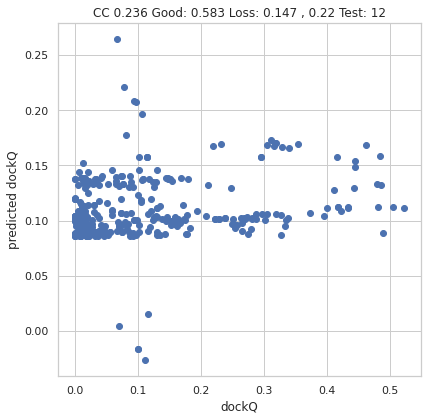

In [16]:
ydata=good_df.dockQ

#cols=["lenA","lenB","msa","long","med","longA","medA","longB","medB","tmA","tmB"]
#xdata=good_df[["lenA","lenB","long","med"]]
#cols=["longA","longB","medA","medB","tmA","tmB"]
cols=["med","long","msa"]
#cols=["msa"]
xdata=good_df[cols]
reg.fit(xdata,ydata)
ypred = reg.predict(xdata)
f, ax = plt.subplots(figsize=(6.5, 6.5))
plt.scatter(ydata,ypred)
cc=np.corrcoef(ydata,ypred)
ax.set_xlabel("dockQ")
ax.set_ylabel("predicted dockQ")
(i,j,dockq,mm)=get_ranks(good_df,ypred)
#print(i,j,k/i)
ax.set_title("CC" + " " + str(round(cc[0,1],3))
            + " Good: " + str(round(j/i,3)) + " Loss: " + str(round(dockq/i,3))
             + " , " + str(round(mm/i,3))
             + " Test: " + str(i)
            )


In [17]:
xdata=df.loc[df.JHparams.isin(JHsets)][cols]
ypred = reg.predict(xdata)
df2=df.loc[df.JHparams.isin(JHsets)].reset_index()
df2.loc[:,'pred'] = ypred
topranked=pd.DataFrame(columns = df2.columns) 


In [18]:

for name in df2.name.unique():
    foo=df2.loc[df2.name==name].sort_values("pred")[-1:].max()
    #print(foo)
    foo_df=pd.DataFrame(foo).transpose()
    #print (foo_df)
    topranked=pd.concat([topranked,foo_df], ignore_index=True)
topranked["JHparams"]="JHranked"
topranked.params="JHranked"
topranked=topranked.drop(["pred","index"],axis=1)
topranked.columns

Index(['name', 'JHparams', 'lenA', 'lenB', 'msa', 'msaA', 'msaB', 'cdhit',
       'dockQ', 'fnat', 'iRMS', 'LRMS', 'fnonnat', 'mm', 'tmA', 'tmB', 'long',
       'med', 'longPPV', 'medPPV', 'longA', 'medA', 'longPPVA', 'medPPVA',
       'longB', 'medB', 'longPPVB', 'medPPVB', 'short', 'shortPPV', 'shortA',
       'shortPPVA', 'shortB', 'shortPPVB', 'shortpdb', 'medpdb', 'longpdb',
       'avprob', 'auc', 'evalue', 'seqid', 'rank', 'code', 'CODE', 'params'],
      dtype='object')

In [19]:
df.columns

Index(['name', 'JHparams', 'lenA', 'lenB', 'msa', 'msaA', 'msaB', 'cdhit',
       'dockQ', 'fnat', 'iRMS', 'LRMS', 'fnonnat', 'mm', 'tmA', 'tmB', 'long',
       'med', 'longPPV', 'medPPV', 'longA', 'medA', 'longPPVA', 'medPPVA',
       'longB', 'medB', 'longPPVB', 'medPPVB', 'short', 'shortPPV', 'shortA',
       'shortPPVA', 'shortB', 'shortPPVB', 'shortpdb', 'medpdb', 'longpdb',
       'avprob', 'auc', 'evalue', 'seqid', 'rank', 'code', 'CODE', 'params'],
      dtype='object')

In [20]:
df=pd.concat([df,topranked], ignore_index=True,sort=False)
df.fillna(0)
df.params.unique()

array(['-N 3 --cpu 8', 'confold', 'gramm', 'homodimer', 'ispred',
       '-N 1 -E 1.e-100 --cpu 8', '-N 1 -E 1.e-2 ', 'N1-merged-pdb',
       'N1-merged', 'N1-N3-merged-fast', 'N1-N3-new', 'N1-N3-multimerged',
       '-N 1 -E 1.e-10 --cpu 8 ', 'N1-top1000-merged', 'N1-top1000',
       'N1-top100', 'N1-top2000', 'N1-top500', 'N3dock',
       '-N 3 --incE 1.e-2', 'N3-merged', 'N3-multimerged', 'N3-newdockA',
       'N3-newdockB', 'N3-newdockC', 'N5-newdockA', 'N5-newdockB',
       'N5-newdockC', '-N 5 --cpu 8', 'pdbconfold', 'pdbcontacts-new',
       'pdbcontacts', 'PDBDOCK2', 'PDBDOCK3', 'PDBDOCK4', 'PDBDOCK',
       'PDBNEWDOCK-standard', 'PDBNEWDOCK-standard--starting',
       'PDBNEWDOCK-standard--step1', 'pdbnewcontacts', 'PDBNEWDOCK-A',
       'PDBNEWDOCK-A--dockB1', 'PDBNEWDOCK-A--dockB2',
       'PDBNEWDOCK-A--dockB-relax', 'PDBNEWDOCK-A--dockC1',
       'PDBNEWDOCK-A--dockC2', 'PDBNEWDOCK-A--dockC-relax',
       'PDBNEWDOCK-A--dockD1', 'PDBNEWDOCK-A--dockD2',
       'PDBNEWDOCK-

In [21]:
df

name      JHparams lenA lenB   msa    msaA    msaB  \
0      1ay7_u1_A-1ay7_u2_A  -N 3 --cpu 8   97   90  1060    1485    2034   
1      1ay7_u2_A-1ay7_u1_A  -N 3 --cpu 8   90   97  1060    2034    1485   
2      1b27_u1_A-1b27_u2_A  -N 3 --cpu 8  109   90   733    1484    2034   
3      1b27_u2_A-1b27_u1_A  -N 3 --cpu 8   90  109   733    2034    1484   
4      1bdj_u1_A-1bdj_u2_A  -N 3 --cpu 8  129  118  5651  349880   23051   
...                    ...           ...  ...  ...   ...     ...     ...   
29328  5cec_u2_A-5cec_u1_A      JHranked  191  403     8   59695     200   
29329  5cra_u1_A-5cra_u2_A      JHranked  193   77     1      11   42026   
29330  5cra_u2_A-5cra_u1_A      JHranked   77  193     1   42026      11   
29331  5eg3_u1_A-5eg3_u2_A      JHranked  303  105   499  560629   26558   
29332  5eg3_u2_A-5eg3_u1_A      JHranked  105  303   305    3955  147816   

      cdhit  dockQ   fnat  ... medpdb longpdb avprob   auc evalue   seqid  \
0      1026  0.298  0.222  ...    178     828  0.108   0.4   9999       0   
1       989  0.239   0.25  ...    188     771  0.112  0.36   9999       0   
2       654  0.223   0.12  ...    187     838  0.096  0.46    4.3      50   
3       656  0.229   0.16  ...    219     922  0.099  0.46    4.3      50   
4      5071      0      0  ...    157    1028   0.02     0   9999       0   
...     ...    ...    ...  ...    ...     ...    ...   ...    ...     ...   
29328     7   0.05  0.075  ...   1039    4734  0.226     0    197  33.333   
29329     1  0.008      0  ...    148     595  0.179     0   9999       0   
29330     1  0.103      0  ...    417    2052  0.181  0.17   9999       0   
29331   278      0      0  ...    221     893  0.046     0     68      40   
29332   102  0.012      0  ...    645    3089  0.098     0     68      40   

      rank  code  CODE        params  
0        1  1ay7  1ay7  -N 3 --cpu 8  
1        2  1ay7  1ay7  -N 3 --cpu 8  
2        1  1b27  1b27  -N 3 --cpu 8  
3        2  1b27  1b27  -N 3 --cpu 8  
4        1  1bdj  1bdj  -N 3 --cpu 8  
...    ...   ...   ...           ...  
29328    2  5cec  5cec      JHranked  
29329    1  5cra  5cra      JHranked  
29330    2  5cra  5cra      JHranked  
29331    1  5eg3  5eg3      JHranked  
29332    2  5eg3  5eg3      JHranked  

[29333 rows x 45 columns]

In [22]:
#df["rank"].str.isnumeric().unique()
#df.dtypes

In [23]:
# We need to check that everything is numeric
cols=['name', 'JHparams', 'seqid',      'rank']

#for d in df.columns.values.tolist():
for d in ["rank","len"]:
    if d=="name": continue
    if d=="JHparams": continue
    print (d)
    #print (df.loc[(df[d].str.isnumeric()!=True)][cols+[d]])
    #print (df.loc[(df[d].str.isnumeric()][d].unique()
    #print (df[d].str.isnumeric().unique())

rank
len


In [24]:
# Divide data into datasets


df["tmAB"]=df[["tmA","tmB"]].mean(axis=1)
df["msaAB"]=df[["msaA","msaB"]].mean(axis=1)
df["tmAB_max"]=df[["tmA","tmB"]].max(axis=1)
df["msaAB_max"]=df[["msaA","msaB"]].max(axis=1)
df["tmAB_min"]=df[["tmA","tmB"]].min(axis=1)
df["msaAB_min"]=df[["msaA","msaB"]].min(axis=1)
df["numcorrect"]=df["longPPV"]*df["long"]
df["len"]=df["lenA"]+df["lenB"]

codes=df.code.unique()
df_mean=df.groupby(["JHparams","code"]).mean()
df_max=df.groupby(["JHparams","code"]).max()
df_min=df.groupby(["JHparams","code"]).min()
df_first=df.loc[df["rank"]==1]

In [25]:
df.columns.values.tolist()

['name',
 'JHparams',
 'lenA',
 'lenB',
 'msa',
 'msaA',
 'msaB',
 'cdhit',
 'dockQ',
 'fnat',
 'iRMS',
 'LRMS',
 'fnonnat',
 'mm',
 'tmA',
 'tmB',
 'long',
 'med',
 'longPPV',
 'medPPV',
 'longA',
 'medA',
 'longPPVA',
 'medPPVA',
 'longB',
 'medB',
 'longPPVB',
 'medPPVB',
 'short',
 'shortPPV',
 'shortA',
 'shortPPVA',
 'shortB',
 'shortPPVB',
 'shortpdb',
 'medpdb',
 'longpdb',
 'avprob',
 'auc',
 'evalue',
 'seqid',
 'rank',
 'code',
 'CODE',
 'params',
 'tmAB',
 'msaAB',
 'tmAB_max',
 'msaAB_max',
 'tmAB_min',
 'msaAB_min',
 'numcorrect',
 'len']

In [26]:
cols=['name', 'JHparams', 'seqid',      'rank']
      
d="TMdock-nohomology"
#df.loc[df.JHparams==d].groupby(["code"])[cols].first()

df.loc[(df.JHparams==d) & ((df["rank"].str.isnumeric()!=True))][cols]
#df.loc[(df.JHparams==d)]["rank"].str.isnumeric()
#df.loc[(df.JHparams==d)] 
      
      

AttributeError: Can only use .str accessor with string values!

In [27]:
datasets=df.JHparams.unique()
data_mean={}
data_max={}
data_min={}
for d in datasets:
    print (d)
    data_mean[d]=df.loc[df.JHparams==d].groupby(["code"]).mean()
    data_max[d]=df.loc[df.JHparams==d].groupby(["code"]).max()
    data_min[d]=df.loc[df.JHparams==d].groupby(["code"]).min()


-N 3 --cpu 8


confold


gramm


homodimer


ispred


-N 1 -E 1.e-100 --cpu 8


-N 1 -E 1.e-2 


N1-merged-pdb


N1-merged


N1-N3-merged-fast


N1-N3-new


N1-N3-multimerged


-N 1 -E 1.e-10 --cpu 8 


N1-top1000-merged


N1-top1000


N1-top100


N1-top2000


N1-top500


N3dock


-N 3 --incE 1.e-2


N3-merged


N3-multimerged


N3-newdockA


N3-newdockB


N3-newdockC


N5-newdockA


N5-newdockB


N5-newdockC


-N 5 --cpu 8


pdbconfold


pdbcontacts-new


pdbcontacts


PDBDOCK2


PDBDOCK3


PDBDOCK4


PDBDOCK


PDBNEWDOCK-standard


PDBNEWDOCK-standard--starting


PDBNEWDOCK-standard--step1


pdbnewcontacts


PDBNEWDOCK-A


PDBNEWDOCK-A--dockB1


PDBNEWDOCK-A--dockB2


PDBNEWDOCK-A--dockB-relax


PDBNEWDOCK-A--dockC1


PDBNEWDOCK-A--dockC2


PDBNEWDOCK-A--dockC-relax


PDBNEWDOCK-A--dockD1


PDBNEWDOCK-A--dockD2


PDBNEWDOCK-A--dockD-relax


PDBNEWDOCK-A--starting


PDBNEWDOCK-A--step1


PDBNEWDOCK-B


PDBNEWDOCK-B--dockB1


PDBNEWDOCK-B--dockB2


PDBNEWDOCK-B--dockB-relax


PDBNEWDOCK-B--dockC1


PDBNEWDOCK-B--dockC2


PDBNEWDOCK-B--dockC-relax


PDBNEWDOCK-B--dockD1


PDBNEWDOCK-B--dockD2


PDBNEWDOCK-B--dockD-relax


PDBNEWDOCK-B--starting


PDBNEWDOCK-B--step1


PDBNEWDOCK-C


PDBNEWDOCK-C--dockB1


PDBNEWDOCK-C--dockB2


PDBNEWDOCK-C--dockB-relax


PDBNEWDOCK-C--dockC1


PDBNEWDOCK-C--dockC2


PDBNEWDOCK-C--dockC-relax


PDBNEWDOCK-C--dockD1


PDBNEWDOCK-C--dockD2


PDBNEWDOCK-C--dockD-relax


PDBNEWDOCK-C--starting


PDBNEWDOCK-C--step1


PDBNEWDOCK-D


PDBNEWDOCK-D--dockB1


PDBNEWDOCK-D--dockB2


PDBNEWDOCK-D--dockB-relax


PDBNEWDOCK-D--dockC1


PDBNEWDOCK-D--dockC2


PDBNEWDOCK-D--dockC-relax


PDBNEWDOCK-D--dockD1


PDBNEWDOCK-D--dockD2


PDBNEWDOCK-D--dockD-relax


PDBNEWDOCK-D--starting


PDBNEWDOCK-D--step1


PDBNEWDOCK-repulsion


PDBNEWDOCK-repulsion--starting


PDBNEWDOCK-repulsion--step1


pdbsurface
rbh-jh


rbh-merged-pdb


rbh-merged


rbh


TMdock-nohomology-1.e-5


TMdock-double


TMdock-nohomology


TMdock


trRosetta


PDB


JHranked


In [28]:
df.loc[ (df.JHparams=="trRosetta")  & (df["rank"]==1)]

name   JHparams lenA lenB   msa    msaA    msaB cdhit  \
20471  1ay7_u1_A-1ay7_u2_A  trRosetta   97   90  1060    1485    2034  1026   
20473  1b27_u1_A-1b27_u2_A  trRosetta  109   90   733    1484    2034   654   
20475  1bdj_u1_A-1bdj_u2_A  trRosetta  129  118  5651  349880   23051  5071   
20477  1buh_u1_A-1buh_u2_A  trRosetta  291   72  1177  555226    1820   548   
20479  1bvn_u1_A-1bvn_u2_A  trRosetta  496   75    95   52623     123    85   
...                    ...        ...  ...  ...   ...     ...     ...   ...   
25657  4y5o_u1_A-4y5o_u2_A  trRosetta   94   85    34    3100    1781    11   
25658  4zfr_u1_A-4zfr_u2_A  trRosetta  186   77    12    9290   38386    12   
25659  5brr_u1_A-5brr_u2_A  trRosetta  378  266   107   13553   45450    79   
25660  5cec_u1_A-5cec_u2_A  trRosetta  403  191     7   30621  309307     7   
25661  5eg3_u1_A-5eg3_u2_A  trRosetta  303  105     7  565997   25926     5   

       dockQ   fnat  ...  CODE     params      tmAB     msaAB tmAB_max  \
20471  0.298  0.222  ...  1ay7  trRosetta  0.828190    1759.5  0.84625   
20473  0.223   0.12  ...  1b27  trRosetta  0.824750    1759.0  0.85428   
20475      0      0  ...  1bdj  trRosetta  0.861435  186465.5  0.92240   
20477      0      0  ...  1buh  trRosetta  0.560760  278523.0  0.73259   
20479  0.006      0  ...  1bvn  trRosetta  0.619740   26373.0  0.70905   
...      ...    ...  ...   ...        ...       ...       ...      ...   
25657  0.055      0  ...  4y5o  trRosetta  0.568465    2440.5  0.71099   
25658  0.048      0  ...  4zfr  trRosetta  0.505235   23838.0  0.64391   
25659  0.009      0  ...  5brr  trRosetta  0.332210   29501.5  0.38444   
25660  0.011      0  ...  5cec  trRosetta  0.508770  169964.0  0.70983   
25661  0.003      0  ...  5eg3  trRosetta  0.358330  295961.5  0.41599   

      msaAB_max tmAB_min msaAB_min numcorrect  len  
20471    2034.0  0.81013    1485.0     53.985  187  
20473    2034.0  0.79522    1484.0     49.025  199  
20475  349880.0  0.80047   23051.0          0  247  
20477  555226.0  0.38893    1820.0          0  363  
20479   52623.0  0.53043     123.0          0  571  
...         ...      ...       ...        ...  ...  
25657    3100.0  0.42594    1781.0          0  179  
25658   38386.0  0.36656    9290.0          3  263  
25659   45450.0  0.27998   13553.0        468  644  
25660  309307.0  0.30771   30621.0      2.006  594  
25661  565997.0  0.30067   25926.0          0  408  

[2819 rows x 53 columns]

In [29]:
df.JHparams.unique()
datasets

array(['-N 3 --cpu 8', 'confold', 'gramm', 'homodimer', 'ispred',
       '-N 1 -E 1.e-100 --cpu 8', '-N 1 -E 1.e-2 ', 'N1-merged-pdb',
       'N1-merged', 'N1-N3-merged-fast', 'N1-N3-new', 'N1-N3-multimerged',
       '-N 1 -E 1.e-10 --cpu 8 ', 'N1-top1000-merged', 'N1-top1000',
       'N1-top100', 'N1-top2000', 'N1-top500', 'N3dock',
       '-N 3 --incE 1.e-2', 'N3-merged', 'N3-multimerged', 'N3-newdockA',
       'N3-newdockB', 'N3-newdockC', 'N5-newdockA', 'N5-newdockB',
       'N5-newdockC', '-N 5 --cpu 8', 'pdbconfold', 'pdbcontacts-new',
       'pdbcontacts', 'PDBDOCK2', 'PDBDOCK3', 'PDBDOCK4', 'PDBDOCK',
       'PDBNEWDOCK-standard', 'PDBNEWDOCK-standard--starting',
       'PDBNEWDOCK-standard--step1', 'pdbnewcontacts', 'PDBNEWDOCK-A',
       'PDBNEWDOCK-A--dockB1', 'PDBNEWDOCK-A--dockB2',
       'PDBNEWDOCK-A--dockB-relax', 'PDBNEWDOCK-A--dockC1',
       'PDBNEWDOCK-A--dockC2', 'PDBNEWDOCK-A--dockC-relax',
       'PDBNEWDOCK-A--dockD1', 'PDBNEWDOCK-A--dockD2',
       'PDBNEWDOCK-

In [30]:
data_first={}
data_second={}
for d in datasets:
    data_first[d]=df.loc[ (df["JHparams"]==d)  & (df["rank"]==1)]
    data_second[d]=df.loc[ (df["JHparams"]==d)  & (df["rank"]==2)]
data_first

{'-N 3 --cpu 8':                     name      JHparams lenA lenB   msa    msaA    msaB cdhit  \
 0    1ay7_u1_A-1ay7_u2_A  -N 3 --cpu 8   97   90  1060    1485    2034  1026   
 2    1b27_u1_A-1b27_u2_A  -N 3 --cpu 8  109   90   733    1484    2034   654   
 4    1bdj_u1_A-1bdj_u2_A  -N 3 --cpu 8  129  118  5651  349880   23051  5071   
 6    1buh_u1_A-1buh_u2_A  -N 3 --cpu 8  291   72  1177  555226    1820   548   
 8    1bvn_u1_A-1bvn_u2_A  -N 3 --cpu 8  496   75    95   52623     123    85   
 ..                   ...           ...  ...  ...   ...     ...     ...   ...   
 426  4zfr_u1_A-4zfr_u2_A  -N 3 --cpu 8  186   77  1358    9290   38386   490   
 428  5brr_u1_A-5brr_u2_A  -N 3 --cpu 8  378  266   611   13553   45450   550   
 430  5cec_u1_A-5cec_u2_A  -N 3 --cpu 8  403  191  1594   30621  309307  1577   
 432  5cra_u1_A-5cra_u2_A  -N 3 --cpu 8  193   77     1      11   38383     1   
 434  5eg3_u1_A-5eg3_u2_A  -N 3 --cpu 8  303  105   421  565997   25926   205   
 
      dock

In [31]:
datasets


array(['-N 3 --cpu 8', 'confold', 'gramm', 'homodimer', 'ispred',
       '-N 1 -E 1.e-100 --cpu 8', '-N 1 -E 1.e-2 ', 'N1-merged-pdb',
       'N1-merged', 'N1-N3-merged-fast', 'N1-N3-new', 'N1-N3-multimerged',
       '-N 1 -E 1.e-10 --cpu 8 ', 'N1-top1000-merged', 'N1-top1000',
       'N1-top100', 'N1-top2000', 'N1-top500', 'N3dock',
       '-N 3 --incE 1.e-2', 'N3-merged', 'N3-multimerged', 'N3-newdockA',
       'N3-newdockB', 'N3-newdockC', 'N5-newdockA', 'N5-newdockB',
       'N5-newdockC', '-N 5 --cpu 8', 'pdbconfold', 'pdbcontacts-new',
       'pdbcontacts', 'PDBDOCK2', 'PDBDOCK3', 'PDBDOCK4', 'PDBDOCK',
       'PDBNEWDOCK-standard', 'PDBNEWDOCK-standard--starting',
       'PDBNEWDOCK-standard--step1', 'pdbnewcontacts', 'PDBNEWDOCK-A',
       'PDBNEWDOCK-A--dockB1', 'PDBNEWDOCK-A--dockB2',
       'PDBNEWDOCK-A--dockB-relax', 'PDBNEWDOCK-A--dockC1',
       'PDBNEWDOCK-A--dockC2', 'PDBNEWDOCK-A--dockC-relax',
       'PDBNEWDOCK-A--dockD1', 'PDBNEWDOCK-A--dockD2',
       'PDBNEWDOCK-

In [32]:
df_merged = pd.merge(data_first[datasets[0]],data_first[d], on=['code'],how="inner")
df_max

name  lenA  lenB     msa  \
JHparams                code                                            
-N 1 -E 1.e-10 --cpu 8  1ay7  1ay7_u2_A-1ay7_u1_A    97    97     2.0   
                        1b27  1b27_u2_A-1b27_u1_A   109   109    35.0   
                        1bdj  1bdj_u2_A-1bdj_u1_A   129   129   201.0   
                        1buh  1buh_u2_A-1buh_u1_A   291   291   899.0   
                        1bvn  1bvn_u2_A-1bvn_u1_A   496   496     7.0   
...                                           ...   ...   ...     ...   
trRosetta               4zfr  4zfr_u2_A-4zfr_u1_A   186   186  1358.0   
                        5brr  5brr_u2_A-5brr_u1_A   378   378   611.0   
                        5cec  5cec_u2_A-5cec_u1_A   403   403  1594.0   
                        5cra  5cra_u2_A-5cra_u1_A   193   193     1.0   
                        5eg3  5eg3_u2_A-5eg3_u1_A   303   303   499.0   

                                  msaA      msaB  cdhit  dockQ   fnat  \
JHparams                code                                            
-N 1 -E 1.e-10 --cpu 8  1ay7     960.0     960.0      2  0.023  0.000   
                        1b27     272.0     272.0     34  0.019  0.000   
                        1bdj   29395.0   29395.0    124  0.024  0.000   
                        1buh  255874.0  255874.0    401  0.061  0.000   
                        1bvn    2041.0    2041.0      7  0.038  0.000   
...                                ...       ...    ...    ...    ...   
trRosetta               4zfr   42037.0   42037.0    504  0.048  0.000   
                        5brr   45636.0   45970.0    550  0.035  0.073   
                        5cec  312612.0  312612.0   1577  0.059  0.084   
                        5cra   42026.0   42026.0      1  0.103  0.036   
                        5eg3  565997.0  565997.0    279  0.028  0.000   

                                 iRMS  ...  CODE                   params  \
JHparams                code           ...                                  
-N 1 -E 1.e-10 --cpu 8  1ay7   15.615  ...  1ay7  -N 1 -E 1.e-10 --cpu 8    
                        1b27   99.396  ...  1b27  -N 1 -E 1.e-10 --cpu 8    
                        1bdj   17.785  ...  1bdj  -N 1 -E 1.e-10 --cpu 8    
                        1buh  491.316  ...  1buh  -N 1 -E 1.e-10 --cpu 8    
                        1bvn   19.311  ...  1bvn  -N 1 -E 1.e-10 --cpu 8    
...                               ...  ...   ...                      ...   
trRosetta               4zfr  291.376  ...  4zfr                trRosetta   
                        5brr  642.702  ...  5brr                trRosetta   
                        5cec  732.223  ...  5cec                trRosetta   
                        5cra   22.323  ...  5cra                trRosetta   
                        5eg3  542.531  ...  5eg3                trRosetta   

                                  tmAB     msaAB  tmAB_max  msaAB_max  \
JHparams                code                                            
-N 1 -E 1.e-10 --cpu 8  1ay7  0.468725     503.0   0.56969      960.0   
                        1b27  0.662735     158.0   0.66638      272.0   
                        1bdj  0.824210   14815.0   0.84941    29395.0   
                        1buh  0.650535  128775.0   0.72158   255874.0   
                        1bvn  0.313205    1023.5   0.33372     2041.0   
...                                ...       ...       ...        ...   
trRosetta               4zfr  0.868090   28229.0   0.91806    42037.0   
                        5brr  0.848585   29785.0   0.97832    45970.0   
                        5cec  0.782885  172839.5   0.86787   312612.0   
                        5cra  0.694590   21018.5   0.91714    42026.0   
                        5eg3  0.833605  295961.5   0.86145   565997.0   

                              tmAB_min  msaAB_min  numcorrect  len  
JHparams                code                                        
-N 1 -E 1.e-10 --cpu 8  1ay7   0.36776       46.0      

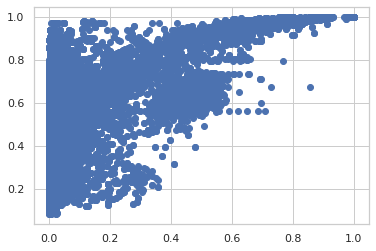

In [33]:

plt.scatter(df.dockQ,df.mm)


Text(0, 0.5, 'TM trRosetta')

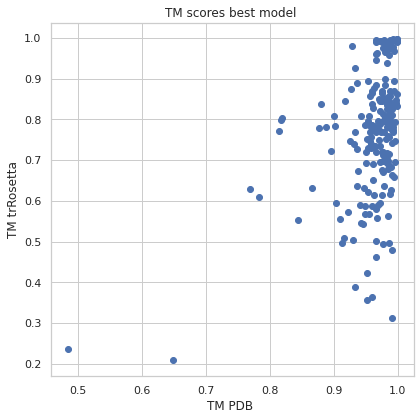

In [34]:
cutoff=0.2
f, ax = plt.subplots(figsize=(6.5, 6.5))
df_merged = pd.merge(data_max["PDB"],data_max["trRosetta"], on=['code'],how="inner")
plt.scatter(df_merged.tmAB_x,df_merged.tmAB_y,label=d)
ax.set_title("TM scores best model ")
ax.set_xlabel("TM PDB ")
ax.set_ylabel("TM trRosetta")



Text(0, 0.5, 'dockQ')

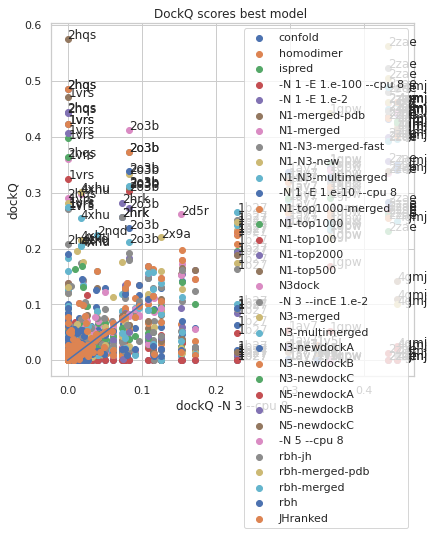

In [35]:
cutoff=0.2
f, ax = plt.subplots(figsize=(6.5, 6.5))
for d in datasets:
    if d == datasets[0]: continue
    if d=="gramm":continue   
    if d[0:3]=="PDB":continue   
    if d[0:3]=="pdb":continue   
    if d[0:3]=="TMd":continue   
    if d=="trRosetta":continue   
    #if d=="confold":continue   
    #if d=="rbh-merged-pdb":continue   

    df_merged = pd.merge(data_max[datasets[0]],data_max[d], on=['code'],how="inner")
    #print (df_merged)
    #newdf=df_merged["dockQ_x","dockQ_y"]  #.loc[(df_merged.dockQ_x>cutoff or df_merged.dockQ_y>cutoff) ]
    plt.scatter(df_merged.dockQ_x,df_merged.dockQ_y,label=d)
    for i, txt in enumerate(df_merged.name_x):
        #print (i,txt)
        try: 
            sstr=txt[0:4] # +d
        except:
            sstr=df_merged.name_y[i][0:4] #+d
        if (df_merged.dockQ_x[i]> cutoff or df_merged.dockQ_y[i]>cutoff):
            ax.annotate(sstr, (df_merged.dockQ_x[i], df_merged.dockQ_y[i]))
x=[0,0.1]
y=[0,0.1]
plt.plot(x,y)
ax.legend()
ax.set_title("DockQ scores best model ")
ax.set_xlabel("dockQ "+str(datasets[0]))
ax.set_ylabel("dockQ")

#cat.add_categories([1])
#df_merged.fillna(0, inplace =True)

Text(0, 0.5, 'numcorrect')

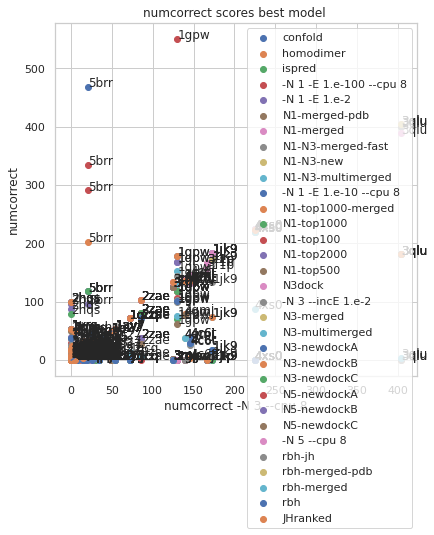

In [36]:
cutoff=5
f, ax = plt.subplots(figsize=(6.5, 6.5))
for d in datasets:
    if d == datasets[0]: continue
    if d=="gramm":continue   
    if d=="trRosetta":continue 
    if d[0:3]=="PDB":continue   
    if d[0:3]=="pdb":continue   
    if d[0:3]=="TMd":continue   
        
    #if d=="confold":continue   
    #if d=="rbh-merged-pdb":continue   

    df_merged = pd.merge(data_max[datasets[0]],data_max[d], on=['code'],how="inner")
    #print (df_merged)
    #newdf=df_merged["dockQ_x","dockQ_y"]  #.loc[(df_merged.dockQ_x>cutoff or df_merged.dockQ_y>cutoff) ]
    plt.scatter(df_merged.numcorrect_x,df_merged.numcorrect_y,label=d)
    for i, txt in enumerate(df_merged.name_x):
        #print (i,txt)
        try: 
            sstr=txt[0:4]
        except:
            sstr=df_merged.name_y[i][0:4]
        if (df_merged.numcorrect_x[i]> cutoff or df_merged.numcorrect_y[i]>cutoff):
            ax.annotate(sstr, (df_merged.numcorrect_x[i], df_merged.numcorrect_y[i]))
x=[0,50]
y=[0,50]
plt.plot(x,y)
ax.legend()
ax.set_title("numcorrect scores best model ")
ax.set_xlabel("numcorrect "+str(datasets[0]))
ax.set_ylabel("numcorrect")

#cat.add_categories([1])
#df_merged.fillna(0, inplace =True)

Text(0, 0.5, 'dockQ')

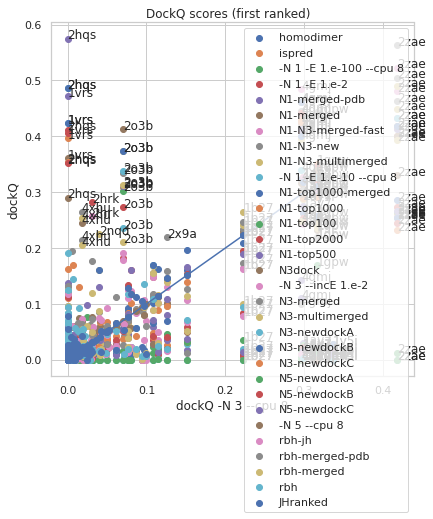

In [141]:
cutoff=0.2
f, ax = plt.subplots(figsize=(6.5, 6.5))
for d in datasets:
    if d == datasets[0]: continue
    if d=="gramm":continue   
    if d=="trRosetta":continue   
    if d=="confold":continue   
    #if d=="rbh-merged-pdb":continue   
    if d[0:3]=="PDB":continue   
    if d[0:3]=="pdb":continue   
    if d[0:3]=="TMd":continue   
    #if d!="N1-merged":continue   
    #print (d)
    df_merged = pd.merge(data_first[datasets[0]],data_first[d], on=['code'],how="inner")
    #print (df_merged)
    #newdf=df_merged["dockQ_x","dockQ_y"]  #.loc[(df_merged.dockQ_x>cutoff or df_merged.dockQ_y>cutoff) ]
    plt.scatter(df_merged.dockQ_x,df_merged.dockQ_y,label=d)
    for i, txt in enumerate(df_merged.name_x):
        #print (i,txt)
        try: 
            sstr=txt[0:4]
        except:
            sstr=df_merged.name_y[i][0:4]
        if (df_merged.dockQ_x[i]> cutoff or df_merged.dockQ_y[i]>cutoff):
            ax.annotate(sstr, (df_merged.dockQ_x[i], df_merged.dockQ_y[i]))
x=[0,0.3]
y=[0,0.3]
plt.plot(x,y)
ax.legend()
ax.set_title("DockQ scores (first ranked)  ")
ax.set_xlabel("dockQ "+str(datasets[0]))
ax.set_ylabel("dockQ")

#cat.add_categories([1])
#df_merged.fillna(0, inplace =True)

Text(0, 0.5, 'dockQ')

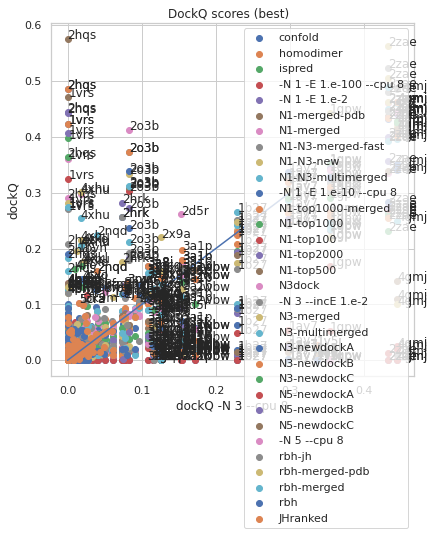

In [38]:
cutoff=0.1
f, ax = plt.subplots(figsize=(6.5, 6.5))
for d in datasets:
    if d == datasets[0]: continue
    if d=="gramm":continue   
    if d=="trRosetta":continue   
    if d=="rbh merge pdb ":continue   
    if d[0:3]=="PDB":continue   
    if d[0:3]=="pdb":continue   
    if d[0:3]=="TMd":continue   
        
    #if d!="N1-merged":continue   
    #print (d)
    df_merged = pd.merge(data_max[datasets[0]],data_max[d], on=['code'],how="inner")
    #print (df_merged)
    #newdf=df_merged["dockQ_x","dockQ_y"]  #.loc[(df_merged.dockQ_x>cutoff or df_merged.dockQ_y>cutoff) ]
    plt.scatter(df_merged.dockQ_x,df_merged.dockQ_y,label=d)
    for i, txt in enumerate(df_merged.name_x):
        #print (i,txt)
        try: 
            sstr=txt[0:4]
        except:
            sstr=df_merged.name_y[i][0:4]
        if (df_merged.dockQ_x[i]> cutoff or df_merged.dockQ_y[i]>cutoff):
            ax.annotate(sstr, (df_merged.dockQ_x[i], df_merged.dockQ_y[i]))
x=[0,0.3]
y=[0,0.3]
plt.plot(x,y)
ax.legend()
ax.set_title("DockQ scores (best)  ")
ax.set_xlabel("dockQ "+str(datasets[0]))
ax.set_ylabel("dockQ")

#cat.add_categories([1])
#df_merged.fillna(0, inplace =True)

Text(0, 0.5, 'dockQ')

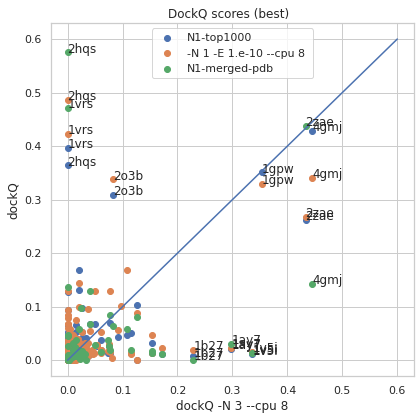

In [39]:
cutoff=0.2
f, ax = plt.subplots(figsize=(6.5, 6.5))
for d in ["N1-top1000","-N 1 -E 1.e-10 --cpu 8 ","N1-merged-pdb"]:
    if d == datasets[0]: continue
    if d=="gramm":continue   
    if d=="trRosetta":continue   
    if d=="rbh merge pdb ":continue   
    if d[0:3]=="PDB":continue   
    if d[0:3]=="pdb":continue   
    if d[0:3]=="TMd":continue   
        
    #if d!="N1-merged":continue   
    #print (d)
    df_merged = pd.merge(data_max[datasets[0]],data_max[d], on=['code'],how="inner")
    #print (df_merged)
    #newdf=df_merged["dockQ_x","dockQ_y"]  #.loc[(df_merged.dockQ_x>cutoff or df_merged.dockQ_y>cutoff) ]
    plt.scatter(df_merged.dockQ_x,df_merged.dockQ_y,label=d)
    for i, txt in enumerate(df_merged.name_x):
        #print (i,txt)
        try: 
            sstr=txt[0:4]
        except:
            sstr=df_merged.name_y[i][0:4]
        if (df_merged.dockQ_x[i]> cutoff or df_merged.dockQ_y[i]>cutoff):
            ax.annotate(sstr, (df_merged.dockQ_x[i], df_merged.dockQ_y[i]))
x=[0,0.6]
y=[0,0.6]
plt.plot(x,y)
ax.legend()
ax.set_title("DockQ scores (best)  ")
ax.set_xlabel("dockQ "+str(datasets[0]))
ax.set_ylabel("dockQ")

#cat.add_categories([1])
#df_merged.fillna(0, inplace =True)

In [40]:
data_max.keys()

dict_keys(['-N 3 --cpu 8', 'confold', 'gramm', 'homodimer', 'ispred', '-N 1 -E 1.e-100 --cpu 8', '-N 1 -E 1.e-2 ', 'N1-merged-pdb', 'N1-merged', 'N1-N3-merged-fast', 'N1-N3-new', 'N1-N3-multimerged', '-N 1 -E 1.e-10 --cpu 8 ', 'N1-top1000-merged', 'N1-top1000', 'N1-top100', 'N1-top2000', 'N1-top500', 'N3dock', '-N 3 --incE 1.e-2', 'N3-merged', 'N3-multimerged', 'N3-newdockA', 'N3-newdockB', 'N3-newdockC', 'N5-newdockA', 'N5-newdockB', 'N5-newdockC', '-N 5 --cpu 8', 'pdbconfold', 'pdbcontacts-new', 'pdbcontacts', 'PDBDOCK2', 'PDBDOCK3', 'PDBDOCK4', 'PDBDOCK', 'PDBNEWDOCK-standard', 'PDBNEWDOCK-standard--starting', 'PDBNEWDOCK-standard--step1', 'pdbnewcontacts', 'PDBNEWDOCK-A', 'PDBNEWDOCK-A--dockB1', 'PDBNEWDOCK-A--dockB2', 'PDBNEWDOCK-A--dockB-relax', 'PDBNEWDOCK-A--dockC1', 'PDBNEWDOCK-A--dockC2', 'PDBNEWDOCK-A--dockC-relax', 'PDBNEWDOCK-A--dockD1', 'PDBNEWDOCK-A--dockD2', 'PDBNEWDOCK-A--dockD-relax', 'PDBNEWDOCK-A--starting', 'PDBNEWDOCK-A--step1', 'PDBNEWDOCK-B', 'PDBNEWDOCK-B--dock

Text(0, 0.5, 'dockQ trRosetta')

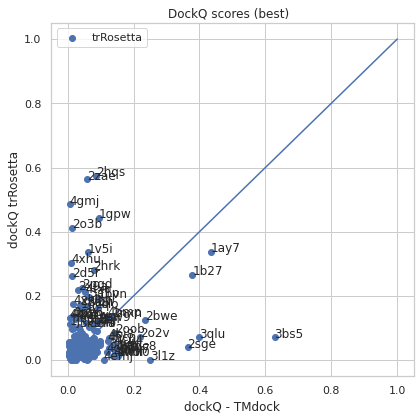

In [41]:
cutoff=0.1
f, ax = plt.subplots(figsize=(6.5, 6.5))
for d in ["trRosetta"]:
    #if d!="N1-merged":continue   
    #print (d)
    df_merged = pd.merge(data_max["TMdock-double"],data_max[d], on=['code'],how="inner")
    #print (df_merged)
    #newdf=df_merged["dockQ_x","dockQ_y"]  #.loc[(df_merged.dockQ_x>cutoff or df_merged.dockQ_y>cutoff) ]
    plt.scatter(df_merged.dockQ_x,df_merged.dockQ_y,label=d)
    for i, txt in enumerate(df_merged.name_x):
        #print (i,txt)
        try: 
            sstr=txt[0:4]
        except:
            sstr=df_merged.name_y[i][0:4]
        if (df_merged.dockQ_x[i]> cutoff or df_merged.dockQ_y[i]>cutoff):
            ax.annotate(sstr, (df_merged.dockQ_x[i], df_merged.dockQ_y[i]))
x=[0,1.0]
y=[0,1.0]
plt.plot(x,y)
ax.legend()
ax.set_title("DockQ scores (best)  ")
ax.set_xlabel("dockQ - TMdock")
ax.set_ylabel("dockQ "+d)

#cat.add_categories([1])
#df_merged.fillna(0, inplace =True)

Text(0, 0.5, 'dockQ trRosetta')

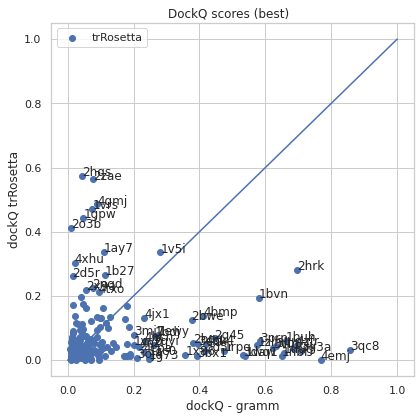

In [42]:
cutoff=0.2
f, ax = plt.subplots(figsize=(6.5, 6.5))
for d in ["trRosetta"]:
    #if d!="N1-merged":continue   
    #print (d)
    df_merged = pd.merge(data_max["gramm"],data_max[d], on=['code'],how="inner")
    #print (df_merged)
    #newdf=df_merged["dockQ_x","dockQ_y"]  #.loc[(df_merged.dockQ_x>cutoff or df_merged.dockQ_y>cutoff) ]
    plt.scatter(df_merged.dockQ_x,df_merged.dockQ_y,label=d)
    for i, txt in enumerate(df_merged.name_x):
        #print (i,txt)
        try: 
            sstr=txt[0:4]
        except:
            sstr=df_merged.name_y[i][0:4]
        if (df_merged.dockQ_x[i]> cutoff or df_merged.dockQ_y[i]>cutoff):
            ax.annotate(sstr, (df_merged.dockQ_x[i], df_merged.dockQ_y[i]))
x=[0,1.0]
y=[0,1.0]
plt.plot(x,y)
ax.legend()
ax.set_title("DockQ scores (best)  ")
ax.set_xlabel("dockQ - gramm")
ax.set_ylabel("dockQ "+d)

#cat.add_categories([1])
#df_merged.fillna(0, inplace =True)

In [43]:
d="TMdock"
foo=pd.merge(data_first["gramm"],data_first[d], on=['code'],how="inner")
data_first[d].dockQ
foo[["dockQ_x","dockQ_y"]]
#cc=np.corrcoef(foo.dockQ_x,foo.dockQ_y)

foo.dockQ_y.isna().unique()
data_first[d].dockQ.isna().unique()

array([False])

TMdock
217 217


Text(20.200000000000003, 0.5, 'dockQ TMdock')

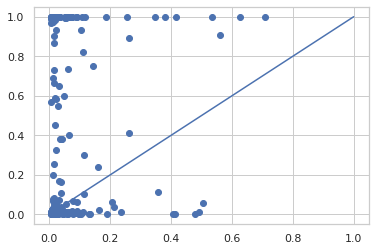

In [44]:
cutoff=0.1
#f, ax = plt.subplots(figsize=(6.5, 6.5))
for d in ["TMdock"]:
    #if d!="N1-merged":continue   
    print (d)
    df_merged = pd.merge(data_first["gramm"],data_first[d], on=['code'],how="inner")
    #print (df_merged)
    #newdf=df_merged["dockQ_x","dockQ_y"]  #.loc[(df_merged.dockQ_x>cutoff or df_merged.dockQ_y>cutoff) ]
    plt.scatter(df_merged.dockQ_x,df_merged.dockQ_y,label=d)
    #sns.jointplot(x="dockQ_x", y="dockQ_y", data=df_merged)
    print(df_merged.dockQ_x.shape[0],df_merged.dockQ_y.shape[0])
    #cc=np.corrcoef(df_merged.dockQ_x,df_merged.dockQ_x)
    #print (cc)
    for i, txt in enumerate(df_merged.name_x):
        #print (i,txt)
        try: 
            sstr=txt[0:4]
        except:
            sstr=df_merged.name_y[i][0:4]
        if (df_merged.dockQ_x[i]> cutoff or df_merged.dockQ_y[i]>cutoff):
            ax.annotate(sstr, (df_merged.dockQ_x[i], df_merged.dockQ_y[i]))
x=[0,1.0]
y=[0,1.0]
plt.plot(x,y)
ax.legend()
ax.set_title("dockQ scores (first model) ") #, CC=" + str(round(cc[0,1],3)) )
ax.set_xlabel("dockQ Gramm")
ax.set_ylabel("dockQ TMdock")

#cat.add_categories([1])
#df_merged.fillna(0, inplace =True)

Text(20.200000000000003, 0.5, 'dockQ TMdock-nohomology')

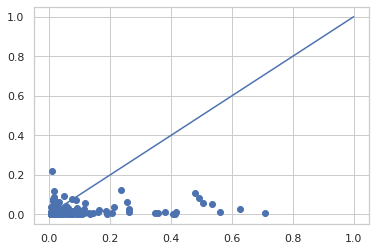

In [45]:
cutoff=0.1
#f, ax = plt.subplots(figsize=(6.5, 6.5))
for d in ["TMdock-nohomology"]:
    #if d!="N1-merged":continue   
    #print (d)
    df_merged = pd.merge(data_first["gramm"],data_first[d], on=['code'],how="inner")
    #print (df_merged)
    #newdf=df_merged["dockQ_x","dockQ_y"]  #.loc[(df_merged.dockQ_x>cutoff or df_merged.dockQ_y>cutoff) ]
    plt.scatter(df_merged.dockQ_x,df_merged.dockQ_y,label=d)
    #sns.jointplot(x="dockQ_x", y="dockQ_y", data=df_merged)
    #cc=np.corrcoef(df_merged.dockQ_y,df_merged.dockQ_y)
    #print (cc)
    for i, txt in enumerate(df_merged.name_x):
        #print (i,txt)
        try: 
            sstr=txt[0:4]
        except:
            sstr=df_merged.name_y[i][0:4]
        if (df_merged.dockQ_x[i]> cutoff or df_merged.dockQ_y[i]>cutoff):
            ax.annotate(sstr, (df_merged.dockQ_x[i], df_merged.dockQ_y[i]))
x=[0,1.0]
y=[0,1.0]
plt.plot(x,y)
ax.legend()
ax.set_title("dockQ scores (first model), CC=" + str(round(cc[0,1],3)) )
ax.set_xlabel("dockQ Gramm")
ax.set_ylabel("dockQ TMdock-nohomology")

#cat.add_categories([1])
#df_merged.fillna(0, inplace =True)

Text(0, 0.5, 'dockQ TMdock')

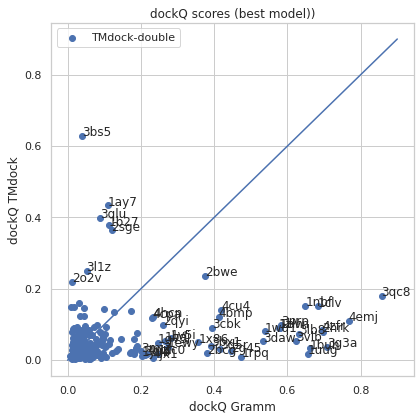

In [46]:
cutoff=0.2
f, ax = plt.subplots(figsize=(6.5, 6.5))
for d in ["TMdock-double"]:
    #if d!="N1-merged":continue   
    #print (d)
    df_merged = pd.merge(data_max["gramm"],data_max[d], on=['code'],how="inner")
    #print (df_merged)
    #newdf=df_merged["dockQ_x","dockQ_y"]  #.loc[(df_merged.dockQ_x>cutoff or df_merged.dockQ_y>cutoff) ]
    cc=np.corrcoef(df_merged.dockQ_x,df_merged.dockQ_y)
    #print (cc)
    
    
    plt.scatter(df_merged.dockQ_x,df_merged.dockQ_y,label=d)
    for i, txt in enumerate(df_merged.name_x):
        #print (i,txt)
        try: 
            sstr=txt[0:4]
        except:
            sstr=df_merged.name_y[i][0:4]
        if (df_merged.dockQ_x[i]> cutoff or df_merged.dockQ_y[i]>cutoff):
            ax.annotate(sstr, (df_merged.dockQ_x[i], df_merged.dockQ_y[i]))
x=[0,0.9]
y=[0,0.9]
plt.plot(x,y)
ax.legend()
ax.set_title("dockQ scores (best model))" )
ax.set_xlabel("dockQ Gramm")
ax.set_ylabel("dockQ TMdock")

#cat.add_categories([1])
#df_merged.fillna(0, inplace =True)

Text(0, 0.5, 'dockQ')

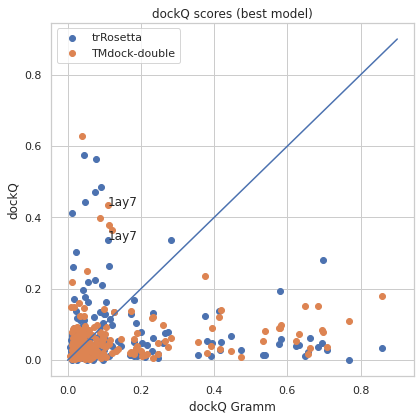

In [47]:
cutoff=0.2
f, ax = plt.subplots(figsize=(6.5, 6.5))
for d in ["trRosetta","TMdock-double"]:
    #if d!="N1-merged":continue   
    #print (d)
    df_merged = pd.merge(data_max["gramm"],data_max[d], on=['code'],how="inner")
    #print (df_merged)
    #newdf=df_merged["dockQ_x","dockQ_y"]  #.loc[(df_merged.dockQ_x>cutoff or df_merged.dockQ_y>cutoff) ]
    cc=np.corrcoef(df_merged.dockQ_x,df_merged.dockQ_y)
    #print (cc)
    
    
    plt.scatter(df_merged.dockQ_x,df_merged.dockQ_y,label=d)
    for i, txt in enumerate(df_merged.name_x):
        #print (i,txt)
        try: 
            sstr=txt[0:4]
        except:
            sstr=df_merged.name_y[i][0:4]
        #if (sstr=="3qc8" or sstr=="2hqs" or sstr=="3bs5" ):
        if (sstr=="1ay7" ):
            #if (df_merged.dockQ_y[i]> cutoff and (df_merged.dockQ_y[i]>df_merged.dockQ_x[i])):
            ax.annotate(sstr, (df_merged.dockQ_x[i], df_merged.dockQ_y[i]))
x=[0,0.9]
y=[0,0.9]
plt.plot(x,y)
ax.legend()
ax.set_title("dockQ scores (best model)") 
ax.set_xlabel("dockQ Gramm")
ax.set_ylabel("dockQ")

#cat.add_categories([1])
#df_merged.fillna(0, inplace =True)

In [48]:
df_merged = df_max[df_max["params"].isin(["trRosetta","gramm","TMdock-double"])]
df_merged.sort_values("dockQ")

name  lenA  lenB     msa      msaA      msaB  \
JHparams  code                                                                
trRosetta 3rj3  3rj3_u2_A-3rj3_u1_A   295   295   359.0   55937.0   55937.0   
          4emj  4emj_u2_A-4emj_u1_A   403   403  6589.0  354953.0  354953.0   
          3l1z  3l1z_u2_A-3l1z_u1_A   153   153  1390.0  136672.0  136672.0   
          3fap  3fap_u2_A-3fap_u1_A   108   108  1208.0   35975.0   35975.0   
          1fle  1fle_u2_A-1fle_u1_A   241   241   320.0   45703.0   45351.0   
...                             ...   ...   ...     ...       ...       ...   
gramm     4zfr  4zfr_u1_A-4zfr_u2_A   186    77     0.0       0.0       0.0   
          2hrk  2hrk_u1_A-2hrk_u2_A   181   121     0.0       0.0       0.0   
          3g3a  3g3a_u1_A-3g3a_u2_A   166   130     0.0       0.0       0.0   
          4emj  4emj_u1_A-4emj_u2_A   403   106     0.0       0.0       0.0   
          3qc8  3qc8_u1_A-3qc8_u2_A   169    82     0.0       0.0       0.0   

                cdhit  dockQ   fnat     iRMS  ...  CODE     params      tmAB  \
JHparams  code                                ...                              
trRosetta 3rj3    247  0.000  0.000  515.213  ...  3rj3  trRosetta  0.635370   
          4emj   5681  0.000  0.000  687.538  ...  4emj  trRosetta  0.884110   
          3l1z    830  0.000  0.000  261.906  ...  3l1z  trRosetta  0.776680   
          3fap    573  0.000  0.000  187.525  ...  3fap  trRosetta  0.840125   
          1fle    247  0.001  0.000  397.029  ...  1fle  trRosetta  0.674835   
...               ...    ...    ...      ...  ...   ...        ...       ...   
gramm     4zfr      0  0.695  0.887    9.940  ...  4zfr      gramm  1.000000   
          2hrk      0  0.696  0.978   13.721  ...  2hrk      gramm  1.000000   
          3g3a      0  0.708  0.787   11.568  ...  3g3a      gramm  1.000000   
          4emj      0  0.768  0.762    3.742  ...  4emj      gramm  1.000000   
          3qc8      0  0.857  0.977   11.047  ...  3qc8      gramm  1.000000   

                   msaAB  tmAB_max  msaAB_max  tmAB_min  msaAB_min  \
JHparams  code                                                       
trRosetta 3rj3   39722.5   0.80210    55937.0   0.48427    23508.0   
          4emj  195361.5   0.90839   354953.0   0.86736    35929.0   
          3l1z   87194.0   0.83424   136672.0   0.72778    37864.0   
          3fap   18731.0   0.87845    35975.0   0.80207     1489.0   
          1fle   25264.0   0.89618    45703.0   0.45998     4825.0   
...                  ...       ...        ...       ...        ...   
gramm     4zfr       0.0   1.00000        0.0   1.00000        0.0   
          2hrk       0.0   1.00000        0.0   1.00000        0.0   
          3g3a       0.0   1.00000        0.0   1.00000        0.0   
          4emj       0.0   1.00000        0.0   1.00000        0.0   
          3qc8       0.0   1.00000        0.0   1.00000        0.0   

                numcorrect  len  
JHparams  code                   
trRosetta 3rj3         0.0  421  
          4emj         0.0  509  
          3l1z         0.0  239  
          3fap         0.0  201  
          1fle         0.0  299  
...                    ...  ...  
gramm     4zfr         0.0  263  
          2hrk         0.0  302  
          3g3a         0.0  296  
          4emj         0.0  509  
          3qc8         0.0  251  

[652 rows x 51 columns]

In [49]:
len(df_merged.loc[df_merged.dockQ>0.2]["CODE"].unique())

57

In [50]:
len(df_merged.loc[(df_merged.params=="trRosetta")&(df_merged.dockQ>0.2 )]["CODE"].unique())

15

In [51]:
len(df_merged.loc[(df_merged.params=="gramm")&(df_merged.dockQ>0.2 )]["CODE"].unique())

39

In [52]:
len(df_merged.loc[(df_merged.params=="TMdock-double")&(df_merged.dockQ>0.2 )]["CODE"].unique())

8

In [53]:
len(df_merged["CODE"].unique())

218

In [54]:
df.loc[df.params=="TMdock-double"].sort_values("dockQ")

name       JHparams lenA lenB msa msaA msaB cdhit  \
14453  1y64_u1_A-1y64_u2_A  TMdock-double  412  361   0    0    0     0   
15152  3hzi_u1_A-3hzi_u2_A  TMdock-double  410   70   0    0    0     0   
15154  3hzi_u1_A-3hzi_u2_A  TMdock-double  410   70   0    0    0     0   
14210  1jk9_u1_A-1jk9_u2_A  TMdock-double  218  154   0    0    0     0   
14208  1jk9_u1_A-1jk9_u2_A  TMdock-double  218  154   0    0    0     0   
...                    ...            ...  ...  ...  ..  ...  ...   ...   
15370  3qlu_u1_A-3qlu_u2_A  TMdock-double  384  374   0    0    0     0   
13963  1ay7_u1_A-1ay7_u2_A  TMdock-double   97   90   0    0    0     0   
15005  3bs5_u1_A-3bs5_u2_A  TMdock-double   84   76   0    0    0     0   
15001  3bs5_u1_A-3bs5_u2_A  TMdock-double   84   76   0    0    0     0   
15010  3bs5_u1_A-3bs5_u2_A  TMdock-double   84   76   0    0    0     0   

       dockQ   fnat  ...  CODE         params tmAB msaAB tmAB_max msaAB_max  \
14453      0      0  ...  1y64  TMdock-double  1.0   0.0      1.0       0.0   
15152      0      0  ...  3hzi  TMdock-double  1.0   0.0      1.0       0.0   
15154      0      0  ...  3hzi  TMdock-double  1.0   0.0      1.0       0.0   
14210      0      0  ...  1jk9  TMdock-double  1.0   0.0      1.0       0.0   
14208      0      0  ...  1jk9  TMdock-double  1.0   0.0      1.0       0.0   
...      ...    ...  ...   ...            ...  ...   ...      ...       ...   
15370  0.398  0.542  ...  3qlu  TMdock-double  1.0   0.0      1.0       0.0   
13963  0.434  0.417  ...  1ay7  TMdock-double  1.0   0.0      1.0       0.0   
15005  0.539    0.9  ...  3bs5  TMdock-double  1.0   0.0      1.0       0.0   
15001   0.56    0.7  ...  3bs5  TMdock-double  1.0   0.0      1.0       0.0   
15010  0.628  0.833  ...  3bs5  TMdock-double  1.0   0.0      1.0       0.0   

      tmAB_min msaAB_min numcorrect  len  
14453      1.0       0.0          0  773  
15152      1.0       0.0          0  480  
15154      1.0       0.0          0  480  
14210      1.0       0.0    172.806  372  
14208      1.0       0.0    172.806  372  
...        ...       ...        ...  ...  
15370      1.0       0.0    404.022  758  
13963      1.0       0.0     53.985  187  
15005      1.0       0.0     34.196  160  
15001      1.0       0.0     34.196  160  
15010      1.0       0.0     34.196  160  

[2160 rows x 53 columns]

In [55]:
df_merged.groupby(["CODE"]).median().sort_values("dockQ")


lenA   lenB     msa     msaA     msaB  cdhit   dockQ   fnat      iRMS  \
CODE                                                                           
1ycs  197.0  195.0     0.0      0.0      0.0    0.0  0.0090  0.000   64.5590   
3rj3  295.0  126.0     0.0      0.0      0.0    0.0  0.0090  0.000   56.4120   
2xwb  711.0  229.0     0.0      0.0      0.0    0.0  0.0100  0.000  121.5480   
1g6v  258.0  127.0     0.0      0.0      0.0    0.0  0.0110  0.000  117.7510   
2v55  388.0  180.0     0.0      0.0      0.0    0.0  0.0110  0.000   65.6380   
...     ...    ...     ...      ...      ...    ...     ...    ...       ...   
1b27  109.0   90.0     0.0      0.0      0.0    0.0  0.2650  0.160   32.7470   
1vrs  124.0  120.5  1045.5  50159.5  50159.5  989.0  0.2735  0.306  119.8405   
1v5i  276.0   78.0     0.0      0.0      0.0    0.0  0.2810  0.191   21.3190   
2hrk  181.0  121.0     0.0      0.0      0.0    0.0  0.2820  0.326   26.7580   
1ay7   97.0   90.0     0.0      0.0      0.0    0.0  0.3370  0.417   22.9850   

          LRMS  ...   seqid  rank      tmAB    msaAB  tmAB_max  msaAB_max  \
CODE            ...                                                         
1ycs  155.5760  ...  66.667  10.0  0.670775      0.0   1.00000        0.0   
3rj3  155.5220  ...   0.000  10.0  1.000000      0.0   1.00000        0.0   
2xwb  284.2610  ...  66.667  10.0  1.000000      0.0   1.00000        0.0   
1g6v  261.4660  ...  27.500  10.0  1.000000      0.0   1.00000        0.0   
2v55  133.8250  ...  66.667  10.0  1.000000      0.0   1.00000        0.0   
...        ...  ...     ...   ...       ...      ...       ...        ...   
1b27   74.6080  ...  50.000  10.0  1.000000      0.0   1.00000        0.0   
1vrs  249.2075  ...  38.462   6.0  0.817912  25780.5   0.99644    50159.5   
1v5i   69.6880  ...   0.000  10.0  1.000000      0.0   1.00000        0.0   
2hrk   75.1980  ...  19.718  10.0  1.000000      0.0   1.00000        0.0   
1ay7   72.0320  ...   0.000  10.0  1.000000      0.0   1.00000        0.0   

      tmAB_min  msaAB_min  numcorrect    len  
CODE                                          
1ycs  0.635710        0.0       0.000  392.0  
3rj3  1.000000        0.0       0.000  421.0  
2xwb  1.000000        0.0       0.000  940.0  
1g6v  1.000000        0.0       0.000  385.0  
2v55  1.000000        0.0       0.000  568.0  
...        ...        ...         ...    ...  
1b27  1.000000        0.0      49.025  199.0  
1vrs  0.639385     1401.5      26.994  241.0  
1v5i  1.000000        0.0       1.000  354.0  
2hrk  1.000000        0.0       0.000  302.0  
1ay7  1.000000        0.0      53.985  187.0  

[218 rows x 48 columns]

Text(0, 0.5, 'dockQ TMdock')

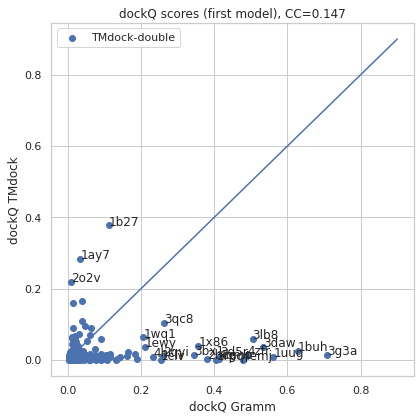

In [56]:
cutoff=0.2
f, ax = plt.subplots(figsize=(6.5, 6.5))
for d in ["TMdock-double"]:
    #if d!="N1-merged":continue   
    #print (d)
    df_merged = pd.merge(data_first["gramm"],data_first[d], on=['code'],how="inner")
    #print (df_merged)
    #newdf=df_merged["dockQ_x","dockQ_y"]  #.loc[(df_merged.dockQ_x>cutoff or df_merged.dockQ_y>cutoff) ]
    #cc=np.corrcoef(df_merged.dockQ_x,df_merged.dockQ_y)
    #print (cc)
    
    
    plt.scatter(df_merged.dockQ_x,df_merged.dockQ_y,label=d)
    for i, txt in enumerate(df_merged.name_x):
        #print (i,txt)
        try: 
            sstr=txt[0:4]
        except:
            sstr=df_merged.name_y[i][0:4]
        if (df_merged.dockQ_x[i]> cutoff or df_merged.dockQ_y[i]>cutoff):
            ax.annotate(sstr, (df_merged.dockQ_x[i], df_merged.dockQ_y[i]))
x=[0,0.9]
y=[0,0.9]
plt.plot(x,y)
ax.legend()
ax.set_title("dockQ scores (first model), CC=" + str(round(cc[0,1],3)) )
ax.set_xlabel("dockQ Gramm")
ax.set_ylabel("dockQ TMdock")

#cat.add_categories([1])
#df_merged.fillna(0, inplace =True)

Text(0, 0.5, 'dockQ TMdock TMdock-double')

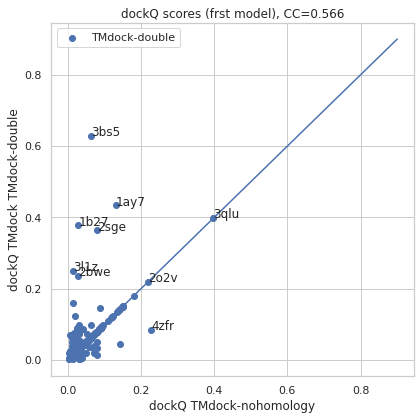

In [57]:
cutoff=0.2
f, ax = plt.subplots(figsize=(6.5, 6.5))
for d in ["TMdock-double"]:
    #if d!="N1-merged":continue   
    #print (d)
    df_merged = pd.merge(data_max["TMdock-nohomology"],data_max[d], on=['code'],how="inner")
    #print (df_merged)
    #newdf=df_merged["dockQ_x","dockQ_y"]  #.loc[(df_merged.dockQ_x>cutoff or df_merged.dockQ_y>cutoff) ]
    cc=np.corrcoef(df_merged.dockQ_x,df_merged.dockQ_y)
    #print (cc)
    
    
    plt.scatter(df_merged.dockQ_x,df_merged.dockQ_y,label=d)
    for i, txt in enumerate(df_merged.name_x):
        #print (i,txt)
        try: 
            sstr=txt[0:4]
        except:
            sstr=df_merged.name_y[i][0:4]
        if (df_merged.dockQ_x[i]> cutoff or df_merged.dockQ_y[i]>cutoff):
            ax.annotate(sstr, (df_merged.dockQ_x[i], df_merged.dockQ_y[i]))
x=[0,0.9]
y=[0,0.9]
plt.plot(x,y)
ax.legend()
ax.set_title("dockQ scores (frst model), CC=" + str(round(cc[0,1],3)) )
ax.set_xlabel("dockQ TMdock-nohomology")
ax.set_ylabel("dockQ TMdock "+d)

#cat.add_categories([1])
#df_merged.fillna(0, inplace =True)

Text(0, 0.5, 'dockQ TMdock trRosetta')

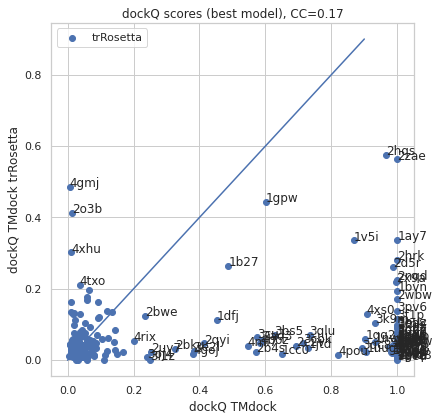

In [58]:
cutoff=0.2
f, ax = plt.subplots(figsize=(6.5, 6.5))
for d in ["trRosetta"]:
    #if d!="N1-merged":continue   
    #print (d)
    df_merged = pd.merge(data_max["TMdock"],data_max[d], on=['code'],how="inner")
    #print (df_merged)
    #newdf=df_merged["dockQ_x","dockQ_y"]  #.loc[(df_merged.dockQ_x>cutoff or df_merged.dockQ_y>cutoff) ]
    cc=np.corrcoef(df_merged.dockQ_x,df_merged.dockQ_y)
    #print (cc)
    
    
    plt.scatter(df_merged.dockQ_x,df_merged.dockQ_y,label=d)
    for i, txt in enumerate(df_merged.name_x):
        #print (i,txt)
        try: 
            sstr=txt[0:4]
        except:
            sstr=df_merged.name_y[i][0:4]
        if (df_merged.dockQ_x[i]> cutoff or df_merged.dockQ_y[i]>cutoff):
            ax.annotate(sstr, (df_merged.dockQ_x[i], df_merged.dockQ_y[i]))
x=[0,0.9]
y=[0,0.9]
plt.plot(x,y)
ax.legend()
ax.set_title("dockQ scores (best model), CC=" + str(round(cc[0,1],3)) )
ax.set_xlabel("dockQ TMdock")
ax.set_ylabel("dockQ TMdock "+d)

#cat.add_categories([1])
#df_merged.fillna(0, inplace =True)

Text(0, 0.5, 'dockQ  pdbconfold')

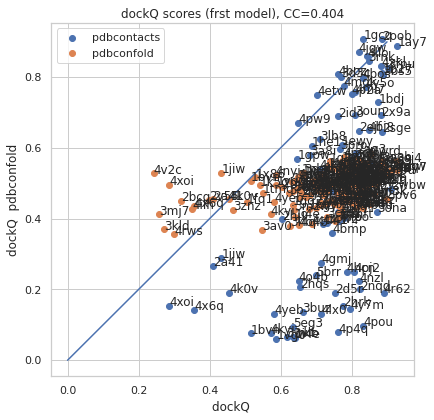

In [59]:
cutoff=0.2
f, ax = plt.subplots(figsize=(6.5, 6.5))
r=re.compile("^PDB|^pdb")
pdbset=list(filter(r.match, datasets))
pdbset=["pdbcontacts","pdbconfold"]

for d in pdbset:
    #if d!="N1-merged":continue   
    #print (d)
    if d=="pdbcontacts-new":continue
    df_merged = pd.merge(data_max["pdbcontacts-new"],data_max[d], on=['code'],how="inner")
    #print (df_merged)
    #newdf=df_merged["dockQ_x","dockQ_y"]  #.loc[(df_merged.dockQ_x>cutoff or df_merged.dockQ_y>cutoff) ]
    cc=np.corrcoef(df_merged.dockQ_x,df_merged.dockQ_y)
    #print (cc)
    
    
    plt.scatter(df_merged.dockQ_x,df_merged.dockQ_y,label=d)
    for i, txt in enumerate(df_merged.name_x):
        #print (i,txt)
        try: 
            sstr=txt[0:4]
        except:
            sstr=df_merged.name_y[i][0:4]
        if (df_merged.dockQ_x[i]> cutoff or df_merged.dockQ_y[i]>cutoff):
            ax.annotate(sstr, (df_merged.dockQ_x[i], df_merged.dockQ_y[i]))
x=[0,0.9]
y=[0,0.9]
plt.plot(x,y)
ax.legend()
ax.set_title("dockQ scores (frst model), CC=" + str(round(cc[0,1],3)) )
ax.set_xlabel("dockQ ")
ax.set_ylabel("dockQ  "+d)

#cat.add_categories([1])
#df_merged.fillna(0, inplace =True)

Text(0, 0.5, 'dockQ  PDBNEWDOCK-repulsion--step1')

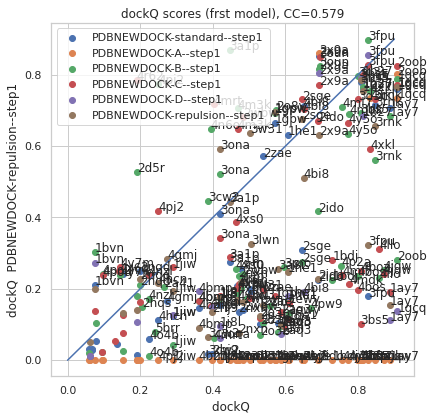

In [60]:
cutoff=0.2
f, ax = plt.subplots(figsize=(6.5, 6.5))
r=re.compile(".*step1.*")
pdbset=list(filter(r.match, datasets))

for d in pdbset:
    #if d!="N1-merged":continue   
    #print (d)
    if d=="pdbcontacts":continue
    df_merged = pd.merge(data_max["pdbcontacts"],data_max[d], on=['code'],how="inner")
    #print (df_merged)
    #newdf=df_merged["dockQ_x","dockQ_y"]  #.loc[(df_merged.dockQ_x>cutoff or df_merged.dockQ_y>cutoff) ]
    cc=np.corrcoef(df_merged.dockQ_x,df_merged.dockQ_y)
    #print (cc)
    
    
    plt.scatter(df_merged.dockQ_x,df_merged.dockQ_y,label=d)
    for i, txt in enumerate(df_merged.name_x):
        #print (i,txt)
        try: 
            sstr=txt[0:4]
        except:
            sstr=df_merged.name_y[i][0:4]
        if (df_merged.dockQ_x[i]> cutoff or df_merged.dockQ_y[i]>cutoff):
            ax.annotate(sstr, (df_merged.dockQ_x[i], df_merged.dockQ_y[i]))
x=[0,0.9]
y=[0,0.9]
plt.plot(x,y)
ax.legend()
ax.set_title("dockQ scores (frst model), CC=" + str(round(cc[0,1],3)) )
ax.set_xlabel("dockQ ")
ax.set_ylabel("dockQ  "+d)

#cat.add_categories([1])
#df_merged.fillna(0, inplace =True)

Text(0, 0.5, 'dockQ  PDB')

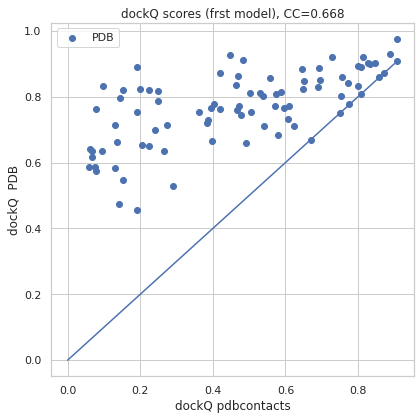

In [61]:
cutoff=0.2
f, ax = plt.subplots(figsize=(6.5, 6.5))
r=re.compile("pdbconfold")
pdbset=list(filter(r.match, datasets))
pdbset=["PDB"]

for d in pdbset:
    #if d!="N1-merged":continue   
    #print (d)
    if d=="pdbcontacts":continue
    df_merged = pd.merge(data_max["pdbcontacts"],data_max[d], on=['code'],how="inner")
    #print (df_merged)
    #newdf=df_merged["dockQ_x","dockQ_y"]  #.loc[(df_merged.dockQ_x>cutoff or df_merged.dockQ_y>cutoff) ]
    cc=np.corrcoef(df_merged.dockQ_x,df_merged.dockQ_y)
    #print (cc)
    
    
    plt.scatter(df_merged.dockQ_x,df_merged.dockQ_y,label=d)
    for i, txt in enumerate(df_merged.name_x):
        #print (i,txt)
        try: 
            sstr=txt[0:4]
        except:
            sstr=df_merged.name_y[i][0:4]
        #if (df_merged.dockQ_y[i]- df_merged.dockQ_x[i]>cutoff):
        #    ax.annotate(sstr, (df_merged.dockQ_x[i], df_merged.dockQ_y[i]))
x=[0,0.9]
y=[0,0.9]
plt.plot(x,y)
ax.legend()
ax.set_title("dockQ scores (frst model), CC=" + str(round(cc[0,1],3)) )
ax.set_xlabel("dockQ pdbcontacts")
ax.set_ylabel("dockQ  "+d)

#cat.add_categories([1])
#df_merged.fillna(0, inplace =True)

Text(0, 0.5, 'dockQ  pdbconfold')

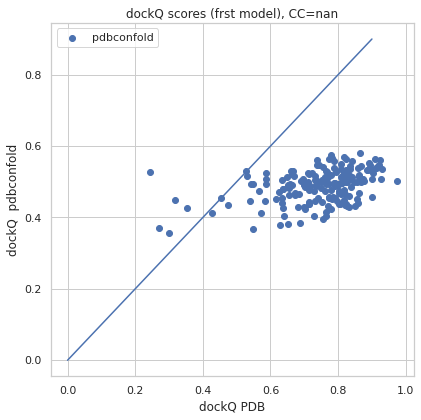

In [62]:
cutoff=0.2
f, ax = plt.subplots(figsize=(6.5, 6.5))
r=re.compile("pdbconfold")
pdbset=list(filter(r.match, datasets))
pdbset=["pdbconfold"]

for d in pdbset:
    #if d!="N1-merged":continue   
    #print (d)
    if d=="pdbcontacts":continue
    df_merged = pd.merge(data_max["PDB"],data_max[d], on=['code'],how="outer")
    #print (df_merged)
    #newdf=df_merged["dockQ_x","dockQ_y"]  #.loc[(df_merged.dockQ_x>cutoff or df_merged.dockQ_y>cutoff) ]
    cc=np.corrcoef(df_merged.dockQ_x,df_merged.dockQ_y)
    #print (cc)
    
    
    plt.scatter(df_merged.dockQ_x,df_merged.dockQ_y,label=d)
    for i, txt in enumerate(df_merged.name_x):
        #print (i,txt)
        try: 
            sstr=txt[0:4]
        except:
            sstr=df_merged.name_y[i][0:4]
        #if (df_merged.dockQ_y[i]- df_merged.dockQ_x[i]>cutoff):
        #    ax.annotate(sstr, (df_merged.dockQ_x[i], df_merged.dockQ_y[i]))
x=[0,0.9]
y=[0,0.9]
plt.plot(x,y)
ax.legend()
ax.set_title("dockQ scores (frst model), CC=" + str(round(cc[0,1],3)) )
ax.set_xlabel("dockQ PDB")
ax.set_ylabel("dockQ  "+d)

#cat.add_categories([1])
#df_merged.fillna(0, inplace =True)

Text(0, 0.5, 'dockQ  PDBNEWDOCK-D')

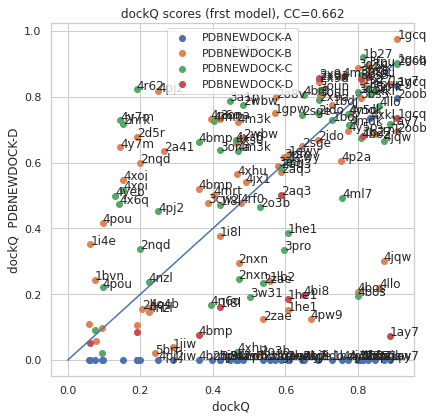

In [63]:
cutoff=0.2
f, ax = plt.subplots(figsize=(6.5, 6.5))
r=re.compile("^PDBNEWDOCK-[ABCD]$")
pdbset=list(filter(r.match, datasets))

for d in pdbset:
    #if d!="N1-merged":continue   
    #print (d)
    if d=="pdbcontacts":continue
    df_merged = pd.merge(data_max["pdbcontacts"],data_max[d], on=['code'],how="inner")
    #print (df_merged)
    #newdf=df_merged["dockQ_x","dockQ_y"]  #.loc[(df_merged.dockQ_x>cutoff or df_merged.dockQ_y>cutoff) ]
    cc=np.corrcoef(df_merged.dockQ_x,df_merged.dockQ_y)
    #print (cc)
    
    
    plt.scatter(df_merged.dockQ_x,df_merged.dockQ_y,label=d)
    for i, txt in enumerate(df_merged.name_x):
        #print (i,txt)
        try: 
            sstr=txt[0:4]
        except:
            sstr=df_merged.name_y[i][0:4]
        if (df_merged.dockQ_x[i]> cutoff or df_merged.dockQ_y[i]>cutoff):
            ax.annotate(sstr, (df_merged.dockQ_x[i], df_merged.dockQ_y[i]))
x=[0,0.9]
y=[0,0.9]
plt.plot(x,y)
ax.legend()
ax.set_title("dockQ scores (frst model), CC=" + str(round(cc[0,1],3)) )
ax.set_xlabel("dockQ ")
ax.set_ylabel("dockQ  "+d)

#cat.add_categories([1])
#df_merged.fillna(0, inplace =True)

Text(0, 0.5, 'dockQ  PDBNEWDOCK-D--dockB-relax')

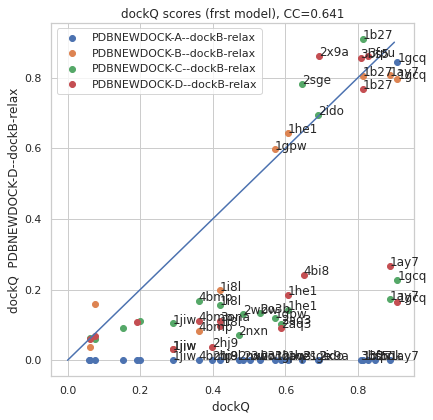

In [64]:
cutoff=0.2
f, ax = plt.subplots(figsize=(6.5, 6.5))
r=re.compile(".*dockB-relax.*")
pdbset=list(filter(r.match, datasets))

for d in pdbset:
    #if d!="N1-merged":continue   
    #print (d)
    if d=="pdbcontacts":continue
    df_merged = pd.merge(data_max["pdbcontacts"],data_max[d], on=['code'],how="inner")
    #print (df_merged)
    #newdf=df_merged["dockQ_x","dockQ_y"]  #.loc[(df_merged.dockQ_x>cutoff or df_merged.dockQ_y>cutoff) ]
    cc=np.corrcoef(df_merged.dockQ_x,df_merged.dockQ_y)
    #print (cc)
    
    
    plt.scatter(df_merged.dockQ_x,df_merged.dockQ_y,label=d)
    for i, txt in enumerate(df_merged.name_x):
        #print (i,txt)
        try: 
            sstr=txt[0:4]
        except:
            sstr=df_merged.name_y[i][0:4]
        if (df_merged.dockQ_x[i]> cutoff or df_merged.dockQ_y[i]>cutoff):
            ax.annotate(sstr, (df_merged.dockQ_x[i], df_merged.dockQ_y[i]))
x=[0,0.9]
y=[0,0.9]
plt.plot(x,y)
ax.legend()
ax.set_title("dockQ scores (frst model), CC=" + str(round(cc[0,1],3)) )
ax.set_xlabel("dockQ ")
ax.set_ylabel("dockQ  "+d)

#cat.add_categories([1])
#df_merged.fillna(0, inplace =True)

Text(0, 0.5, 'dockQ  PDBNEWDOCK-D--dockC-relax')

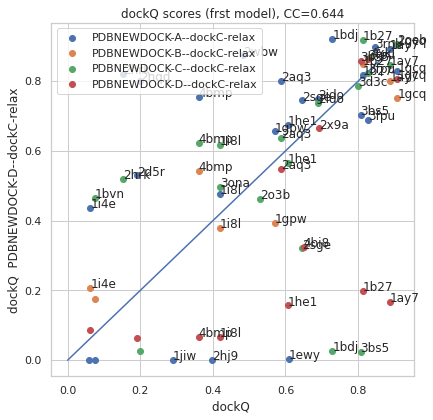

In [65]:
cutoff=0.2
f, ax = plt.subplots(figsize=(6.5, 6.5))
r=re.compile(".*dockC-relax.*")
pdbset=list(filter(r.match, datasets))

for d in pdbset:
    #if d!="N1-merged":continue   
    #print (d)
    if d=="pdbcontacts":continue
    df_merged = pd.merge(data_max["pdbcontacts"],data_max[d], on=['code'],how="inner")
    #print (df_merged)
    #newdf=df_merged["dockQ_x","dockQ_y"]  #.loc[(df_merged.dockQ_x>cutoff or df_merged.dockQ_y>cutoff) ]
    cc=np.corrcoef(df_merged.dockQ_x,df_merged.dockQ_y)
    #print (cc)
    
    
    plt.scatter(df_merged.dockQ_x,df_merged.dockQ_y,label=d)
    for i, txt in enumerate(df_merged.name_x):
        #print (i,txt)
        try: 
            sstr=txt[0:4]
        except:
            sstr=df_merged.name_y[i][0:4]
        if (df_merged.dockQ_x[i]> cutoff or df_merged.dockQ_y[i]>cutoff):
            ax.annotate(sstr, (df_merged.dockQ_x[i], df_merged.dockQ_y[i]))
x=[0,0.9]
y=[0,0.9]
plt.plot(x,y)
ax.legend()
ax.set_title("dockQ scores (frst model), CC=" + str(round(cc[0,1],3)) )
ax.set_xlabel("dockQ ")
ax.set_ylabel("dockQ  "+d)

#cat.add_categories([1])
#df_merged.fillna(0, inplace =True)

Text(0, 0.5, 'dockQ  PDBNEWDOCK-D--dockD-relax')

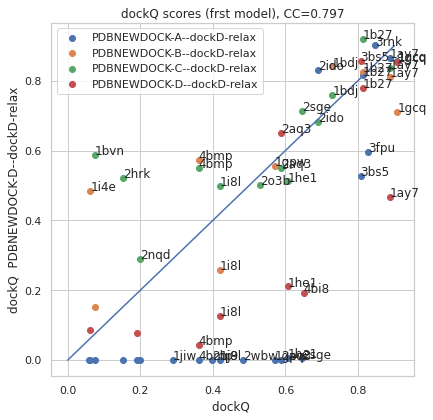

In [66]:
cutoff=0.2
f, ax = plt.subplots(figsize=(6.5, 6.5))
r=re.compile(".*dockD-relax.*")
pdbset=list(filter(r.match, datasets))

for d in pdbset:
    #if d!="N1-merged":continue   
    #print (d)
    if d=="pdbcontacts":continue
    df_merged = pd.merge(data_max["pdbcontacts"],data_max[d], on=['code'],how="inner")
    #print (df_merged)
    #newdf=df_merged["dockQ_x","dockQ_y"]  #.loc[(df_merged.dockQ_x>cutoff or df_merged.dockQ_y>cutoff) ]
    cc=np.corrcoef(df_merged.dockQ_x,df_merged.dockQ_y)
    #print (cc)
    
    
    plt.scatter(df_merged.dockQ_x,df_merged.dockQ_y,label=d)
    for i, txt in enumerate(df_merged.name_x):
        #print (i,txt)
        try: 
            sstr=txt[0:4]
        except:
            sstr=df_merged.name_y[i][0:4]
        if (df_merged.dockQ_x[i]> cutoff or df_merged.dockQ_y[i]>cutoff):
            ax.annotate(sstr, (df_merged.dockQ_x[i], df_merged.dockQ_y[i]))
x=[0,0.9]
y=[0,0.9]
plt.plot(x,y)
ax.legend()
ax.set_title("dockQ scores (frst model), CC=" + str(round(cc[0,1],3)) )
ax.set_xlabel("dockQ ")
ax.set_ylabel("dockQ  "+d)

#cat.add_categories([1])
#df_merged.fillna(0, inplace =True)

Text(0, 0.5, 'dockQ  PDBNEWDOCK-C')

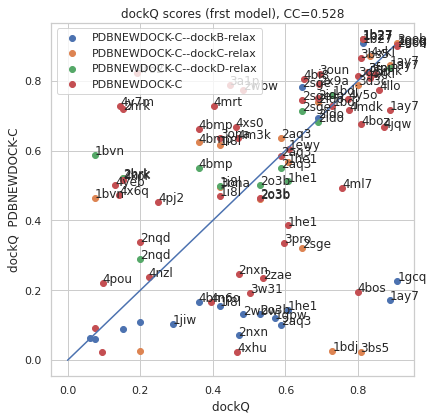

In [67]:
cutoff=0.2
f, ax = plt.subplots(figsize=(6.5, 6.5))
r=re.compile("^PDBNEWDOCK-C.*-relax.*")
pdbset=list(filter(r.match, datasets))+["PDBNEWDOCK-C"]

for d in pdbset:
    #if d!="N1-merged":continue   
    #print (d)
    if d=="pdbcontacts":continue
    df_merged = pd.merge(data_max["pdbcontacts"],data_max[d], on=['code'],how="inner")
    #print (df_merged)
    #newdf=df_merged["dockQ_x","dockQ_y"]  #.loc[(df_merged.dockQ_x>cutoff or df_merged.dockQ_y>cutoff) ]
    cc=np.corrcoef(df_merged.dockQ_x,df_merged.dockQ_y)
    #print (cc)
    
    
    plt.scatter(df_merged.dockQ_x,df_merged.dockQ_y,label=d)
    for i, txt in enumerate(df_merged.name_x):
        #print (i,txt)
        try: 
            sstr=txt[0:4]
        except:
            sstr=df_merged.name_y[i][0:4]
        if (df_merged.dockQ_x[i]> cutoff or df_merged.dockQ_y[i]>cutoff):
            ax.annotate(sstr, (df_merged.dockQ_x[i], df_merged.dockQ_y[i]))
x=[0,0.9]
y=[0,0.9]
plt.plot(x,y)
ax.legend()
ax.set_title("dockQ scores (frst model), CC=" + str(round(cc[0,1],3)) )
ax.set_xlabel("dockQ ")
ax.set_ylabel("dockQ  "+d)

#cat.add_categories([1])
#df_merged.fillna(0, inplace =True)

Text(0, 0.5, 'dockQ  PDBNEWDOCK-C--dockD-relax')

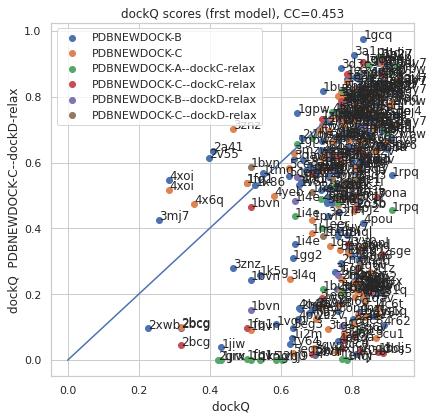

In [68]:
cutoff=0.2
f, ax = plt.subplots(figsize=(6.5, 6.5))
r=re.compile("^PDBNEWDOCK-C.*-relax.*")
pdbset=list(filter(r.match, datasets))+["PDBNEWDOCK-C"]
pdbset=["PDBNEWDOCK-B","PDBNEWDOCK-C","PDBNEWDOCK-A--dockC-relax",
        "PDBNEWDOCK-C--dockC-relax","PDBNEWDOCK-B--dockD-relax",
        "PDBNEWDOCK-C--dockD-relax"]

for d in pdbset:
    #if d!="N1-merged":continue   
    #print (d)
    if d=="pdbcontacts-new":continue
    df_merged = pd.merge(data_max["pdbcontacts-new"],data_max[d], on=['code'],how="inner")
    #print (df_merged)
    #newdf=df_merged["dockQ_x","dockQ_y"]  #.loc[(df_merged.dockQ_x>cutoff or df_merged.dockQ_y>cutoff) ]
    cc=np.corrcoef(df_merged.dockQ_x,df_merged.dockQ_y)
    #print (cc)
    
    
    plt.scatter(df_merged.dockQ_x,df_merged.dockQ_y,label=d)
    for i, txt in enumerate(df_merged.name_x):
        #print (i,txt)
        try: 
            sstr=txt[0:4]
        except:
            sstr=df_merged.name_y[i][0:4]
        if (df_merged.dockQ_x[i]> cutoff or df_merged.dockQ_y[i]>cutoff):
            ax.annotate(sstr, (df_merged.dockQ_x[i], df_merged.dockQ_y[i]))
x=[0,0.9]
y=[0,0.9]
plt.plot(x,y)
ax.legend()
ax.set_title("dockQ scores (frst model), CC=" + str(round(cc[0,1],3)) )
ax.set_xlabel("dockQ ")
ax.set_ylabel("dockQ  "+d)

#cat.add_categories([1])
#df_merged.fillna(0, inplace =True)

Text(0, 0.5, 'dockQ  pdbconfold')

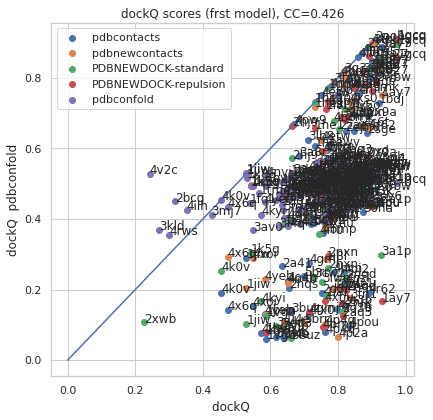

In [69]:
cutoff=0.2
f, ax = plt.subplots(figsize=(6.5, 6.5))
r=re.compile("^PDBNEWDOCK-C.*-relax.*")
pdbset=list(filter(r.match, datasets))+["PDBNEWDOCK-C"]
pdbset=["pdbcontacts","pdbnewcontacts","PDBNEWDOCK-standard","PDBNEWDOCK-repulsion","pdbconfold"]

for d in pdbset:
    #if d!="N1-merged":continue   
    #print (d)
    #if d=="pdbcontacts":continue
    df_merged = pd.merge(data_max["PDB"],data_max[d], on=['code'],how="inner")
    #print (df_merged)
    #newdf=df_merged["dockQ_x","dockQ_y"]  #.loc[(df_merged.dockQ_x>cutoff or df_merged.dockQ_y>cutoff) ]
    cc=np.corrcoef(df_merged.dockQ_x,df_merged.dockQ_y)
    #print (cc)
    
    
    plt.scatter(df_merged.dockQ_x,df_merged.dockQ_y,label=d)
    for i, txt in enumerate(df_merged.name_x):
        #print (i,txt)
        try: 
            sstr=txt[0:4]
        except:
            sstr=df_merged.name_y[i][0:4]
        if (df_merged.dockQ_x[i]> cutoff or df_merged.dockQ_y[i]>cutoff):
            ax.annotate(sstr, (df_merged.dockQ_x[i], df_merged.dockQ_y[i]))
x=[0,0.9]
y=[0,0.9]
plt.plot(x,y)
ax.legend()
ax.set_title("dockQ scores (frst model), CC=" + str(round(cc[0,1],3)) )
ax.set_xlabel("dockQ ")
ax.set_ylabel("dockQ  "+d)

#cat.add_categories([1])
#df_merged.fillna(0, inplace =True)

In [70]:
r=re.compile(".*relax.*")
#pdbset=list(filter(r.match, datasets))+['PDBNEWDOCK-A','PDBNEWDOCK-B', 'PDBNEWDOCK-C', 'PDBNEWDOCK-D',"pdbcontacts"]
pdbset=sorted(["PDB","PDBNEWDOCK-B","PDBNEWDOCK-C","PDBNEWDOCK-A--dockC-relax",
        "PDBNEWDOCK-C--dockC-relax","PDBNEWDOCK-B--dockD-relax",
        "PDBNEWDOCK-C--dockD-relax","pdbcontacts","pdbnewcontacts","PDBNEWDOCK-standard",
               "PDBNEWDOCK-repulsion","pdbconfold"])


smallset=["1ay7", "1b27", "1bvn", "1gcq", "1gpw", "1he1", "1i4e", "1i8l",
"1jiw", "1k5g", "1nql", "1vg0", "2aq3", "2b4s", "2d5r", "2grx",
"2hj9", "2hrk", "2ido", "2nqd", "2nxn", "2o3b", "2sge", "2wbw",
"2x9a", "2xwb", "2zae", "3a1p", "3a8i", "3bs5", "3buz", "3cw2",
"3cw2", "3fpu", "3lwn", "3ona", "3rnk", "3vlb", "3w31", "3wkt",
"4bi8", "4bmp", "4gmj", "4hcn", "4k0v", "4kyi", "4o4b", "4rf0",
"4xhu", "4yoc"]
codes=df_max.loc[df_max.params.isin(pdbset)]["CODE"].unique()
codes=smallset
codes=df_max.loc[(df_max.params=="PDBNEWDOCK-A--dockC-relax")&(df_max.params.isin(pdbset) )]["CODE"].unique()
codes=df_max.loc[(df_max.params=="PDBNEWDOCK-C")&(df_max.params.isin(pdbset) )]["CODE"].unique()

codes=smallset

In [71]:
cutoff=0.2
newdf=df_max.loc[df_max.dockQ>cutoff]
newdf=newdf.reset_index()

PDB
PDBNEWDOCK-A--dockC-relax
PDBNEWDOCK-B
PDBNEWDOCK-B--dockD-relax
PDBNEWDOCK-C
PDBNEWDOCK-C--dockC-relax
PDBNEWDOCK-C--dockD-relax
PDBNEWDOCK-repulsion
PDBNEWDOCK-standard
pdbconfold
pdbcontacts
pdbnewcontacts


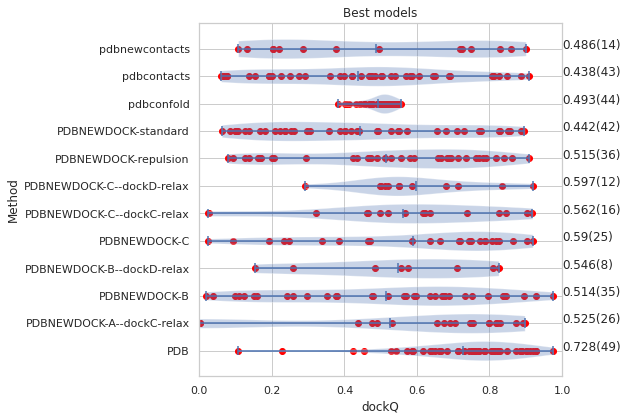

In [72]:
# FInd best method for each model.
#codes=df_max.loc[df_max.params.isin(pdbset)]["CODE"].unique()
f, ax = plt.subplots(figsize=(6.5, 6.5))
tempdf=newdf.loc[newdf.JHparams.isin(pdbset)]

#best_df=newdf.sort_values("dockQ", ascending=False)
best_df=tempdf.sort_values('dockQ', ascending=False).drop_duplicates(['code']).reset_index()
best_df.sort_values("JHparams")

good_df=newdf.loc[(newdf.code.isin(codes))&(newdf.JHparams.isin(pdbset))].reset_index()
#plt.scatter(good_df.dockQ,good_df.JHparams,color="grey")
#plt.scatter(best_df.dockQ,best_df.JHparams,color="red")


all_df=df_max.loc[(df_max.CODE.isin(codes))&(df_max.params.isin(pdbset))].reset_index()
plt.scatter(all_df.dockQ,all_df.JHparams,color="red")

#cc=np.corrcoef(newdf.dockQ,newdf.len)
#ax.legend()
ax.set_title("Best models")
ax.set_ylabel("Method")
ax.set_xlabel("dockQ")
ax.set(xlim=[0,1])
done={}
average={}
length={}
pos=[]
i=0
data=[]
for d in sorted(pdbset):
    done[d]=0
    average[d]=df_max.loc[df_max.CODE.isin(codes)&(df_max.params==d)]["dockQ"].mean()
    length[d]=len(df_max.loc[df_max.CODE.isin(codes)&(df_max.params==d)]["dockQ"])
    pos+=[i]
    data+=[df_max.loc[df_max.CODE.isin(codes)&(df_max.params==d)]["dockQ"]]
    i+=1
    print (d)
    
    
ax.violinplot(data,pos, points=80, vert=False, widths=0.7,
                      showmeans=True, showextrema=True, showmedians=False)    
for i, txt in enumerate(all_df.name):
    #print (i,txt)
    sstr=txt[0:4]
    #ax.annotate(sstr, (newdf.dockQ[i], newdf.JHparams[i]))
    #numhit=len(best_df.loc[best_df.JHparams==best_df.JHparams[i]])
    #print (numhit,newdf.JHparams[i])
    if done[all_df.JHparams[i]]==0:
        done[all_df.JHparams[i]]=1
        #ax.annotate(str(numhit),(.0, best_df.JHparams[i]))
        ax.annotate(str(round(average[all_df.JHparams[i]],3))+"("+str(length[all_df.JHparams[i]])+")"
                    ,(1.0, all_df.JHparams[i]))


In [73]:
datasets

array(['-N 3 --cpu 8', 'confold', 'gramm', 'homodimer', 'ispred',
       '-N 1 -E 1.e-100 --cpu 8', '-N 1 -E 1.e-2 ', 'N1-merged-pdb',
       'N1-merged', 'N1-N3-merged-fast', 'N1-N3-new', 'N1-N3-multimerged',
       '-N 1 -E 1.e-10 --cpu 8 ', 'N1-top1000-merged', 'N1-top1000',
       'N1-top100', 'N1-top2000', 'N1-top500', 'N3dock',
       '-N 3 --incE 1.e-2', 'N3-merged', 'N3-multimerged', 'N3-newdockA',
       'N3-newdockB', 'N3-newdockC', 'N5-newdockA', 'N5-newdockB',
       'N5-newdockC', '-N 5 --cpu 8', 'pdbconfold', 'pdbcontacts-new',
       'pdbcontacts', 'PDBDOCK2', 'PDBDOCK3', 'PDBDOCK4', 'PDBDOCK',
       'PDBNEWDOCK-standard', 'PDBNEWDOCK-standard--starting',
       'PDBNEWDOCK-standard--step1', 'pdbnewcontacts', 'PDBNEWDOCK-A',
       'PDBNEWDOCK-A--dockB1', 'PDBNEWDOCK-A--dockB2',
       'PDBNEWDOCK-A--dockB-relax', 'PDBNEWDOCK-A--dockC1',
       'PDBNEWDOCK-A--dockC2', 'PDBNEWDOCK-A--dockC-relax',
       'PDBNEWDOCK-A--dockD1', 'PDBNEWDOCK-A--dockD2',
       'PDBNEWDOCK-

In [74]:
pdbset=[ 'N3dock',
       'N3-newdockA', 'N3-newdockB', 'N3-newdockC', 'N5-newdockA','N5-newdockB',
       'N5-newdockC', '-N 5 --cpu 8',"-N 3 --cpu 8"]
codes=df_max.loc[(df_max.params=="N3-newdockC")&(df_max.params.isin(pdbset) )]["CODE"].unique()
codes

array(['1ay7', '1b27', '1bvn', '1gcq', '1gpw', '1he1', '1i4e', '1i8l',
       '1jiw', '1k5g', '1nql', '1vg0', '2aq3', '2b4s', '2d5r', '2hj9',
       '2hrk', '2ido', '2nqd', '2nxn', '2o3b', '2sge', '2wbw', '2x9a',
       '2zae', '3a1p', '3a8i', '3bs5', '3cw2', '3fpu', '3lwn', '3ona',
       '3rnk', '3w31', '4bi8', '4bmp', '4gmj', '4hcn', '4xhu'],
      dtype=object)

Text(0, 0.5, 'dockQ  -N 3 --cpu 8')

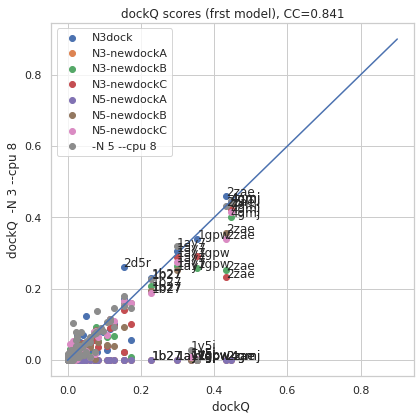

In [75]:
cutoff=0.2
f, ax = plt.subplots(figsize=(6.5, 6.5))

for d in pdbset:
    #if d!="N1-merged":continue   
    #print (d)
    if d=="-N 3 --cpu 8":continue
    df_merged = pd.merge(data_max["-N 3 --cpu 8"],data_max[d], on=['code'],how="inner")
    #print (df_merged)
    #newdf=df_merged["dockQ_x","dockQ_y"]  #.loc[(df_merged.dockQ_x>cutoff or df_merged.dockQ_y>cutoff) ]
    cc=np.corrcoef(df_merged.dockQ_x,df_merged.dockQ_y)
    #print (cc)
    
    
    plt.scatter(df_merged.dockQ_x,df_merged.dockQ_y,label=d)
    for i, txt in enumerate(df_merged.name_x):
        #print (i,txt)
        try: 
            sstr=txt[0:4]
        except:
            sstr=df_merged.name_y[i][0:4]
        if (df_merged.dockQ_x[i]> cutoff or df_merged.dockQ_y[i]>cutoff):
            ax.annotate(sstr, (df_merged.dockQ_x[i], df_merged.dockQ_y[i]))
x=[0,0.9]
y=[0,0.9]
plt.plot(x,y)
ax.legend()
ax.set_title("dockQ scores (frst model), CC=" + str(round(cc[0,1],3)) )
ax.set_xlabel("dockQ ")
ax.set_ylabel("dockQ  "+d)

#cat.add_categories([1])
#df_merged.fillna(0, inplace =True)

-N 3 --cpu 8 39
-N 5 --cpu 8 39
N3-newdockA 39
N3-newdockB 38
N3-newdockC 39
N3dock 39
N5-newdockA 39
N5-newdockB 39
N5-newdockC 39


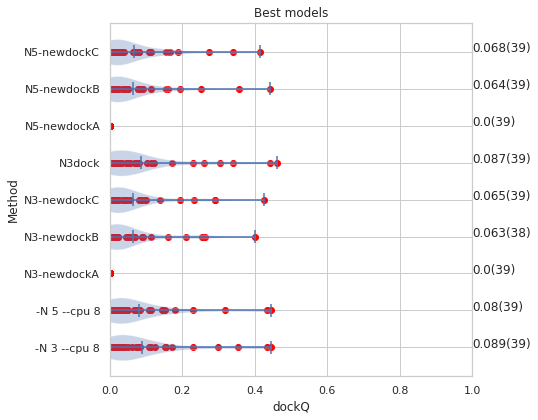

In [76]:
# FInd best method for each model.
#codes=df_max.loc[df_max.params.isin(pdbset)]["CODE"].unique()
f, ax = plt.subplots(figsize=(6.5, 6.5))
tempdf=newdf.loc[newdf.JHparams.isin(pdbset)]

#best_df=newdf.sort_values("dockQ", ascending=False)
best_df=tempdf.sort_values('dockQ', ascending=False).drop_duplicates(['code']).reset_index()
best_df.sort_values("JHparams")

good_df=newdf.loc[(newdf.code.isin(codes))&(newdf.JHparams.isin(pdbset))].reset_index()
#plt.scatter(good_df.dockQ,good_df.JHparams,color="grey")
#plt.scatter(best_df.dockQ,best_df.JHparams,color="red")


all_df=df_max.loc[(df_max.CODE.isin(codes))&(df_max.params.isin(pdbset))].reset_index()
plt.scatter(all_df.dockQ,all_df.JHparams,color="red")

#cc=np.corrcoef(newdf.dockQ,newdf.len)
#ax.legend()
ax.set_title("Best models")
ax.set_ylabel("Method")
ax.set_xlabel("dockQ")
ax.set(xlim=[0,1])
done={}
average={}
length={}
pos=[]
i=0
data=[]
for d in sorted(pdbset):
    done[d]=0
    average[d]=df_max.loc[df_max.CODE.isin(codes)&(df_max.params==d)]["dockQ"].mean()
    length[d]=len(df_max.loc[df_max.CODE.isin(codes)&(df_max.params==d)]["dockQ"])
    pos+=[i]
    data+=[df_max.loc[df_max.CODE.isin(codes)&(df_max.params==d)]["dockQ"]]
    print (d,len(data[i]))
    i+=1
    
    
ax.violinplot(data,pos, points=80, vert=False, widths=0.7,
                      showmeans=True, showextrema=True, showmedians=False)    
for i, txt in enumerate(all_df.name):
    #print (i,txt)
    sstr=txt[0:4]
    #ax.annotate(sstr, (newdf.dockQ[i], newdf.JHparams[i]))
    #numhit=len(best_df.loc[best_df.JHparams==best_df.JHparams[i]])
    #print (numhit,newdf.JHparams[i])
    if done[all_df.JHparams[i]]==0:
        done[all_df.JHparams[i]]=1
        #ax.annotate(str(numhit),(.0, best_df.JHparams[i]))
        ax.annotate(str(round(average[all_df.JHparams[i]],3))+"("+str(length[all_df.JHparams[i]])+")"
                    ,(1.0, all_df.JHparams[i]))


In [77]:
pdbset=sorted(["N1","N3"])

In [78]:
for d in pdbset:
    print (d,len(df_max.loc[(df_max.params==d)]["CODE"].unique()))

N1 0
N3 0


In [79]:
all_df

JHparams  code                 name  lenA  lenB     msa     msaA  \
0    -N 3 --cpu 8  1ay7  1ay7_u2_A-1ay7_u1_A    97    97  1060.0   2034.0   
1    -N 3 --cpu 8  1b27  1b27_u2_A-1b27_u1_A   109   109   733.0   2034.0   
2    -N 3 --cpu 8  1bvn  1bvn_u2_A-1bvn_u1_A   496   496    95.0  52623.0   
3    -N 3 --cpu 8  1gcq  1gcq_u2_A-1gcq_u1_A    66    66  1365.0  77704.0   
4    -N 3 --cpu 8  1gpw  1gpw_u2_A-1gpw_u1_A   252   252  7137.0  67629.0   
..            ...   ...                  ...   ...   ...     ...      ...   
345   N5-newdockC  4bi8  4bi8_u1_A-4bi8_u2_A   164    94    51.0    291.0   
346   N5-newdockC  4bmp  4bmp_u1_A-4bmp_u2_A   301   118  4607.0   9429.0   
347   N5-newdockC  4gmj  4gmj_u2_A-4gmj_u1_A   253   253  1189.0   6344.0   
348   N5-newdockC  4hcn  4hcn_u1_A-4hcn_u2_A   250    77     1.0     20.0   
349   N5-newdockC  4xhu  4xhu_u2_A-4xhu_u1_A   352   352   410.0   9970.0   

        msaB  cdhit  dockQ  ...  CODE        params      tmAB    msaAB  \
0     2034.0   1026  0.298  ...  1ay7  -N 3 --cpu 8  0.828190   1759.5   
1     2034.0    656  0.229  ...  1b27  -N 3 --cpu 8  0.824750   1759.0   
2    52623.0     85  0.013  ...  1bvn  -N 3 --cpu 8  0.619740  26373.0   
3    77704.0    771  0.115  ...  1gcq  -N 3 --cpu 8  0.555390  77600.5   
4    67629.0   5348  0.354  ...  1gpw  -N 3 --cpu 8  0.889770  63047.5   
..       ...    ...    ...  ...   ...           ...       ...      ...   
345    382.0     50  0.026  ...  4bi8   N5-newdockC  0.695005    336.5   
346  15729.0   2901  0.004  ...  4bmp   N5-newdockC  0.811060  12579.0   
347   6344.0    546  0.414  ...  4gmj   N5-newdockC  0.831935   3998.5   
348  41925.0      1  0.014  ...  4hcn   N5-newdockC  0.467315  20972.5   
349   9970.0    240  0.007  ...  4xhu   N5-newdockC  0.730560   5259.0   

     tmAB_max  msaAB_max  tmAB_min  msaAB_min  numcorrect  len  
0     0.84625     2034.0   0.81013     1485.0      53.985  187  
1     0.85428     2034.0   0.79522     1484.0      49.025  199  
2     0.70905    52623.0   0.53043      123.0       0.000  571  
3     0.63426    77704.0   0.52080    77497.0      71.760  123  
4     0.89718    67629.0   0.88236    58466.0     130.000  456  
..        ...        ...       ...        ...         ...  ...  
345   0.78100      382.0   0.60901      291.0       0.000  258  
346   0.86858    15729.0   0.75354     9429.0       0.000  419  
347   0.85148     6344.0   0.82721     1653.0     139.104  489  
348   0.61756    41925.0   0.31707       20.0       0.000  327  
349   0.75557     9970.0   0.70555      548.0       0.000  447  

[350 rows x 53 columns]

In [80]:
cutoff=0.2
newdf=df_max.loc[df_max.dockQ>cutoff]
newdf=newdf.reset_index()


In [81]:
datasets

array(['-N 3 --cpu 8', 'confold', 'gramm', 'homodimer', 'ispred',
       '-N 1 -E 1.e-100 --cpu 8', '-N 1 -E 1.e-2 ', 'N1-merged-pdb',
       'N1-merged', 'N1-N3-merged-fast', 'N1-N3-new', 'N1-N3-multimerged',
       '-N 1 -E 1.e-10 --cpu 8 ', 'N1-top1000-merged', 'N1-top1000',
       'N1-top100', 'N1-top2000', 'N1-top500', 'N3dock',
       '-N 3 --incE 1.e-2', 'N3-merged', 'N3-multimerged', 'N3-newdockA',
       'N3-newdockB', 'N3-newdockC', 'N5-newdockA', 'N5-newdockB',
       'N5-newdockC', '-N 5 --cpu 8', 'pdbconfold', 'pdbcontacts-new',
       'pdbcontacts', 'PDBDOCK2', 'PDBDOCK3', 'PDBDOCK4', 'PDBDOCK',
       'PDBNEWDOCK-standard', 'PDBNEWDOCK-standard--starting',
       'PDBNEWDOCK-standard--step1', 'pdbnewcontacts', 'PDBNEWDOCK-A',
       'PDBNEWDOCK-A--dockB1', 'PDBNEWDOCK-A--dockB2',
       'PDBNEWDOCK-A--dockB-relax', 'PDBNEWDOCK-A--dockC1',
       'PDBNEWDOCK-A--dockC2', 'PDBNEWDOCK-A--dockC-relax',
       'PDBNEWDOCK-A--dockD1', 'PDBNEWDOCK-A--dockD2',
       'PDBNEWDOCK-

In [82]:
r=re.compile(".*relax.*")
pdbset=list(filter(r.match, datasets))+['PDBNEWDOCK-A','PDBNEWDOCK-B', 'PDBNEWDOCK-C', 'PDBNEWDOCK-D',"pdbcontacts","pdbconfold","PDB"]


smallset=["1ay7", "1b27", "1bvn", "1gcq", "1gpw", "1he1", "1i4e", "1i8l",
"1jiw", "1k5g", "1nql", "1vg0", "2aq3", "2b4s", "2d5r", "2grx",
"2hj9", "2hrk", "2ido", "2nqd", "2nxn", "2o3b", "2sge", "2wbw",
"2x9a", "2xwb", "2zae", "3a1p", "3a8i", "3bs5", "3buz", "3cw2",
"3cw2", "3fpu", "3lwn", "3ona", "3rnk", "3vlb", "3w31", "3wkt",
"4bi8", "4bmp", "4gmj", "4hcn", "4k0v", "4kyi", "4o4b", "4rf0",
"4xhu", "4yoc"]
codes=df_max.loc[df_max.params.isin(pdbset)]["CODE"].unique()
codes=smallset
codes=df_max.loc[(df_max.params=="PDBNEWDOCK-A")&(df_max.params.isin(pdbset) )]["CODE"].unique()


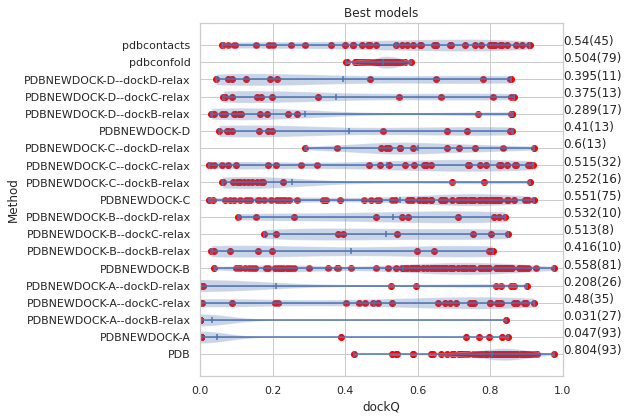

In [83]:
# FInd best method for each model.
#codes=df_max.loc[df_max.params.isin(pdbset)]["CODE"].unique()
f, ax = plt.subplots(figsize=(6.5, 6.5))
tempdf=newdf.loc[newdf.JHparams.isin(pdbset)]

#best_df=newdf.sort_values("dockQ", ascending=False)
best_df=tempdf.sort_values('dockQ', ascending=False).drop_duplicates(['code']).reset_index()
best_df.sort_values("JHparams")

good_df=newdf.loc[(newdf.code.isin(codes))&(newdf.JHparams.isin(pdbset))].reset_index()
#plt.scatter(good_df.dockQ,good_df.JHparams,color="grey")
#plt.scatter(best_df.dockQ,best_df.JHparams,color="red")


all_df=df_max.loc[(df_max.CODE.isin(codes))&(df_max.params.isin(pdbset))].reset_index()
plt.scatter(all_df.dockQ,all_df.JHparams,color="red")

#cc=np.corrcoef(newdf.dockQ,newdf.len)
#ax.legend()
ax.set_title("Best models")
ax.set_ylabel("Method")
ax.set_xlabel("dockQ")
ax.set(xlim=[0,1])
done={}
average={}
length={}
pos=[]
i=0
data=[]
for d in sorted(pdbset):
    done[d]=0
    average[d]=df_max.loc[df_max.CODE.isin(codes)&(df_max.params==d)]["dockQ"].mean()
    length[d]=len(df_max.loc[df_max.CODE.isin(codes)&(df_max.params==d)]["dockQ"])
    pos+=[i]
    data+=[df_max.loc[df_max.CODE.isin(codes)&(df_max.params==d)]["dockQ"]]
    i+=1
    #print (d)
    
    
ax.violinplot(data,pos, points=80, vert=False, widths=0.7,
                      showmeans=True, showextrema=True, showmedians=False)    
for i, txt in enumerate(all_df.name):
    #print (i,txt)
    sstr=txt[0:4]
    #ax.annotate(sstr, (newdf.dockQ[i], newdf.JHparams[i]))
    #numhit=len(best_df.loc[best_df.JHparams==best_df.JHparams[i]])
    #print (numhit,newdf.JHparams[i])
    if done[all_df.JHparams[i]]==0:
        done[all_df.JHparams[i]]=1
        #ax.annotate(str(numhit),(.0, best_df.JHparams[i]))
        ax.annotate(str(round(average[all_df.JHparams[i]],3))+"("+str(length[all_df.JHparams[i]])+")"
                    ,(1.0, all_df.JHparams[i]))


In [84]:
codes

array(['1ay7', '1b27', '1bdj', '1buh', '1bvn', '1cc0', '1eay', '1eer',
       '1ewy', '1fle', '1fq1', '1g6v', '1g73', '1gcq', '1gpw', '1he1',
       '1i4e', '1i8l', '1jiw', '1k5g', '1kgy', '1lb2', '1lfd', '1nql',
       '1qav', '1rpq', '1vg0', '1vrs', '1wrd', '1xt9', '1y8x', '1z5y',
       '2aq3', '2b4s', '2bwe', '2c2v', '2d5r', '2ejf', '2g45', '2grx',
       '2gwf', '2hj9', '2hrk', '2i25', '2ido', '2iwt', '2nqd', '2o25',
       '2o2v', '2oob', '2qyi', '2sge', '2wbw', '2wy7', '2wy8', '2x9a',
       '2xgy', '2zae', '3a1p', '3bs5', '3cu1', '3d3c', '3f1p', '3fap',
       '3fn1', '3fpu', '3g3a', '3k1i', '3l1z', '3oj4', '3ona', '3onl',
       '3qc8', '3rj3', '3rnk', '4bi8', '4bmp', '4bos', '4boz', '4c6t',
       '4jqw', '4m3k', '4ml7', '4pj2', '4pou', '4r62', '4txo', '4xkl',
       '4xs0', '4y5o', '4zfr', '5cra', '5eg3'], dtype=object)

In [85]:
all_df

JHparams  code                           name  lenA  lenB     msa  \
0            PDB  1ay7  1ay7_u2_A-1ay7_u1_A.pdb-step1    97    97  1060.0   
1            PDB  1b27  1b27_u2_A-1b27_u1_A.pdb-step1   109   109   733.0   
2            PDB  1bdj  1bdj_u2_A-1bdj_u1_A.pdb-step1   129   129  5651.0   
3            PDB  1buh  1buh_u2_A-1buh_u1_A.pdb-step1   291   291     0.0   
4            PDB  1bvn            1bvn_u2_A-1bvn_u1_A   496   496    95.0   
..           ...   ...                            ...   ...   ...     ...   
692  pdbcontacts  4r62            4r62_u2_A-4r62_u1_A    77   154  1399.0   
693  pdbcontacts  4xkl            4xkl_u2_A-4xkl_u1_A    34    76   227.0   
694  pdbcontacts  4xs0            4xs0_u2_A-4xs0_u1_A   141   147  3324.0   
695  pdbcontacts  4y5o            4y5o_u2_A-4y5o_u1_A    85    94   357.0   
696  pdbcontacts  5eg3            5eg3_u1_A-5eg3_u2_A   303   105   421.0   

         msaA      msaB  cdhit  dockQ  ...  CODE       params      tmAB  \
0      1485.0    2034.0    986  0.929  ...  1ay7          PDB  0.998225   
1      1484.0    2034.0    654  0.919  ...  1b27          PDB  0.998015   
2    349880.0  349880.0   5080  0.921  ...  1bdj          PDB  0.991980   
3         0.0       0.0      0  0.818  ...  1buh          PDB  0.954555   
4     52623.0     123.0     85  0.587  ...  1bvn          PDB  0.932855   
..        ...       ...    ...    ...  ...   ...          ...       ...   
692   38374.0   37700.0    320  0.191  ...  4r62  pdbcontacts  0.592005   
693     761.0   37951.0     73  0.833  ...  4xkl  pdbcontacts  0.982790   
694    8771.0    8885.0   2594  0.463  ...  4xs0  pdbcontacts  0.832175   
695    1781.0    3100.0    178  0.773  ...  4y5o  pdbcontacts  0.951865   
696  565997.0   25926.0    205  0.094  ...  5eg3  pdbcontacts  0.909250   

        msaAB  tmAB_max  msaAB_max  tmAB_min  msaAB_min  numcorrect  len  
0      1759.5   0.99846     2034.0   0.99799     1485.0         0.0  187  
1      1759.0   0.99893     2034.0   0.99710     1484.0         0.0  199  
2    186465.5   0.99475   349880.0   0.99097    23051.0         0.0  247  
3         0.0   0.98447        0.0   0.92508        0.0         0.0  363  
4     26373.0   0.93404    52623.0   0.93167      123.0         0.0  571  
..        ...       ...        ...       ...        ...         ...  ...  
692   38037.0   0.84316    38374.0   0.34085    37700.0         0.0  231  
693   19356.0   0.99132    37951.0   0.97426      761.0         0.0  110  
694    8828.0   0.97030     8885.0   0.69405     8771.0         0.0  288  
695    2440.5   0.99590     3100.0   0.90783     1781.0         0.0  179  
696  295961.5   0.91808   565997.0   0.90042    25926.0         0.0  408  

[697 rows x 53 columns]

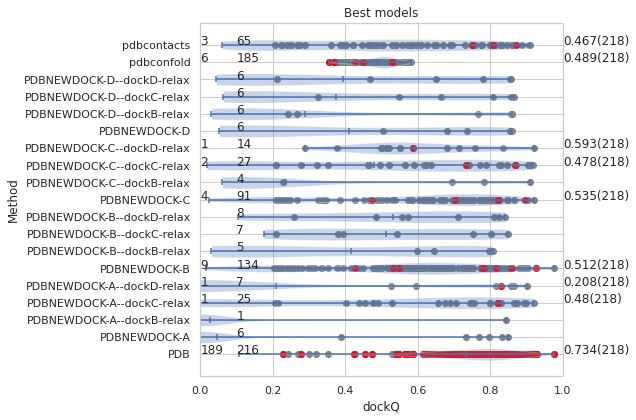

In [86]:
# FInd best method for each model.
codes=df_max.loc[df_max.params.isin(pdbset)]["CODE"].unique()
f, ax = plt.subplots(figsize=(6.5, 6.5))
tempdf=newdf.loc[newdf.JHparams.isin(pdbset)]

#best_df=newdf.sort_values("dockQ", ascending=False)
best_df=tempdf.sort_values('dockQ', ascending=False).drop_duplicates(['code']).reset_index()
best_df.sort_values("JHparams")

good_df=newdf.loc[(newdf.code.isin(codes))&(newdf.JHparams.isin(pdbset))].reset_index()
plt.scatter(good_df.dockQ,good_df.JHparams,color="grey")
plt.scatter(best_df.dockQ,best_df.JHparams,color="red")

#cc=np.corrcoef(newdf.dockQ,newdf.len)
#ax.legend()
ax.set_title("Best models")
ax.set_ylabel("Method")
ax.set_xlabel("dockQ")
ax.set(xlim=[0,1])
done={}
average={}
length={}
pos=[]
i=0
data=[]
for d in sorted(pdbset):
    done[d]=0
    average[d]=df_max.loc[df_max.CODE.isin(codes)&(df_max.params==d)]["dockQ"].mean()
    length[d]=len(df_max.loc[df_max.CODE.isin(codes)&(df_max.params==d)]["dockQ"])
    pos+=[i]
    data+=[df_max.loc[df_max.CODE.isin(codes)&(df_max.params==d)]["dockQ"]]
    i+=1
    #print (d)
    
    
ax.violinplot(data,pos, points=80, vert=False, widths=0.7,
                      showmeans=True, showextrema=True, showmedians=False)    
for i, txt in enumerate(best_df.name):
    #print (i,txt)
    sstr=txt[0:4]
    #ax.annotate(sstr, (newdf.dockQ[i], newdf.JHparams[i]))
    numhit=len(best_df.loc[best_df.JHparams==best_df.JHparams[i]])
    #print (numhit,newdf.JHparams[i])
    if done[best_df.JHparams[i]]==0:
        done[best_df.JHparams[i]]=1
        ax.annotate(str(numhit),(.0, best_df.JHparams[i]))
        ax.annotate(str(round(average[best_df.JHparams[i]],3))+"("+str(length[good_df.JHparams[i]])+")"
                    ,(1.0, best_df.JHparams[i]))
for d in datasets:
    done[d]=0
for i, txt in enumerate(good_df.name):
    #print (i,txt)
    sstr=txt[0:4]
    #ax.annotate(sstr, (newdf.dockQ[i], newdf.JHparams[i]))
    numhit=len(good_df.loc[good_df.JHparams==good_df.JHparams[i]])
    #print (numhit,newdf.JHparams[i])
    if done[good_df.JHparams[i]]==0:
        done[good_df.JHparams[i]]=1
        ax.annotate(str(numhit),(.1, good_df.JHparams[i]))
        #ax.annotate(str(round(average[good_df.JHparams[i]],3)),(1.0, good_df.JHparams[i]))
        #ax.annotate("("+str(length[good_df.JHparams[i]])+")",(1.2, good_df.JHparams[i]))


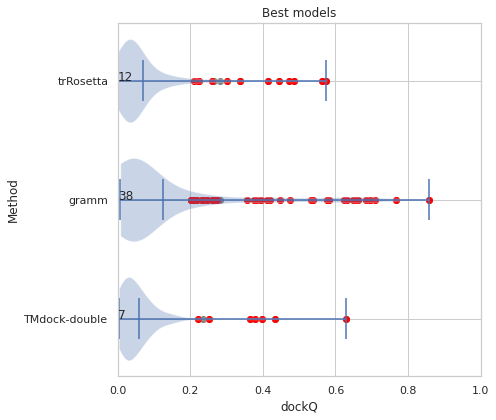

In [87]:
compareset=["trRosetta","gramm","TMdock-double"]
codes=df_max.loc[df_max.params.isin(compareset)]["CODE"].unique()
f, ax = plt.subplots(figsize=(6.5, 6.5))
tempdf=newdf.loc[newdf.JHparams.isin(compareset)]

#best_df=newdf.sort_values("dockQ", ascending=False)
best_df=tempdf.sort_values('dockQ', ascending=False).drop_duplicates(['code']).reset_index()
best_df.sort_values("JHparams")

good_df=newdf.loc[(newdf.code.isin(codes))&(newdf.JHparams.isin(compareset))].reset_index()
plt.scatter(good_df.dockQ,good_df.JHparams,color="grey")
plt.scatter(best_df.dockQ,best_df.JHparams,color="red")

#cc=np.corrcoef(newdf.dockQ,newdf.len)
#ax.legend()
ax.set_title("Best models")
ax.set_ylabel("Method")
ax.set_xlabel("dockQ")
ax.set(xlim=[0,1])
done={}
average={}
length={}
pos=[]
i=0
data=[]
for d in sorted(compareset):
    done[d]=0
    average[d]=df_max.loc[df_max.CODE.isin(codes)&(df_max.params==d)]["dockQ"].mean()
    length[d]=len(df_max.loc[df_max.CODE.isin(codes)&(df_max.params==d)]["dockQ"])
    pos+=[i]
    data+=[df_max.loc[df_max.CODE.isin(codes)&(df_max.params==d)]["dockQ"]]
    i+=1
    #print (d)
    
    
ax.violinplot(data,pos, points=80, vert=False, widths=0.7,
                      showmeans=True, showextrema=True, showmedians=False)    
for i, txt in enumerate(best_df.name):
    #print (i,txt)
    sstr=txt[0:4]
    #ax.annotate(sstr, (newdf.dockQ[i], newdf.JHparams[i]))
    numhit=len(best_df.loc[best_df.JHparams==best_df.JHparams[i]])
    #print (numhit,newdf.JHparams[i])
    if done[best_df.JHparams[i]]==0:
        done[best_df.JHparams[i]]=1
        ax.annotate(str(numhit),(.0, best_df.JHparams[i]))
        #ax.annotate(str(round(average[best_df.JHparams[i]],3))+
        #            "("+str(length[good_df.JHparams[i]])+")"
        #            ,(1.0, best_df.JHparams[i]))
for d in datasets:
    done[d]=0
for i, txt in enumerate(good_df.name):
    #print (i,txt)
    sstr=txt[0:4]
    #ax.annotate(sstr, (newdf.dockQ[i], newdf.JHparams[i]))
    numhit=len(good_df.loc[good_df.JHparams==good_df.JHparams[i]])
    #print (numhit,newdf.JHparams[i])
    if done[good_df.JHparams[i]]==0:
        done[good_df.JHparams[i]]=1
        #ax.annotate(str(numhit),(.1, good_df.JHparams[i]))
        #ax.annotate(str(round(average[good_df.JHparams[i]],3)),(1.0, good_df.JHparams[i]))
        #ax.annotate("("+str(length[good_df.JHparams[i]])+")",(1.2, good_df.JHparams[i]))


In [88]:
best_df

index       JHparams  code                 name  lenA  lenB     msa  \
0    1257          gramm  3qc8  3qc8_u1_A-3qc8_u2_A   169    82     0.0   
1    1262          gramm  4emj  4emj_u1_A-4emj_u2_A   403   106     0.0   
2    1252          gramm  3g3a  3g3a_u1_A-3g3a_u2_A   166   130     0.0   
3    1246          gramm  2hrk  2hrk_u1_A-2hrk_u2_A   181   121     0.0   
4    1266          gramm  4zfr  4zfr_u1_A-4zfr_u2_A   186    77     0.0   
5    1232          gramm  1clv  1clv_u1_A-1clv_u2_A   471    33     0.0   
6    1229          gramm  1buh  1buh_u1_A-1buh_u2_A   291    72     0.0   
7    1237          gramm  1uug  1uug_u1_A-1uug_u2_A   230    83     0.0   
8    1235          gramm  1nbf  1nbf_u1_A-1nbf_u2_A   340    78     0.0   
9    1253          gramm  3lb8  3lb8_u1_A-3lb8_u2_A   422   107     0.0   
10   1212  TMdock-double  3bs5  3bs5_u1_A-3bs5_u2_A    84    76     0.0   
11   1258          gramm  3vlb  3vlb_u1_A-3vlb_u2_A   413   222     0.0   
12   1256          gramm  3prp  3prp_u1_A-3prp_u2_A   184    77     0.0   
13   1230          gramm  1bvn  1bvn_u1_A-1bvn_u2_A   496    75     0.0   
14   1242          gramm  1zlh  1zlh_u1_A-1zlh_u2_A   306    76     0.0   
15   1790      trRosetta  2hqs  2hqs_u2_A-2hqs_u1_A   398   398  2536.0   
16   1795      trRosetta  2zae  2zae_u2_A-2zae_u1_A   107   107  1125.0   
17   1239          gramm  1wq1  1wq1_u1_A-1wq1_u2_A   325   167     0.0   
18   1251          gramm  3daw  3daw_u1_A-3daw_u2_A   360   143     0.0   
19   1796      trRosetta  4gmj  4gmj_u2_A-4gmj_u1_A   253   253  1189.0   
20   1236          gramm  1rpq  1rpq_u1_A-1rpq_u2_A   174    22     0.0   
21   1788      trRosetta  1vrs  1vrs_u2_A-1vrs_u1_A   124   124  2091.0   
22   1245          gramm  2g45  2g45_u1_A-2g45_u2_A   114    77     0.0   
23   1786      trRosetta  1gpw  1gpw_u2_A-1gpw_u1_A   252   252  7203.0   
24   1207  TMdock-double  1ay7  1ay7_u1_A-1ay7_u2_A    97    90     0.0   
25   1261          gramm  4cu4  4cu4_u1_A-4cu4_u2_A   706    22     0.0   
26   1250          gramm  3d5r  3d5r_u1_A-3d5r_u2_A   295    62     0.0   
27   1793      trRosetta  2o3b  2o3b_u2_A-2o3b_u1_A   240   240   456.0   
28   1259          gramm  4bmp  4bmp_u1_A-4bmp_u2_A   301   118     0.0   
29   1214  TMdock-double  3qlu  3qlu_u1_A-3qlu_u2_A   384   374     0.0   
30   1249          gramm  3cbk  3cbk_u1_A-3cbk_u2_A   257   111     0.0   
31   1248          gramm  3bx1  3bx1_u1_A-3bx1_u2_A   270   182     0.0   
32   1243          gramm  2bcg  2bcg_u1_A-2bcg_u2_A   440   179     0.0   
33   1208  TMdock-double  1b27  1b27_u1_A-1b27_u2_A   109    90     0.0   
34   1244          gramm  2bwe  2bwe_u1_A-2bwe_u2_A    78    47     0.0   
35   1211  TMdock-double  2sge  2sge_u1_A-2sge_u2_A   186    57     0.0   
36   1240          gramm  1x86  1x86_u1_A-1x86_u2_A   353   181     0.0   
37   1787      trRosetta  1v5i  1v5i_u2_A-1v5i_u1_A   276   276  1922.0   
38   1798      trRosetta  4xhu  4xhu_u2_A-4xhu_u1_A   352   352   410.0   
39   1233          gramm  1ewy  1ewy_u1_A-1ewy_u2_A   304    99     0.0   
40   1228          gramm  1bdj  1bdj_u1_A-1bdj_u2_A   129   118     0.0   
41   1247          gramm  2qyi  2qyi_u1_A-2qyi_u2_A   224   180     0.0   
42   1789      trRosetta  2d5r  2d5r_u2_A-2d5r_u1_A   265   265   521.0   
43   1213  TMdock-double  3l1z  3l1z_u1_A-3l1z_u2_A   153    86     0.0   
44   1231          gramm  1cc0  1cc0_u1_A-1cc0_u2_A   178   149     0.0   
45   1234          gramm  1g73  1g73_u1_A-1g73_u2_A   174    97     0.0   
46   1263          gramm  4hcn  4hcn_u1_A-4hcn_u2_A   250    77     0.0   
47   1264          gramm  4jx1  4jx1_u1_A-4jx1_u2_A   405   107     0.0   
48   1260          gramm  4cpa  4cpa_u1_A-4cpa_u2_A   308    40     0.0   
49   1792      trRosetta  2nqd  2nqd_u2_A-2nqd_u1_A   221   221   266.0   
50   1794      trRosetta  2x9a  2x9a_u2_A-2x9a_u1_A   103   103     4.0   
51   1210  TMdock-double  2o2v  2o2v_u1_A-2o2v_u2_A   114    94     0.0   
52   1265          gramm  4nz

In [89]:
codes

array(['1ay7', '1b27', '1bdj', '1buh', '1bvn', '1cc0', '1clv', '1dfj',
       '1eay', '1eer', '1ewy', '1fle', '1fq1', '1g6v', '1g73', '1gcq',
       '1gg2', '1gpw', '1he1', '1i2m', '1i4e', '1i8l', '1ib1', '1jiw',
       '1jk9', '1jtd', '1k5g', '1kgy', '1lb2', '1lfd', '1mq8', '1nbf',
       '1nql', '1nw9', '1oc0', '1pvh', '1qav', '1r8s', '1rpq', '1s1q',
       '1te1', '1tmq', '1uug', '1v5i', '1vg0', '1wq1', '1wrd', '1x86',
       '1xt9', '1y64', '1y8x', '1ycs', '1yu6', '1yvb', '1z5y', '1zlh',
       '2a41', '2a5d', '2a9k', '2abz', '2aq3', '2b4s', '2bcg', '2bcn',
       '2bku', '2bwe', '2c0l', '2c2v', '2ch4', '2d5r', '2ejf', '2g45',
       '2grx', '2gwf', '2hj9', '2hqs', '2hrk', '2i25', '2ido', '2iwt',
       '2nqd', '2nxn', '2o25', '2o2v', '2o3b', '2o8v', '2oob', '2qyi',
       '2sge', '2uy7', '2v55', '2vdb', '2vrr', '2wbw', '2wy7', '2wy8',
       '2x9a', '2xgy', '2xwb', '2zae', '3a1p', '3a8i', '3av0', '3bh6',
       '3bs5', '3buz', '3bx1', '3cbk', '3cu1', '3cw2', '3d3c', '3d5r',
      

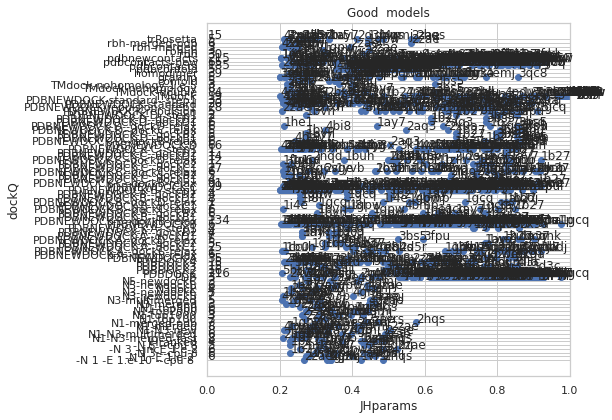

In [90]:

f, ax = plt.subplots(figsize=(6.5, 6.5))
plt.scatter(newdf.dockQ,newdf.JHparams)
#cc=np.corrcoef(newdf.dockQ,newdf.len)
ax.set_title("Good  models")
ax.set_xlabel("JHparams")
ax.set_ylabel("dockQ")
ax.set(xlim=[0,1])
done={}
for d in datasets:
    done[d]=0
for i, txt in enumerate(newdf.name):
    #print (i,txt)
    sstr=txt[0:4]
    ax.annotate(sstr, (newdf.dockQ[i], newdf.JHparams[i]))
    numhit=len(newdf.loc[newdf.JHparams==newdf.JHparams[i]])
    #print (numhit,newdf.JHparams[i])
    if done[newdf.JHparams[i]]==0:
        done[newdf.JHparams[i]]=1
        ax.annotate(str(numhit),(.0, newdf.JHparams[i]))

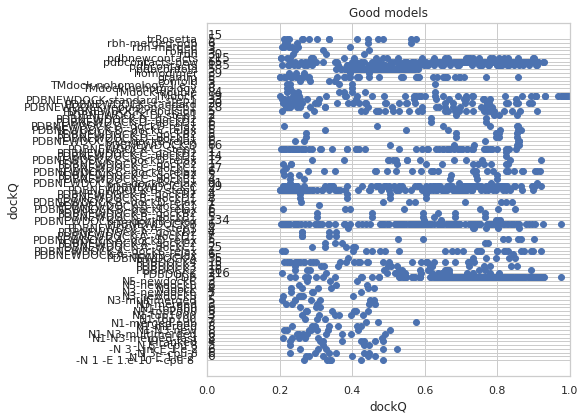

In [91]:
f, ax = plt.subplots(figsize=(6.5, 6.5))
plt.scatter(newdf.dockQ,newdf.JHparams)
#cc=np.corrcoef(newdf.dockQ,newdf.len)
#ax.legend()
ax.set_title("Good models")
ax.set_xlabel("dockQ")
ax.set_ylabel("dockQ")
ax.set(xlim=[0,1])
done={}
for d in datasets:
    done[d]=0
for i, txt in enumerate(newdf.name):
    #print (i,txt)
    sstr=txt[0:4]
    #ax.annotate(sstr, (newdf.dockQ[i], newdf.JHparams[i]))
    numhit=len(newdf.loc[newdf.JHparams==newdf.JHparams[i]])
    #print (numhit,newdf.JHparams[i])
    if done[newdf.JHparams[i]]==0:
        done[newdf.JHparams[i]]=1
        ax.annotate(str(numhit),(.0, newdf.JHparams[i]))

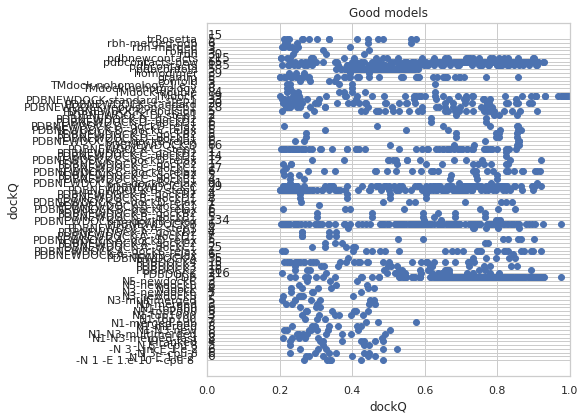

In [92]:
f, ax = plt.subplots(figsize=(6.5, 6.5))
plt.scatter(newdf.dockQ,newdf.JHparams)
#cc=np.corrcoef(newdf.dockQ,newdf.len)
#ax.legend()
ax.set_title("Good models")
ax.set_xlabel("dockQ")
ax.set_ylabel("dockQ")
ax.set(xlim=[0,1])
done={}
for d in datasets:
    done[d]=0
for i, txt in enumerate(newdf.name):
    #print (i,txt)
    sstr=txt[0:4]
    #ax.annotate(sstr, (newdf.dockQ[i], newdf.JHparams[i]))
    numhit=len(newdf.loc[newdf.JHparams==newdf.JHparams[i]])
    #print (numhit,newdf.JHparams[i])
    if done[newdf.JHparams[i]]==0:
        done[newdf.JHparams[i]]=1
        ax.annotate(str(numhit),(.0, newdf.JHparams[i]))

In [93]:
datasets

array(['-N 3 --cpu 8', 'confold', 'gramm', 'homodimer', 'ispred',
       '-N 1 -E 1.e-100 --cpu 8', '-N 1 -E 1.e-2 ', 'N1-merged-pdb',
       'N1-merged', 'N1-N3-merged-fast', 'N1-N3-new', 'N1-N3-multimerged',
       '-N 1 -E 1.e-10 --cpu 8 ', 'N1-top1000-merged', 'N1-top1000',
       'N1-top100', 'N1-top2000', 'N1-top500', 'N3dock',
       '-N 3 --incE 1.e-2', 'N3-merged', 'N3-multimerged', 'N3-newdockA',
       'N3-newdockB', 'N3-newdockC', 'N5-newdockA', 'N5-newdockB',
       'N5-newdockC', '-N 5 --cpu 8', 'pdbconfold', 'pdbcontacts-new',
       'pdbcontacts', 'PDBDOCK2', 'PDBDOCK3', 'PDBDOCK4', 'PDBDOCK',
       'PDBNEWDOCK-standard', 'PDBNEWDOCK-standard--starting',
       'PDBNEWDOCK-standard--step1', 'pdbnewcontacts', 'PDBNEWDOCK-A',
       'PDBNEWDOCK-A--dockB1', 'PDBNEWDOCK-A--dockB2',
       'PDBNEWDOCK-A--dockB-relax', 'PDBNEWDOCK-A--dockC1',
       'PDBNEWDOCK-A--dockC2', 'PDBNEWDOCK-A--dockC-relax',
       'PDBNEWDOCK-A--dockD1', 'PDBNEWDOCK-A--dockD2',
       'PDBNEWDOCK-

In [94]:
# here we find what method is best for each target

r = re.compile("^PDB.*|^TMd.*|^gramm|trRosetta|^pdb.*")
excludecolumns = list(filter(r.match, datasets)) # Read Note
print(excludecolumns)
excludecolumns+=["confold","rbh-merged-pdb"]
tempdf=newdf.loc[~newdf.JHparams.isin(excludecolumns)]

#best_df=newdf.sort_values("dockQ", ascending=False)
best_df=tempdf.sort_values('dockQ', ascending=False).drop_duplicates(['code']).reset_index()
best_df.sort_values("JHparams")

['gramm', 'pdbconfold', 'pdbcontacts-new', 'pdbcontacts', 'PDBDOCK2', 'PDBDOCK3', 'PDBDOCK4', 'PDBDOCK', 'PDBNEWDOCK-standard', 'PDBNEWDOCK-standard--starting', 'PDBNEWDOCK-standard--step1', 'pdbnewcontacts', 'PDBNEWDOCK-A', 'PDBNEWDOCK-A--dockB1', 'PDBNEWDOCK-A--dockB2', 'PDBNEWDOCK-A--dockB-relax', 'PDBNEWDOCK-A--dockC1', 'PDBNEWDOCK-A--dockC2', 'PDBNEWDOCK-A--dockC-relax', 'PDBNEWDOCK-A--dockD1', 'PDBNEWDOCK-A--dockD2', 'PDBNEWDOCK-A--dockD-relax', 'PDBNEWDOCK-A--starting', 'PDBNEWDOCK-A--step1', 'PDBNEWDOCK-B', 'PDBNEWDOCK-B--dockB1', 'PDBNEWDOCK-B--dockB2', 'PDBNEWDOCK-B--dockB-relax', 'PDBNEWDOCK-B--dockC1', 'PDBNEWDOCK-B--dockC2', 'PDBNEWDOCK-B--dockC-relax', 'PDBNEWDOCK-B--dockD1', 'PDBNEWDOCK-B--dockD2', 'PDBNEWDOCK-B--dockD-relax', 'PDBNEWDOCK-B--starting', 'PDBNEWDOCK-B--step1', 'PDBNEWDOCK-C', 'PDBNEWDOCK-C--dockB1', 'PDBNEWDOCK-C--dockB2', 'PDBNEWDOCK-C--dockB-relax', 'PDBNEWDOCK-C--dockC1', 'PDBNEWDOCK-C--dockC2', 'PDBNEWDOCK-C--dockC-relax', 'PDBNEWDOCK-C--dockD1', 'PDBN

index           JHparams  code                 name  lenA  lenB     msa  \
9       9     -N 1 -E 1.e-2   2hrk  2hrk_u1_A-2hrk_u2_A   181   121    59.0   
5      14       -N 3 --cpu 8  1gpw  1gpw_u2_A-1gpw_u1_A   252   252  7137.0   
6      15       -N 3 --cpu 8  1v5i  1v5i_u2_A-1v5i_u1_A   276   276  1922.0   
1      21  -N 3 --incE 1.e-2  2zae  2zae_u1_A-2zae_u2_A   107    93  1080.0   
2      22  -N 3 --incE 1.e-2  4gmj  4gmj_u1_A-4gmj_u2_A   253   236  1189.0   
7      41  N1-N3-multimerged  1ay7  1ay7_u2_A-1ay7_u1_A    97    97   100.0   
10     42  N1-N3-multimerged  1b27  1b27_u2_A-1b27_u1_A   109   109   100.0   
8      56          N1-N3-new  4xhu  4xhu_u2_A-4xhu_u1_A   352   352   410.0   
13     55          N1-N3-new  4txo  4txo_u2_A-4txo_u1_A   158   178  6263.0   
4      60          N1-merged  2o3b  2o3b_u2_A-2o3b_u1_A   240   240   456.0   
0      65      N1-merged-pdb  2hqs  2hqs_u2_A-2hqs_u1_A   398   398  2368.0   
3      64      N1-merged-pdb  1vrs  1vrs_u2_A-1vrs_u1_A   124   124   836.0   
11    109             N3dock  2d5r  2d5r_u2_A-2d5r_u1_A   265   265   521.0   
12   1774         rbh-merged  2nqd  2nqd_u1_A-2nqd_u2_A   221   111    18.0   

       msaA      msaB  cdhit  ...  CODE             params      tmAB    msaAB  \
9     397.0      64.0     56  ...  2hrk     -N 1 -E 1.e-2   0.677510    230.5   
5   67629.0   67629.0   5348  ...  1gpw       -N 3 --cpu 8  0.889770  63047.5   
6   54177.0   54177.0   1646  ...  1v5i       -N 3 --cpu 8  0.826270  33121.5   
1    1732.0    1544.0    814  ...  2zae  -N 3 --incE 1.e-2  0.827755   1638.0   
2    6237.0    1654.0    514  ...  4gmj  -N 3 --incE 1.e-2  0.835100   3945.5   
7    2034.0    2034.0     99  ...  1ay7  N1-N3-multimerged  0.823980   1759.5   
10   2034.0    2034.0     99  ...  1b27  N1-N3-multimerged  0.807610   1759.0   
8    8381.0    8381.0    240  ...  4xhu          N1-N3-new  0.827330   4344.0   
13  54068.0  120547.0   5896  ...  4txo          N1-N3-new  0.732770  87307.5   
4    5431.0    5431.0    301  ...  2o3b          N1-merged  0.727490   2974.5   
0    9156.0    9156.0   1989  ...  2hqs      N1-merged-pdb  0.969605   6972.0   
3    1396.0    1396.0    806  ...  1vrs      N1-merged-pdb  0.989810   1320.5   
11   6154.0    6154.0    226  ...  2d5r             N3dock  0.774685   3962.5   
12  21051.0     801.0     18  ...  2nqd         rbh-merged  0.832645  10926.0   

    tmAB_max  msaAB_max  tmAB_min  msaAB_min  numcorrect  len  
9    0.70198      397.0   0.65304       64.0       1.972  302  
5    0.89718    67629.0   0.88236    58466.0     130.000  456  
6    0.89294    54177.0   0.75960    12066.0       1.000  354  
1    0.83351     1732.0   0.82200     1544.0      71.978  200  
2    0.86274     6237.0   0.80746     1654.0     132.090  489  
7    0.84058     2034.0   0.80738     1485.0       1.995  187  
10   0.84948     2034.0   0.76574     1484.0      27.000  199  
8    0.85317     8381.0   0.80149      307.0       0.000  447  
13   0.75571   120547.0   0.70983    54068.0       0.000  336  
4    0.83406     5431.0   0.62495      518.0      29.008  384  
0    0.97016     9156.0   0.96905     4788.0     100.035  507  
3    0.99288     1396.0   0.98674     1245.0      53.988  241  
11   0.87927     6154.0   0.68937     1771.0      17.996  386  
12   0.85500    21051.0   0.81029      801.0       0.000  332  

[14 rows x 54 columns]

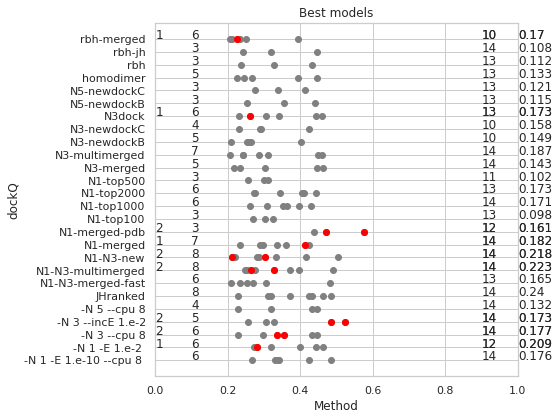

In [95]:
# FInd best method for each model.
codes=best_df["code"].unique()
f, ax = plt.subplots(figsize=(6.5, 6.5))
good_df=newdf.loc[(newdf.code.isin(codes))&(~newdf.JHparams.isin(excludecolumns))].reset_index()
plt.scatter(good_df.dockQ,good_df.JHparams,color="grey")
plt.scatter(best_df.dockQ,best_df.JHparams,color="red")

#cc=np.corrcoef(newdf.dockQ,newdf.len)
#ax.legend()
ax.set_title("Best models")
ax.set_xlabel("Method")
ax.set_ylabel("dockQ")
ax.set(xlim=[0,1])
done={}
average={}
length={}
for d in datasets:
    done[d]=0
    average[d]=df_max.loc[df_max.CODE.isin(codes)&(df_max.params==d)]["dockQ"].mean()
    length[d]=len(df_max.loc[df_max.CODE.isin(codes)&(df_max.params==d)]["dockQ"])
for i, txt in enumerate(best_df.name):
    #print (i,txt)
    sstr=txt[0:4]
    #ax.annotate(sstr, (newdf.dockQ[i], newdf.JHparams[i]))
    numhit=len(best_df.loc[best_df.JHparams==best_df.JHparams[i]])
    #print (numhit,newdf.JHparams[i])
    if done[best_df.JHparams[i]]==0:
        done[best_df.JHparams[i]]=1
        ax.annotate(str(numhit),(.0, best_df.JHparams[i]))
        ax.annotate(str(round(average[best_df.JHparams[i]],3)),(1.0, best_df.JHparams[i]))
        ax.annotate(str(length[best_df.JHparams[i]]),(.9, best_df.JHparams[i]))
for d in datasets:
    done[d]=0
for i, txt in enumerate(good_df.name):
    #print (i,txt)
    sstr=txt[0:4]
    #ax.annotate(sstr, (newdf.dockQ[i], newdf.JHparams[i]))
    numhit=len(good_df.loc[good_df.JHparams==good_df.JHparams[i]])
    #print (numhit,newdf.JHparams[i])
    if done[good_df.JHparams[i]]==0:
        done[good_df.JHparams[i]]=1
        ax.annotate(str(numhit),(.1, good_df.JHparams[i]))
        ax.annotate(str(round(average[good_df.JHparams[i]],3)),(1.0, good_df.JHparams[i]))
        ax.annotate(str(length[good_df.JHparams[i]]),(.9, good_df.JHparams[i]))


In [96]:
df.sort_values('dockQ', ascending=False).drop_duplicates(["code"])

name         JHparams lenA lenB msa msaA msaB cdhit  \
18712  1tmq_u1_A-1tmq_u2_A           TMdock  471  123   0    0    0     0   
18442  1g73_u1_A-1g73_u2_A           TMdock  174   97   0    0    0     0   
19533  3kld_u1_A-3kld_u2_A           TMdock  384  265   0    0    0     0   
18602  1mq8_u1_A-1mq8_u2_A           TMdock  186  176   0    0    0     0   
18612  1nbf_u1_A-1nbf_u2_A           TMdock  340   78   0    0    0     0   
...                    ...              ...  ...  ...  ..  ...  ...   ...   
26003  4k0v_u1_A-4k0v_u2_A              PDB  424  218   0    0    0     0   
7700   4ilh_u2_A-4ilh_u1_A       pdbconfold  256  301   0    0    0     0   
7832   4rws_u2_A-4rws_u1_A       pdbconfold   72  434   0    0    0     0   
8273   4ol0_u2_A-4ol0_u1_A  pdbcontacts-new  206  890   0    0    0     0   
26075  4yoc_u1_A-4yoc_u2_A              PDB  905  530   0    0    0     0   

       dockQ   fnat  ...  CODE           params      tmAB msaAB tmAB_max  \
18712      1      1  ...  1tmq           TMdock  1.000000   0.0  1.00000   
18442      1      1  ...  1g73           TMdock  1.000000   0.0  1.00000   
19533      1      1  ...  3kld           TMdock  1.000000   0.0  1.00000   
18602      1      1  ...  1mq8           TMdock  1.000000   0.0  1.00000   
18612      1      1  ...  1nbf           TMdock  1.000000   0.0  1.00000   
...      ...    ...  ...   ...              ...       ...   ...      ...   
26003  0.455  0.743  ...  4k0v              PDB  0.438965   0.0  0.45404   
7700   0.427   0.88  ...  4ilh       pdbconfold  0.675775   0.0  0.67941   
7832   0.356   0.79  ...  4rws       pdbconfold  0.417545   0.0  0.50613   
8273   0.277  0.296  ...  4ol0  pdbcontacts-new  0.940670   0.0  0.95950   
26075  0.107  0.319  ...  4yoc              PDB  0.300345   0.0  0.32157   

      msaAB_max tmAB_min msaAB_min numcorrect   len  
18712       0.0  1.00000       0.0          0   594  
18442       0.0  1.00000       0.0          0   271  
19533       0.0  1.00000       0.0          0   649  
18602       0.0  1.00000       0.0          0   362  
18612       0.0  1.00000       0.0          0   418  
...         ...      ...       ...        ...   ...  
26003       0.0  0.42389       0.0          0   642  
7700        0.0  0.67214       0.0          0   557  
7832        0.0  0.32896       0.0          0   506  
8273        0.0  0.92184       0.0          0  1096  
26075       0.0  0.27912       0.0          0  1435  

[218 rows x 53 columns]

In [97]:
df.loc[(df.dockQ>cutoff) & (~df.JHparams.isin(excludecolumns))].groupby("name").max()


JHparams  lenA  lenB     msa      msaA  \
name                                                                   
1ay7_u1_A-1ay7_u2_A             rbh-jh    97    90  1060.0    1490.0   
1ay7_u2_A-1ay7_u1_A          homodimer    90    97  1060.0    2034.0   
1b27_u1_A-1b27_u2_A          homodimer   109    90   733.0    1484.0   
1b27_u2_A-1b27_u1_A          homodimer    90   109   733.0    2034.0   
1gpw_u1_A-1gpw_u2_A         rbh-merged   252   204  7146.0   80768.0   
1gpw_u2_A-1gpw_u1_A             rbh-jh   204   252  7137.0   67629.0   
1v5i_u1_A-1v5i_u2_A       -N 3 --cpu 8   276    78  1922.0   54177.0   
1vrs_u1_A-1vrs_u2_A         N1-top2000   124   117   836.0  100319.0   
1vrs_u2_A-1vrs_u1_A         N1-top2000   117   124  2091.0    2803.0   
2d5r_u2_A-2d5r_u1_A             N3dock   121   265   521.0    1771.0   
2hqs_u1_A-2hqs_u2_A         N1-top2000   398   109  2396.0  376708.0   
2hqs_u2_A-2hqs_u1_A         N1-top2000   109   398  2535.0   32336.0   
2hrk_u1_A-2hrk_u2_A  -N 3 --incE 1.e-2   181   121   740.0   23616.0   
2nqd_u1_A-2nqd_u2_A         rbh-merged   221   111    18.0   21051.0   
2o3b_u1_A-2o3b_u2_A         rbh-merged   240   144   456.0    5431.0   
2zae_u1_A-2zae_u2_A         rbh-merged   107    93  1125.0    1818.0   
2zae_u2_A-2zae_u1_A             rbh-jh    93   107  1125.0    1521.0   
4gmj_u1_A-4gmj_u2_A         rbh-merged   253   236  1189.0    6344.0   
4gmj_u2_A-4gmj_u1_A          homodimer   236   253  1189.0    1653.0   
4txo_u2_A-4txo_u1_A          N1-N3-new   158   178  6263.0   54068.0   
4xhu_u1_A-4xhu_u2_A         rbh-merged   352    95   410.0    8381.0   
4xhu_u2_A-4xhu_u1_A     N3-multimerged    95   352   410.0     307.0   

                         msaB  cdhit  dockQ   fnat    iRMS  ...  CODE  \
name                                                        ...         
1ay7_u1_A-1ay7_u2_A    2039.0   1026  0.328  0.361   4.628  ...  1ay7   
1ay7_u2_A-1ay7_u1_A    1485.0    989  0.280  0.333   4.614  ...  1ay7   
1b27_u1_A-1b27_u2_A    2034.0    654  0.265  0.160   4.984  ...  1b27   
1b27_u2_A-1b27_u1_A    1484.0    656  0.252  0.200   5.319  ...  1b27   
1gpw_u1_A-1gpw_u2_A   76000.0   5374  0.351  0.293   5.499  ...  1gpw   
1gpw_u2_A-1gpw_u1_A   58466.0   5343  0.354  0.333   5.614  ...  1gpw   
1v5i_u1_A-1v5i_u2_A   12066.0   1642  0.336  0.191   3.748  ...  1v5i   
1vrs_u1_A-1vrs_u2_A    2803.0    806  0.472  0.449   2.953  ...  1vrs   
1vrs_u2_A-1vrs_u1_A  100319.0   1977  0.324  0.306   7.831  ...  1vrs   
2d5r_u2_A-2d5r_u1_A    6154.0    225  0.261  0.203  10.074  ...  2d5r   
2hqs_u1_A-2hqs_u2_A   32336.0   2014  0.575  0.526   3.771  ...  2hqs   
2hqs_u2_A-2hqs_u1_A  376708.0   2200  0.480  0.395   3.485  ...  2hqs   
2hrk_u1_A-2hrk_u2_A    9957.0    558  0.282  0.261   4.982  ...  2hrk   
2nqd_u1_A-2nqd_u2_A     801.0     18  0.225  0.076   5.083  ...  2nqd   
2o3b_u1_A-2o3b_u2_A     518.0    306  0.413  0.556   4.959  ...  2o3b   
2zae_u1_A-2zae_u2_A    1544.0    839  0.523  0.484   6.495  ...  2zae   
2zae_u2_A-2zae_u1_A    1818.0    852  0.461  0.484   6.490  ...  2zae   
4gmj_u1_A-4gmj_u2_A    1654.0    523  0.485  0.829   4.889  ...  4gmj   
4gmj_u2_A-4gmj_u1_A    6344.0    546  0.445  0.780   4.389  ...  4gmj   
4txo_u2_A-4txo_u1_A  120547.0   5896  0.211  0.093   5.281  ...  4txo   
4xhu_u1_A-4xhu_u2_A     307.0    240  0.265  0.278   6.145  ...  4xhu   
4xhu_u2_A-4xhu_u1_A    8381.0    234  0.302  0.556   5.729  ...  4xhu   

                                params      tmAB     msaAB  tmAB_max  \
name                                                                   
1ay7_u1_A-1ay7_u2_A             rbh-jh  0.830380    1764.5   0.84625   
1ay7_u2_A-1ay7_u1_A          homodimer  0.823980    1759.5   0.84181   
1b27_u1_A-1b27_u2_A          homodimer  0.825820    1759.0   0.85658   
1b27_u2_A-1b27_u1_A          homodimer  0.810645    1759.0   0.85149   
1gpw_u1_A-1gpw_u2_A         rbh-merged  0.889680   78384.0   0.89390   
1gpw_u2_A-1gpw_u1_A             rbh-jh  0.89

['gramm', 'pdbconfold', 'pdbcontacts-new', 'pdbcontacts', 'PDBDOCK2', 'PDBDOCK3', 'PDBDOCK4', 'PDBDOCK', 'PDBNEWDOCK-standard', 'PDBNEWDOCK-standard--starting', 'PDBNEWDOCK-standard--step1', 'pdbnewcontacts', 'PDBNEWDOCK-A', 'PDBNEWDOCK-A--dockB1', 'PDBNEWDOCK-A--dockB2', 'PDBNEWDOCK-A--dockB-relax', 'PDBNEWDOCK-A--dockC1', 'PDBNEWDOCK-A--dockC2', 'PDBNEWDOCK-A--dockC-relax', 'PDBNEWDOCK-A--dockD1', 'PDBNEWDOCK-A--dockD2', 'PDBNEWDOCK-A--dockD-relax', 'PDBNEWDOCK-A--starting', 'PDBNEWDOCK-A--step1', 'PDBNEWDOCK-B', 'PDBNEWDOCK-B--dockB1', 'PDBNEWDOCK-B--dockB2', 'PDBNEWDOCK-B--dockB-relax', 'PDBNEWDOCK-B--dockC1', 'PDBNEWDOCK-B--dockC2', 'PDBNEWDOCK-B--dockC-relax', 'PDBNEWDOCK-B--dockD1', 'PDBNEWDOCK-B--dockD2', 'PDBNEWDOCK-B--dockD-relax', 'PDBNEWDOCK-B--starting', 'PDBNEWDOCK-B--step1', 'PDBNEWDOCK-C', 'PDBNEWDOCK-C--dockB1', 'PDBNEWDOCK-C--dockB2', 'PDBNEWDOCK-C--dockB-relax', 'PDBNEWDOCK-C--dockC1', 'PDBNEWDOCK-C--dockC2', 'PDBNEWDOCK-C--dockC-relax', 'PDBNEWDOCK-C--dockD1', 'PDBN

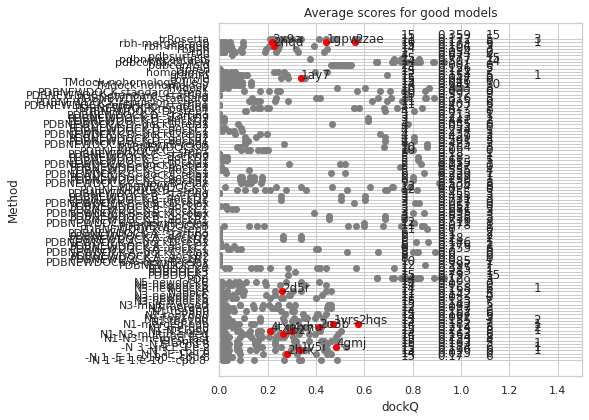

In [98]:
r = re.compile("^PDB.*|^TMd.*|^gramm|trRosetta|^pdb.*")
excludecolumns = list(filter(r.match, datasets)) # Read Note
print (excludecolumns)
includeTR=["pdbcontacts","PDBDOCK","TMdock-double"]
cutoff=0.2
f, ax = plt.subplots(figsize=(6.5, 6.5))
#cc=np.corrcoef(newdf.dockQ,newdf.len)
#ax.legend()
ax.set_title("Best methods")

new_df=df.loc[(df.dockQ>cutoff) & (~df.JHparams.isin(excludecolumns))].sort_values('dockQ', ascending=False).drop_duplicates(["code"]).reset_index()
codes=new_df.CODE.unique()
#print(new_df)
#newdf.sort_values(["JHparams","dockQ","code"],inplace=True)

tempdf=df_max.loc[(df_max.CODE.isin(codes)) & (~df_max.params.isin(includeTR))].reset_index()
plt.scatter(tempdf.dockQ,tempdf.params,color="grey")
#print(tempdf[tempdf.params=="N1-top1000"])
plt.scatter(new_df.dockQ,new_df.params,color="red")
#print(new_df[new_df.params=="N1-top1000"])

#cc=np.corrcoef(newdf.dockQ,newdf.len)
#ax.legend()
ax.set_title("Average scores for good models")
ax.set_xlabel("dockQ")
ax.set_ylabel("Method")
ax.set(xlim=[0,1])
done={}
average={}
length={}
ax.set(xlim=[0,1.5])
for d in datasets: #~df.JHparams.isin(excludecolumns).unique():
    done[d]=0
    average[d]=df_max.loc[(df_max.CODE.isin(codes)) & (df_max.params==d)]["dockQ"].mean()
    length[d]=len(df_max.loc[(df_max.CODE.isin(codes)) & (df_max.params==d)]["dockQ"])
for i, txt in enumerate(tempdf.name):
    #print (i,txt, newdf.JHparams[i])
    sstr=txt[0:4]
    #ax.annotate(sstr, (newdf.dockQ[i], newdf.JHparams[i]))
    numhit=len(tempdf.loc[(tempdf.params==tempdf.params[i])&(tempdf.dockQ>cutoff)])
    
    #print (numhit,newdf.JHparams[i])
    if done[tempdf.params[i]]==0:
        done[tempdf.params[i]]=1
        ax.annotate(str(numhit),(1.1, tempdf.params[i]))
        #ax.annotate("0",(.1, tempdf.JHparams[i]))  
        ax.annotate(str(round(average[tempdf.params[i]],3)),(.9, tempdf.params[i]))          
        ax.annotate(str(round(length[tempdf.params[i]],3)),(.75, tempdf.params[i]))  
for d in datasets: #~df.JHparams.isin(excludecolumns).unique():
    done[d]=0
for i, txt in enumerate(new_df.name):
    #print (i,txt,newdf.dockQ[i], newdf.JHparams[i])
    sstr=txt[0:4]
    ax.annotate(sstr, (new_df.dockQ[i], new_df.params[i]))
    numhit=len(new_df.loc[new_df.params==new_df.params[i]])
    #numhit2=len(tempdf.loc[tempdf.JHparams==tempdf.params[i]])
    #print (numhit,newdf.JHparams[i])
    if done[new_df.params[i]]==0:
        done[new_df.params[i]]=1
        ax.annotate(str(numhit),(1.3, new_df.params[i]))  
        #ax.annotate(str(numhit2),(-0.1, new_df.JHparams[i]))


In [99]:
cutoff=0.1

In [100]:
JHsets=['-N 3 --cpu 8', 
       '-N 1 -E 1.e-100 --cpu 8', '-N 1 -E 1.e-2 ', 'N1-merged-pdb',
       'N1-merged', '-N 1 -E 1.e-10 --cpu 8 ', 'N1-top1000-merged',
       'N1-top1000', 'N1-top100', 'N1-top2000', 'N1-top500',  '-N 5 --cpu 8']

cutoff=0.1

In [101]:
goodmodels=df_max.loc[(df_max.dockQ>cutoff)&(df_max.params.isin(JHsets)) ]["CODE"].unique()

/usr/lib/python3/dist-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/lib/python3/dist-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


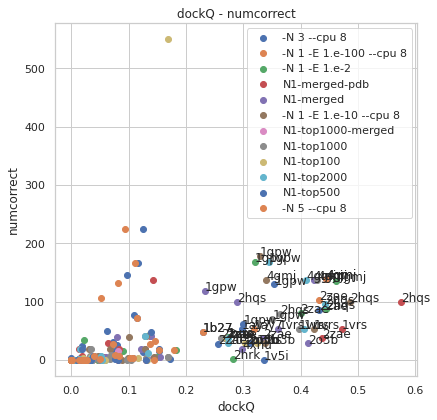

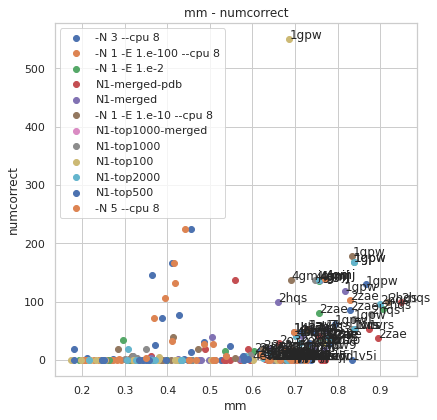

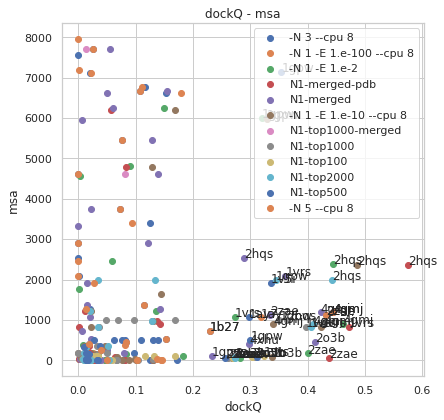

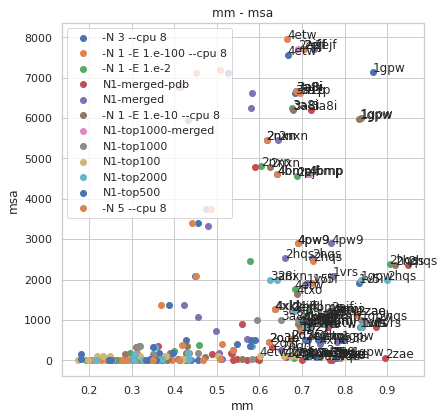

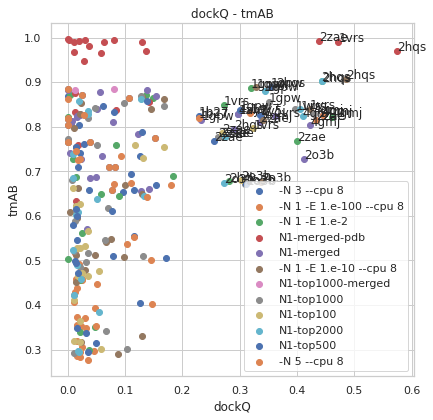

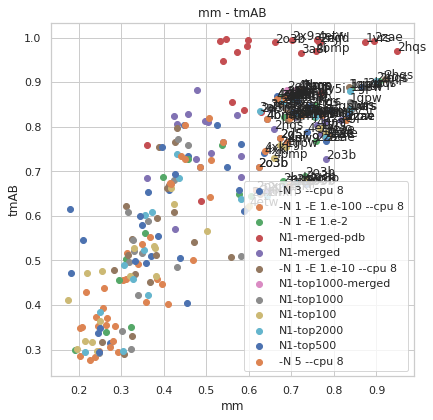

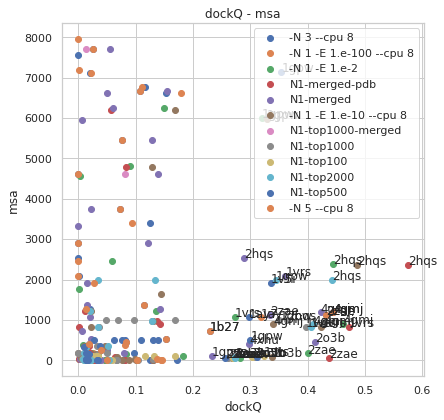

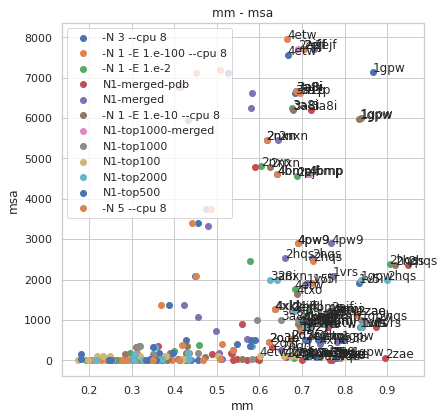

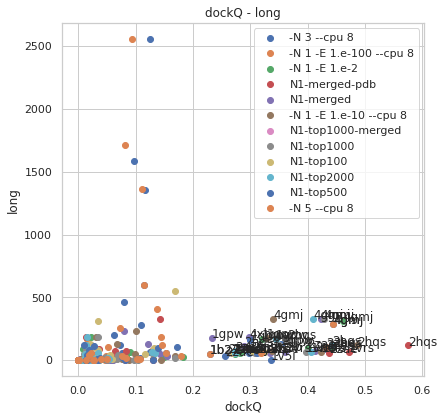

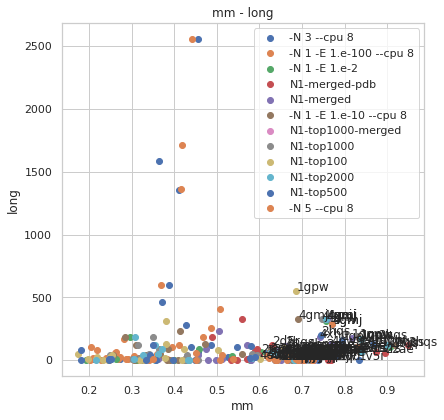

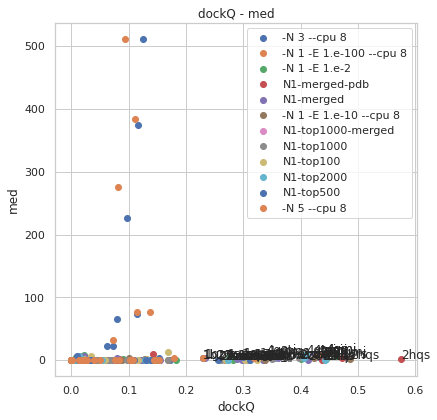

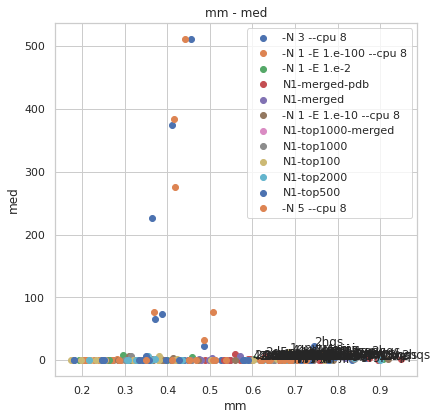

In [102]:
tempdf=df_max.loc[df_max.params.isin(JHsets)] 


tempdf=tempdf.loc[tempdf.CODE.isin(goodmodels)]
cf={"dockQ":0.2,"mm":0.6,"numcorrect":50}
for y in ["numcorrect","msa","tmAB","msa","long","med"]:
    for x in ["dockQ","mm","numcorrect"]:
        cutoff=cf[x]
        #print (Name)
         #if (Name != "lenA"):
        #    continue
        f, ax = plt.subplots(figsize=(6.5, 6.5))
        for d in JHsets:
            xdata=tempdf.loc[tempdf.params==d][x]
            ydata=tempdf.loc[tempdf.params==d][y]
            plt.scatter(xdata,ydata,label=d)
            cc=np.corrcoef(xdata,ydata)
            for i, txt in enumerate(tempdf.loc[tempdf.params==d].name):
                sstr=txt[0:4]
                if (xdata[i]>cutoff):
                    ax.annotate(sstr, (xdata[i], ydata[i]))
        ax.set_title(x + " - " + y )
        ax.set_xlabel(x)
        ax.set_ylabel(y)
        ax.legend()
    plt.close()

In [103]:
datasets

array(['-N 3 --cpu 8', 'confold', 'gramm', 'homodimer', 'ispred',
       '-N 1 -E 1.e-100 --cpu 8', '-N 1 -E 1.e-2 ', 'N1-merged-pdb',
       'N1-merged', 'N1-N3-merged-fast', 'N1-N3-new', 'N1-N3-multimerged',
       '-N 1 -E 1.e-10 --cpu 8 ', 'N1-top1000-merged', 'N1-top1000',
       'N1-top100', 'N1-top2000', 'N1-top500', 'N3dock',
       '-N 3 --incE 1.e-2', 'N3-merged', 'N3-multimerged', 'N3-newdockA',
       'N3-newdockB', 'N3-newdockC', 'N5-newdockA', 'N5-newdockB',
       'N5-newdockC', '-N 5 --cpu 8', 'pdbconfold', 'pdbcontacts-new',
       'pdbcontacts', 'PDBDOCK2', 'PDBDOCK3', 'PDBDOCK4', 'PDBDOCK',
       'PDBNEWDOCK-standard', 'PDBNEWDOCK-standard--starting',
       'PDBNEWDOCK-standard--step1', 'pdbnewcontacts', 'PDBNEWDOCK-A',
       'PDBNEWDOCK-A--dockB1', 'PDBNEWDOCK-A--dockB2',
       'PDBNEWDOCK-A--dockB-relax', 'PDBNEWDOCK-A--dockC1',
       'PDBNEWDOCK-A--dockC2', 'PDBNEWDOCK-A--dockC-relax',
       'PDBNEWDOCK-A--dockD1', 'PDBNEWDOCK-A--dockD2',
       'PDBNEWDOCK-

In [104]:
goodmodels

array(['1gpw', '1vrs', '2hqs', '2nxn', '2o3b', '2zae', '3a8i', '3fpu',
       '4bmp', '4c6t', '4gmj', '4txo', '2hrk', '1ay7', '1b27', '1gcq',
       '1v5i', '2d5r', '2wbw', '2x9a', '3a1p', '3f1p', '4xs0', '3pv6',
       '5cra', '4pw9', '4xhu', '4xkl', '2nqd', '2ejf', '4etw'],
      dtype=object)

In [105]:
tempdf=df_max.loc[df_max.CODE.isin(codes)&(df_max.params.isin(pdbset))]
tempdf

name  lenA  lenB     msa     msaA  \
JHparams    code                                                               
PDB         1ay7  1ay7_u2_A-1ay7_u1_A.pdb-step1    97    97  1060.0   1485.0   
            1b27  1b27_u2_A-1b27_u1_A.pdb-step1   109   109   733.0   1484.0   
            1gpw            1gpw_u2_A-1gpw_u1_A   252   252  7137.0  58466.0   
            1v5i  1v5i_u2_A-1v5i_u1_A.pdb-step1   276   276     0.0      0.0   
            1vrs  1vrs_u2_A-1vrs_u1_A.pdb-step1   124   124     0.0      0.0   
...                                         ...   ...   ...     ...      ...   
pdbcontacts 2o3b            2o3b_u1_A-2o3b_u2_A   240   144   456.0   5431.0   
            2x9a            2x9a_u1_A-2x9a_u2_A   103    63     4.0   2604.0   
            2zae            2zae_u1_A-2zae_u2_A   107    93  1125.0   1659.0   
            4gmj            4gmj_u1_A-4gmj_u2_A   253   236  1189.0   6152.0   
            4xhu            4xhu_u2_A-4xhu_u1_A   352   352   410.0   8381.0   

                     msaB  cdhit  dockQ   fnat     iRMS  ...  CODE  \
JHparams    code                                         ...         
PDB         1ay7   2034.0    986  0.929  0.861  185.585  ...  1ay7   
            1b27   2034.0    654  0.919  0.800  204.850  ...  1b27   
            1gpw  67629.0   5348  0.771  0.733  479.285  ...  1gpw   
            1v5i      0.0      0  0.653  0.660  479.679  ...  1v5i   
            1vrs      0.0      0  0.832  0.755  206.013  ...  1vrs   
...                   ...    ...    ...    ...      ...  ...   ...   
pdbcontacts 2o3b    518.0    306  0.529  0.722    2.773  ...  2o3b   
            2x9a     18.0      4  0.692  0.750    0.814  ...  2x9a   
            2zae   1521.0    839  0.539  0.565    1.397  ...  2zae   
            4gmj   1646.0    523  0.275  0.488    2.149  ...  4gmj   
            4xhu   8381.0    240  0.467  0.519   10.946  ...  4xhu   

                       params      tmAB    msaAB  tmAB_max  msaAB_max  \
JHparams    code                                                        
PDB         1ay7          PDB  0.998225   1759.5   0.99846     2034.0   
            1b27          PDB  0.998015   1759.0   0.99893     2034.0   
            1gpw          PDB  0.983270  63047.5   0.98685    67629.0   
            1v5i          PDB  0.962600      0.0   0.97830        0.0   
            1vrs          PDB  0.975860      0.0   0.99533        0.0   
...                       ...       ...      ...       ...        ...   
pdbcontacts 2o3b  pdbcontacts  0.836740   2974.5   0.93597     5431.0   
            2x9a  pdbcontacts  0.911500   1311.0   0.98016     2604.0   
            2zae  pdbcontacts  0.860355   1590.0   0.93809     1659.0   
            4gmj  pdbcontacts  0.720295   3899.0   0.72888     6152.0   
            4xhu  pdbcontacts  0.873565   4344.0   0.92326     8381.0   

                  tmAB_min  msaAB_min  numcorrect  len  
JHparams    code                                        
PDB         1ay7   0.99799     1485.0         0.0  187  
            1b27   0.99710     1484.0         0.0  199  
            1gpw   0.97969    58466.0         0.0  456  
            1v5i   0.94690        0.0         0.0  354  
            1vrs   0.96808        0.0         0.0  241  
...                    ...        ...         ...  ...  
pdbcontacts 2o3b   0.73751      518.0         0.0  384  
            2x9a   0.84284       18.0         0.0  166  
            2zae   0.78262     1521.0         0.0  200  
            4gmj   0.71171     1646.0         0.0  489  
            4xhu   0.85175      307.0         0.0  447  

[132 rows x 51 columns]

In [106]:
df_max.loc[df_max.params=="N3-multimerged"]["dockQ"]

JHparams        code
N3-multimerged  1ay7    0.287
                1b27    0.242
                1bdj    0.050
                1buh    0.023
                1bvn    0.012
                        ...  
                4xs0    0.083
                4y5o    0.036
                4y7m    0.024
                4yeb    0.040
                4yoc    0.025
Name: dockQ, Length: 118, dtype: float64

-N 3 --cpu 8
N1-N3-merged-fast
N1-N3-multimerged
N1-N3-new
N1-merged
N1-merged-pdb
N1-top1000
N3-merged
N3-multimerged


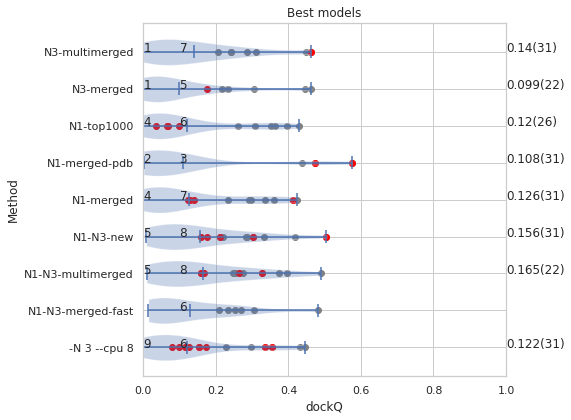

In [140]:
pdbset=['-N 3 --cpu 8',  'N1-top1000',
        'N1-merged','N1-merged-pdb','N3-merged',"N3-multimerged",
        "N1-N3-multimerged","N1-N3-merged-fast","N1-N3-new"]
cutoff=0.2
codes=goodmodels
# FInd best method for each model.
#codes=df_max.loc[df_max.params.isin(pdbset)]["CODE"].unique()
f, ax = plt.subplots(figsize=(6.5, 6.5))
#tempdf=newdf.loc[newdf.JHparams.isin(pdbset)]
tempdf=df_max.loc[df_max.CODE.isin(codes)&(df_max.params.isin(pdbset))]
#best_df=newdf.sort_values("dockQ", ascending=False)
best_df=tempdf.sort_values('dockQ', ascending=False).drop_duplicates(['CODE']).reset_index()
best_df.sort_values("params")

#good_df=newdf.loc[(newdf.code.isin(codes))&(newdf.JHparams.isin(pdbset))].reset_index()
good_df=df_max.loc[df_max.CODE.isin(codes)&(df_max.params.isin(pdbset))&(df_max.dockQ>cutoff )].reset_index()

plt.scatter(good_df.dockQ,good_df.params,color="grey")
plt.scatter(best_df.dockQ,best_df.params,color="red")

#cc=np.corrcoef(newdf.dockQ,newdf.len)
#ax.legend()
ax.set_title("Best models")
ax.set_ylabel("Method")
ax.set_xlabel("dockQ")
ax.set(xlim=[0,1])
done={}
average={}
length={}
pos=[]
i=0
data=[]
for d in sorted(pdbset):
    done[d]=0
    average[d]=df_max.loc[df_max.CODE.isin(codes)&(df_max.params==d)]["dockQ"].mean()
    length[d]=len(df_max.loc[df_max.CODE.isin(codes)&(df_max.params==d)]["dockQ"])
    pos+=[i]
    data+=[df_max.loc[df_max.CODE.isin(codes)&(df_max.params==d)]["dockQ"]]
    i+=1
    print (d)
    
    
ax.violinplot(data,pos, points=80, vert=False, widths=0.7,
                      showmeans=True, showextrema=True, showmedians=False)    
for i, txt in enumerate(best_df.name):
    #print (i,txt)
    sstr=txt[0:4]
    #ax.annotate(sstr, (newdf.dockQ[i], newdf.JHparams[i]))
    numhit=len(best_df.loc[best_df.params==best_df.params[i]])
    #print (numhit,newdf.params[i])
    if done[best_df.params[i]]==0:
        done[best_df.params[i]]=1
        ax.annotate(str(numhit),(.0, best_df.params[i]))
        ax.annotate(str(round(average[best_df.params[i]],3))+"("+str(length[good_df.params[i]])+")"
                    ,(1.0, best_df.params[i]))
for d in pdbset:
    done[d]=0
for i, txt in enumerate(good_df.name):
    #print (i,txt)
    sstr=txt[0:4]
    #ax.annotate(sstr, (newdf.dockQ[i], newdf.params[i]))
    numhit=len(good_df.loc[good_df.JHparams==good_df.params[i]])
    #print (numhit,newdf.params[i])
    if done[good_df.params[i]]==0:
        done[good_df.params[i]]=1
        ax.annotate(str(numhit),(.1, good_df.params[i]))
        #ax.annotate(str(round(average[good_df.JHparams[i]],3)),(1.0, good_df.JHparams[i]))
        #ax.annotate("("+str(length[good_df.JHparams[i]])+")",(1.2, good_df.JHparams[i]))


-N 3 --cpu 8
                 name_x JHparams_x lenA_x lenB_x msa_x  msaA_x  msaB_x  \
0   1ay7_u1_A-1ay7_u2_A  N1-N3-new     97     90  1060    1485    2034   
1   1b27_u1_A-1b27_u2_A  N1-N3-new    109     90   733    1484    2034   
2   1bvn_u1_A-1bvn_u2_A  N1-N3-new    496     75    95   52623     123   
3   1gcq_u1_A-1gcq_u2_A  N1-N3-new     66     57  1365   77497   77704   
4   1gpw_u1_A-1gpw_u2_A  N1-N3-new    252    204  7137   58466   67629   
5   1he1_u1_A-1he1_u2_A  N1-N3-new    177    132     8  314330      33   
6   1i4e_u1_A-1i4e_u2_A  N1-N3-new    296    241     1      11   15596   
7   1i8l_u1_A-1i8l_u2_A  N1-N3-new    201    130    38  295716  213566   
8   1jiw_u1_A-1jiw_u2_A  N1-N3-new    471    107    24   76091     508   
9   1k5g_u1_A-1k5g_u2_A  N1-N3-new    344    206   264  431113  323284   
10  1nql_u1_A-1nql_u2_A  N1-N3-new    613     54   285   21685  151100   
11  1vg0_u1_A-1vg0_u2_A  N1-N3-new    495    185   166  181474  323282   
12  2aq3_u1_A-2aq3_u2_A  

Text(0, 0.5, 'dockQ')

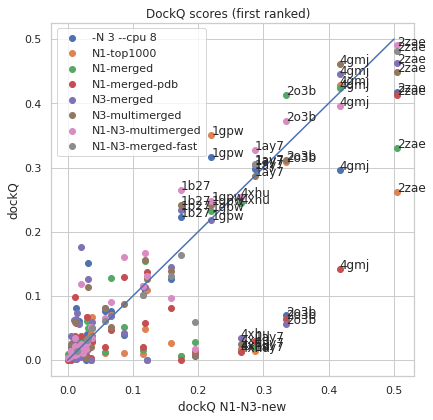

In [144]:
cutoff=0.2
f, ax = plt.subplots(figsize=(6.5, 6.5))
baseset="N1-N3-new"
for d in pdbset:
  
    if d==baseset:continue   
    print (d)
    df_merged = pd.merge(data_first[baseset],data_first[d], on=['CODE'],how="inner")
    print (df_merged)
    #newdf=df_merged["dockQ_x","dockQ_y"]  #.loc[(df_merged.dockQ_x>cutoff or df_merged.dockQ_y>cutoff) ]
    plt.scatter(df_merged.dockQ_x,df_merged.dockQ_y,label=d)
    for i, txt in enumerate(df_merged.name_x):
        #print (i,txt)
        try: 
            sstr=txt[0:4]
        except:
            sstr=df_merged.name_y[i][0:4]
        if (df_merged.dockQ_x[i]> cutoff or df_merged.dockQ_y[i]>cutoff):
            ax.annotate(sstr, (df_merged.dockQ_x[i], df_merged.dockQ_y[i]))
x=[0,0.5]
y=[0,0.5]
plt.plot(x,y)
ax.legend()
ax.set_title("DockQ scores (first ranked)  ")
ax.set_xlabel("dockQ "+baseset)
ax.set_ylabel("dockQ")

#cat.add_categories([1])
#df_merged.fillna(0, inplace =True)

No handles with labels found to put in legend.


Text(0, 0.5, 'dockQ')

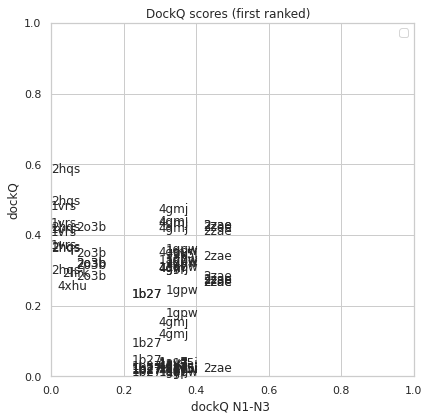

In [110]:
cutoff=0.2
f, ax = plt.subplots(figsize=(6.5, 6.5))
for d in JHsets:
  
    #if d!="N1-merged":continue   
    #print (d)
    df_merged = pd.merge(data_first[datasets[0]],data_first[d], on=['code'],how="inner")
    #print (df_merged)
    #newdf=df_merged["dockQ_x","dockQ_y"]  #.loc[(df_merged.dockQ_x>cutoff or df_merged.dockQ_y>cutoff) ]
    #plt.scatter(df_merged.dockQ_x,df_merged.dockQ_y,label=d)
    for i, txt in enumerate(df_merged.name_x):
        #print (i,txt)
        try: 
            sstr=txt[0:4]
        except:
            sstr=df_merged.name_y[i][0:4]
        if (df_merged.dockQ_x[i]> cutoff or df_merged.dockQ_y[i]>cutoff):
            ax.annotate(sstr, (df_merged.dockQ_x[i], df_merged.dockQ_y[i]))
#x=[0,0.3]
#y=[0,0.3]
#plt.plot(x,y)
ax.legend()
ax.set_title("DockQ scores (first ranked)  ")
ax.set_xlabel("dockQ N1-N3 ")
ax.set_ylabel("dockQ")

#cat.add_categories([1])
#df_merged.fillna(0, inplace =True)

In [111]:
goodmodels

array(['1gpw', '1vrs', '2hqs', '2nxn', '2o3b', '2zae', '3a8i', '3fpu',
       '4bmp', '4c6t', '4gmj', '4txo', '2hrk', '1ay7', '1b27', '1gcq',
       '1v5i', '2d5r', '2wbw', '2x9a', '3a1p', '3f1p', '4xs0', '3pv6',
       '5cra', '4pw9', '4xhu', '4xkl', '2nqd', '2ejf', '4etw'],
      dtype=object)

In [112]:
JHsets

['-N 3 --cpu 8',
 '-N 1 -E 1.e-100 --cpu 8',
 '-N 1 -E 1.e-2 ',
 'N1-merged-pdb',
 'N1-merged',
 '-N 1 -E 1.e-10 --cpu 8 ',
 'N1-top1000-merged',
 'N1-top1000',
 'N1-top100',
 'N1-top2000',
 'N1-top500',
 '-N 5 --cpu 8']

In [113]:
JHsets1=['-N 3 --cpu 8',
 '-N 1 -E 1.e-100 --cpu 8',
 '-N 1 -E 1.e-2 ',
 'N1-merged-pdb',
 'N1-merged',
 '-N 1 -E 1.e-10 --cpu 8 ']

In [114]:
JHsets2=[
 'N1-top1000-merged',
 'N1-top1000',
 'N1-top100',
 'N1-top2000',
 'N1-top500',
 '-N 5 --cpu 8']

In [115]:
JHsets=['-N 3 --cpu 8',
 '-N 1 -E 1.e-2 --cpu 8',
 '-N 1 -E 1.e-10 --cpu 8 ',
 '-N 5 --cpu 8']
good_df=df_first.loc[(df_first.code.isin(goodmodels))&(df_first.JHparams.isin(JHsets))].reset_index()


In [116]:
train_df=df_first.loc[(df_first.code.isin(goodmodels))&(df_first.JHparams.isin(JHsets1))].reset_index()
test_df=df_first.loc[(df_first.code.isin(goodmodels))&(df_first.JHparams.isin(JHsets2))].reset_index()

In [117]:
good_df=df_first.loc[(df_first.code.isin(goodmodels)&(df_first.JHparams.isin(JHsets)))].reset_index()

In [118]:
good_df=df_first.loc[(df_first.JHparams.isin(JHsets))].reset_index()

In [119]:
good_df

index                 name      JHparams lenA lenB   msa    msaA    msaB  \
0        0  1ay7_u1_A-1ay7_u2_A  -N 3 --cpu 8   97   90  1060    1485    2034   
1        2  1b27_u1_A-1b27_u2_A  -N 3 --cpu 8  109   90   733    1484    2034   
2        4  1bdj_u1_A-1bdj_u2_A  -N 3 --cpu 8  129  118  5651  349880   23051   
3        6  1buh_u1_A-1buh_u2_A  -N 3 --cpu 8  291   72  1177  555226    1820   
4        8  1bvn_u1_A-1bvn_u2_A  -N 3 --cpu 8  496   75    95   52623     123   
..     ...                  ...           ...  ...  ...   ...     ...     ...   
648   6718  4zfr_u1_A-4zfr_u2_A  -N 5 --cpu 8  186   77  1358   14421   42037   
649   6720  5brr_u1_A-5brr_u2_A  -N 5 --cpu 8  378  266   611   13523   45636   
650   6722  5cec_u1_A-5cec_u2_A  -N 5 --cpu 8  403  191  1594   33067  312612   
651   6724  5cra_u1_A-5cra_u2_A  -N 5 --cpu 8  193   77     1      11   42026   
652   6726  5eg3_u1_A-5eg3_u2_A  -N 5 --cpu 8  303  105   499  560629   26558   

    cdhit  dockQ  ...  CODE        params      tmAB     msaAB tmAB_max  \
0    1026  0.298  ...  1ay7  -N 3 --cpu 8  0.828190    1759.5  0.84625   
1     654  0.223  ...  1b27  -N 3 --cpu 8  0.824750    1759.0  0.85428   
2    5071      0  ...  1bdj  -N 3 --cpu 8  0.861435  186465.5  0.92240   
3     548      0  ...  1buh  -N 3 --cpu 8  0.560760  278523.0  0.73259   
4      85  0.006  ...  1bvn  -N 3 --cpu 8  0.619740   26373.0  0.70905   
..    ...    ...  ...   ...           ...       ...       ...      ...   
648   490      0  ...  4zfr  -N 5 --cpu 8  0.796765   28229.0  0.83034   
649   550   0.02  ...  5brr  -N 5 --cpu 8  0.790865   29579.5  0.80934   
650  1577      0  ...  5cec  -N 5 --cpu 8  0.628690  172839.5  0.85640   
651     1  0.008  ...  5cra  -N 5 --cpu 8  0.536735   21018.5  0.71605   
652   278      0  ...  5eg3  -N 5 --cpu 8  0.733390  293593.5  0.77821   

    msaAB_max tmAB_min msaAB_min numcorrect  len  
0      2034.0  0.81013    1485.0     53.985  187  
1      2034.0  0.79522    1484.0     49.025  199  
2    349880.0  0.80047   23051.0          0  247  
3    555226.0  0.38893    1820.0          0  363  
4     52623.0  0.53043     123.0          0  571  
..        ...      ...       ...        ...  ...  
648   42037.0  0.76319   14421.0          0  263  
649   45636.0  0.77239   13523.0          2  644  
650  312612.0  0.40098   33067.0          0  594  
651   42026.0  0.35742      11.0          0  270  
652  560629.0  0.68857   26558.0          0  408  

[653 rows x 54 columns]

In [120]:
cutoff

0.2

AttributeError: 'float' object has no attribute 'shape'

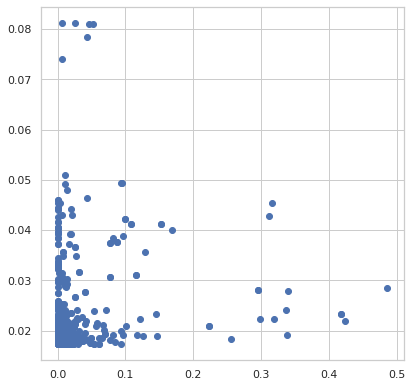

AttributeError: 'float' object has no attribute 'shape'

In [121]:
ydata=good_df.dockQ
cols=["lenA","lenB","msa","long","med","longA","medA","longB","medB","tmA","tmB"]

#xdata=good_df[["lenA","lenB","long","med"]]
#cols=["longA","longB","medA","medB","tmA","tmB"]
cols=["med","long","msa"]
#cols=["msa"]
xdata=good_df[cols]


reg.fit(xdata,ydata)
ypred = reg.predict(xdata)
f, ax = plt.subplots(figsize=(6.5, 6.5))
plt.scatter(ydata,ypred)
cc=np.corrcoef(ydata,ypred)
ax.set_xlabel("dockQ")
ax.set_ylabel("predicted dockQ")
(i,j,dockq,mm)=get_ranks(good_df,ypred)
#print(i,j,k/i)
ax.set_title("CC" + " " + str(round(cc[0,1],3))
            + " Good: " + str(round(j/i,3)) + " Loss: " + str(round(dockq/i,3))
             + " , " + str(round(mm/i,3))
             + " Test: " + str(i)
            )


In [122]:
print('Intercept: \n', reg.intercept_)
print('Coefficients: \n', reg.coef_)

Intercept: 
 0.017264452560890185
Coefficients: 
 [-9.39123219e-05  2.66632285e-05  3.52796383e-06]


In [123]:

for s in JHsets:
    set_df=good_df.loc[good_df.params==s]
    ypred=set_df["dockQ"].to_list()
    (i,j,dockq,mm)=get_ranks(set_df,ypred)
    print (s,i,j,dockq,mm)

-N 3 --cpu 8 6 6 0.0 0.0
-N 1 -E 1.e-2 --cpu 8 0 0 0 0


-N 1 -E 1.e-10 --cpu 8  6 6 0.0 0.0


-N 5 --cpu 8 4 4 0.0 0.0


AttributeError: 'float' object has no attribute 'shape'

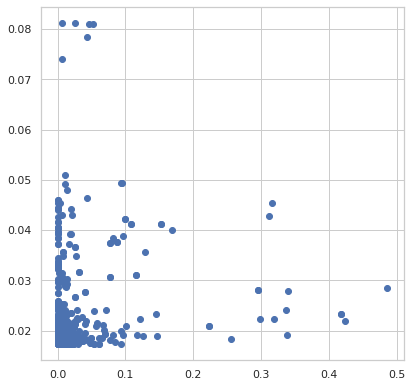

AttributeError: 'float' object has no attribute 'shape'

In [124]:
xdata=good_df[cols]
ydata=good_df.dockQ

ypred = reg.predict(xdata)
f, ax = plt.subplots(figsize=(6.5, 6.5))
plt.scatter(ydata,ypred)
cc=np.corrcoef(ydata,ypred)
ax.set_title("CC" + " " + str(cc[0,1]))
ax.set_xlabel("dockQ")
ax.set_ylabel("predicted dockQ")


In [125]:
good_df=df_first.loc[(df_first.code.isin(goodmodels))&(df_first.JHparams.isin(JHsets))].reset_index()
good_df

index                 name      JHparams lenA lenB   msa    msaA    msaB  \
0       0  1ay7_u1_A-1ay7_u2_A  -N 3 --cpu 8   97   90  1060    1485    2034   
1       2  1b27_u1_A-1b27_u2_A  -N 3 --cpu 8  109   90   733    1484    2034   
2      30  1gcq_u1_A-1gcq_u2_A  -N 3 --cpu 8   66   57  1365   77497   77704   
3      34  1gpw_u1_A-1gpw_u2_A  -N 3 --cpu 8  252  204  7137   58466   67629   
4      86  1v5i_u1_A-1v5i_u2_A  -N 3 --cpu 8  276   78  1922   54177   12066   
..    ...                  ...           ...  ...  ...   ...     ...     ...   
88   6692  4txo_u1_A-4txo_u2_A  -N 5 --cpu 8  178  158  7106  131653  115265   
89   6702  4xhu_u1_A-4xhu_u2_A  -N 5 --cpu 8  352   95   410    9970     548   
90   6704  4xkl_u1_A-4xkl_u2_A  -N 5 --cpu 8   76   34  1262   41752  442180   
91   6708  4xs0_u1_A-4xs0_u2_A  -N 5 --cpu 8  147  141  3395    9453    9375   
92   6724  5cra_u1_A-5cra_u2_A  -N 5 --cpu 8  193   77     1      11   42026   

   cdhit  dockQ  ...  CODE        params      tmAB     msaAB tmAB_max  \
0   1026  0.298  ...  1ay7  -N 3 --cpu 8  0.828190    1759.5  0.84625   
1    654  0.223  ...  1b27  -N 3 --cpu 8  0.824750    1759.0  0.85428   
2    765  0.115  ...  1gcq  -N 3 --cpu 8  0.539990   77600.5  0.63426   
3   5348  0.316  ...  1gpw  -N 3 --cpu 8  0.885175   63047.5  0.89229   
4   1642  0.336  ...  1v5i  -N 3 --cpu 8  0.818890   33121.5  0.88557   
..   ...    ...  ...   ...           ...       ...       ...      ...   
88  6529  0.022  ...  4txo  -N 5 --cpu 8  0.725480  123459.0  0.74765   
89   240  0.018  ...  4xhu  -N 5 --cpu 8  0.678145    5259.0  0.73972   
90   355  0.014  ...  4xkl  -N 5 --cpu 8  0.740180  241966.0  0.88845   
91  2649  0.094  ...  4xs0  -N 5 --cpu 8  0.732555    9414.0  0.74440   
92     1  0.008  ...  5cra  -N 5 --cpu 8  0.536735   21018.5  0.71605   

   msaAB_max tmAB_min msaAB_min numcorrect  len  
0     2034.0  0.81013    1485.0     53.985  187  
1     2034.0  0.79522    1484.0     49.025  199  
2    77704.0  0.44572   77497.0      71.76  123  
3    67629.0  0.87806   58466.0     96.033  456  
4    54177.0  0.75221   12066.0          1  354  
..       ...      ...       ...        ...  ...  
88  131653.0  0.70331  115265.0          1  336  
89    9970.0  0.61657     548.0          0  447  
90  442180.0  0.59191   41752.0          0  110  
91    9453.0  0.72071    9375.0    224.928  288  
92   42026.0  0.35742      11.0          0  270  

[93 rows x 54 columns]

In [126]:
# Now we try all combinations - no plots
set1_df=df_first.loc[(df_first.code.isin(goodmodels))&(df_first.JHparams.isin(JHsets1))].reset_index()
set2_df=df_first.loc[(df_first.code.isin(goodmodels))&(df_first.JHparams.isin(JHsets2))].reset_index()
good_df=df_first.loc[(df_first.code.isin(goodmodels))&(df_first.JHparams.isin(JHsets))].reset_index()

cols=["lenA","lenB","msa","long","med","longA","medA","longB","medB","tmA","tmB"]
ydata=good_df.dockQ

res={}
maxvalue=0
for c in cols:
    xdata=good_df[[c]]
    reg.fit(xdata,ydata)
    ypred = reg.predict(xdata)
    print (c,round(np.corrcoef(ydata,ypred)[0,1],3))
    res[c]=np.corrcoef(ydata,ypred)[0,1]
    maxvalue=max(res[c],maxvalue)    
for c in cols:
    for d in cols:
        xdata=good_df[[c,d]]
        reg.fit(xdata,ydata)
        ypred = reg.predict(xdata)
        #print (c,d,round(np.corrcoef(ydata,ypred)[0,1],3))
        res[c+d]=np.corrcoef(ydata,ypred)[0,1]
        #if (res[c+d]-maxvalue>0.0):
        #    print (c,d,round(np.corrcoef(ydata,ypred)[0,1],3))
        (i,j,k,l)=get_ranks(good_df,ypred)
        print (c,d,i,j,k,l)

AttributeError: 'float' object has no attribute 'shape'

In [127]:

print('Intercept: \n', reg.intercept_)
print('Coefficients: \n', reg.coef_)


Intercept: 
 0.12327351144312704
Coefficients: 
 [-0.0001284]


Text(0, 0.5, 'predicted dockQ')

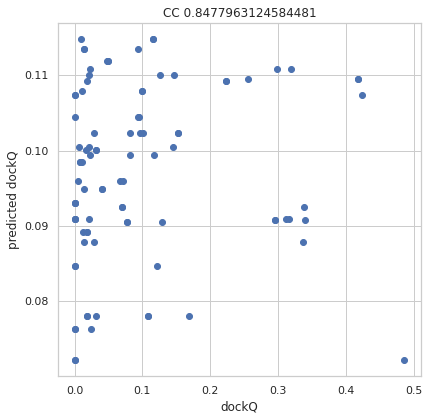

In [128]:
ypred = reg.predict(xdata)
f, ax = plt.subplots(figsize=(6.5, 6.5))
plt.scatter(ydata,ypred)
#cc=np.corrcoef(ydata,ypred)
ax.set_title("CC" + " " + str(cc[0,1]))
ax.set_xlabel("dockQ")
ax.set_ylabel("predicted dockQ")


In [129]:
newdf=df.loc[df.JHparams=="trRosetta"]
plt.scatter(newdf.csv,newdf.)

SyntaxError: invalid syntax (<ipython-input-129-1bbe5c8e123e>, line 2)

In [130]:
newdf[["CODE","dockQ","csv","tmAB","long"]].sort_values("csv")

KeyError: "['csv'] not in index"

In [131]:
JHsets=['-N 3 --cpu 8', 
       '-N 1 -E 1.e-100 --cpu 8', '-N 1 -E 1.e-2 ', 'N1-merged-pdb',
       'N1-merged', '-N 1 -E 1.e-10 --cpu 8 ', 'N1-top1000-merged',
       'N1-top1000', 'N1-top100', 'N1-top2000', 'N1-top500',  '-N 5 --cpu 8']


Text(0.5, 0, 'cdhit')

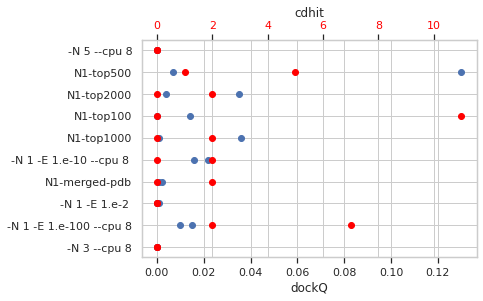

In [132]:
newdf=df.loc[(df.CODE=="4etw")&(df.JHparams.isin(JHsets))].reset_index()
fig, ax1 = plt.subplots()
ax1.set_xlabel('dockQ')
ax1.scatter(newdf.dockQ,newdf.JHparams)
ax2 = ax1.twiny()  # instantiate a second axes that shares the same x-axis
ax2.scatter(newdf.long,newdf.JHparams,color="red")
ax2.tick_params(axis='x', labelcolor="red")
ax2.set_xlabel('cdhit')

Text(0.5, 0, 'cdhit')

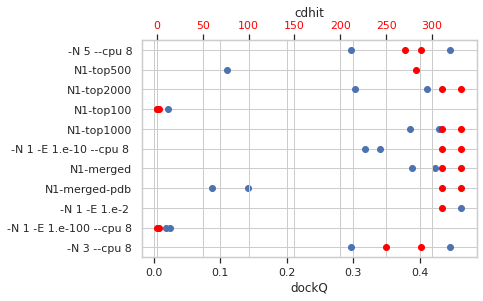

In [133]:
newdf=df.loc[(df.CODE=="4gmj")&(df.JHparams.isin(JHsets))].reset_index()
fig, ax1 = plt.subplots()
ax1.set_xlabel('dockQ')
ax1.scatter(newdf.dockQ,newdf.JHparams)
ax2 = ax1.twiny()  # instantiate a second axes that shares the same x-axis
ax2.scatter(newdf.long,newdf.JHparams,color="red")
ax2.tick_params(axis='x', labelcolor="red")
ax2.set_xlabel('cdhit')

# bes models to test 2zae 4gmj
# Bad model 4etw

In [134]:
df_max.loc[(df_max.params=="trRosetta") & (df_max.dockQ==0)]

name  lenA  lenB     msa      msaA      msaB  \
JHparams  code                                                                
trRosetta 3fap  3fap_u2_A-3fap_u1_A   108   108  1208.0   35975.0   35975.0   
          3l1z  3l1z_u2_A-3l1z_u1_A   153   153  1390.0  136672.0  136672.0   
          3rj3  3rj3_u2_A-3rj3_u1_A   295   295   359.0   55937.0   55937.0   
          4emj  4emj_u2_A-4emj_u1_A   403   403  6589.0  354953.0  354953.0   

                cdhit  dockQ  fnat     iRMS  ...  CODE     params      tmAB  \
JHparams  code                               ...                              
trRosetta 3fap    573    0.0   0.0  187.525  ...  3fap  trRosetta  0.840125   
          3l1z    830    0.0   0.0  261.906  ...  3l1z  trRosetta  0.776680   
          3rj3    247    0.0   0.0  515.213  ...  3rj3  trRosetta  0.635370   
          4emj   5681    0.0   0.0  687.538  ...  4emj  trRosetta  0.884110   

                   msaAB  tmAB_max  msaAB_max  tmAB_min  msaAB_min  \
JHparams  code                                                       
trRosetta 3fap   18731.0   0.87845    35975.0   0.80207     1489.0   
          3l1z   87194.0   0.83424   136672.0   0.72778    37864.0   
          3rj3   39722.5   0.80210    55937.0   0.48427    23508.0   
          4emj  195361.5   0.90839   354953.0   0.86736    35929.0   

                numcorrect  len  
JHparams  code                   
trRosetta 3fap         0.0  201  
          3l1z         0.0  239  
          3rj3         0.0  421  
          4emj         0.0  509  

[4 rows x 51 columns]